In [1]:
import tensorflow as tf
print(tf.__version__)


2.16.1


In [2]:
import rasterio
from rasterio.enums import Resampling
import numpy as np

# Load Sentinel-2 image
with rasterio.open('London_Sentinel2_2018_2023-0000000000-0000000000.tif') as src:
    sentinel_image = src.read()
    sentinel_meta = src.meta

# Load NDVI data and resample it
with rasterio.open('London_NDVI_2018_2023.tif') as src:
    # Calculate the scaling factor
    scale_factor_x = sentinel_image.shape[2] / src.width
    scale_factor_y = sentinel_image.shape[1] / src.height

    # Perform resampling
    ndvi_image = src.read(
        1,  # Assuming the NDVI data has only one band
        out_shape=(sentinel_image.shape[1], sentinel_image.shape[2]),
        resampling=Resampling.bilinear
    )
    
print(f"Sentinel-2 image shape: {sentinel_image.shape}")
print(f"Resampled NDVI image shape: {ndvi_image.shape}")

# Ensure the image sizes are now consistent
assert sentinel_image.shape[1:] == ndvi_image.shape, "Image sizes are still inconsistent"



Sentinel-2 image shape: (16, 4519, 5888)
Resampled NDVI image shape: (4519, 5888)


In [3]:
# Continue the feature extraction process
def extract_building_density(image):
    # Simplified building density calculation using the near-infrared band (usually band 4) and red band (usually band 3)
    # Assume buildings reflect more in the near-infrared band than in the red band
    buildings = np.sum(image[3] > image[2]) / (image.shape[1] * image.shape[2])
    return buildings

def extract_vegetation_coverage(ndvi):
    # Typically, NDVI > 0.2 indicates vegetation coverage
    vegetation = np.sum(ndvi > 0.2) / ndvi.size
    return vegetation

# Apply functions to extract features
building_density = extract_building_density(sentinel_image)
vegetation_coverage = extract_vegetation_coverage(ndvi_image)

print(f"Building Density: {building_density}")
print(f"Vegetation Coverage: {vegetation_coverage}")


建筑密度: 0.09493070321444722
植被覆盖率: 0.7184793658057285


In [4]:
# Process fire incident data
import pandas as pd

# Load fire incident data
df = pd.read_excel('LFB_Incident_Fire_Only.xlsx')

# Extract climate-related features
climate_features = df[['HourOfCall', 'Latitude', 'Longitude']]

# Combine all features together
features = pd.DataFrame({
    'building_density': [building_density] * len(df),
    'vegetation_coverage': [vegetation_coverage] * len(df),
})

# Add climate features to the DataFrame
features = pd.concat([features, climate_features], axis=1)

print(features.head())


   building_density  vegetation_coverage  HourOfCall   Latitude  Longitude
0          0.094931             0.718479           0  51.621823  -0.096022
1          0.094931             0.718479           0  51.549924   0.009877
2          0.094931             0.718479           0  51.601468   0.164267
3          0.094931             0.718479           0  51.599631   0.039794
4          0.094931             0.718479           0  51.520836   0.024279


In [5]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree

# Step 1: Load and preprocess image data
def load_and_resample(sentinel_path, ndvi_path):
    with rasterio.open(sentinel_path) as src:
        sentinel_image = src.read()
        sentinel_meta = src.meta
        transform = src.transform

    with rasterio.open(ndvi_path) as src:
        ndvi_image = src.read(
            1,
            out_shape=(sentinel_image.shape[1], sentinel_image.shape[2]),
            resampling=Resampling.bilinear
        )

    return sentinel_image, ndvi_image, transform

sentinel_image, ndvi_image, transform = load_and_resample(
    'London_Sentinel2_2018_2023-0000000000-0000000000.tif',
    'London_NDVI_2018_2023.tif'
)

# Step 2: Define grid size and create grid
grid_size = 100  # Number of pixels per grid cell
rows, cols = sentinel_image.shape[1] // grid_size, sentinel_image.shape[2] // grid_size

# Step 3: Calculate building density and vegetation coverage for each grid cell
def calculate_features(image, ndvi, grid_size):
    features = []
    for i in range(0, image.shape[1], grid_size):
        for j in range(0, image.shape[2], grid_size):
            cell_image = image[:, i:i+grid_size, j:j+grid_size]
            cell_ndvi = ndvi[i:i+grid_size, j:j+grid_size]
            
            # Calculate building density (simplified version)
            building_density = np.sum(cell_image[3] > cell_image[2]) / (grid_size ** 2)
            
            # Calculate vegetation coverage
            vegetation_coverage = np.sum(cell_ndvi > 0.2) / (grid_size ** 2)
            
            # Calculate the coordinates of the center point of the grid cell
            center_x, center_y = transform * (j + grid_size/2, i + grid_size/2)
            
            features.append([center_x, center_y, building_density, vegetation_coverage])
    
    return np.array(features)

grid_features = calculate_features(sentinel_image, ndvi_image, grid_size)

# Step 4: Load fire incident data
df = pd.read_excel('LFB_Incident_Fire_Only.xlsx')

# Step 5: Associate fire incidents with grid cells
def associate_events_with_grid(events, grid_features):
    # Ensure longitude and latitude are numeric types
    events['Longitude'] = pd.to_numeric(events['Longitude'], errors='coerce')
    events['Latitude'] = pd.to_numeric(events['Latitude'], errors='coerce')
    
    # Drop rows containing NaN values
    events = events.dropna(subset=['Longitude', 'Latitude'])
    
    # Remove rows with infinite values
    events = events[~events[['Longitude', 'Latitude']].isin([np.inf, -np.inf]).any(axis=1)]
    
    # Create a KD-tree to speed up nearest neighbor search
    tree = cKDTree(grid_features[:, :2])
    
    # For each event, find the nearest grid cell
    coordinates = events[['Longitude', 'Latitude']].values
    distances, indices = tree.query(coordinates)
    
    # Add grid features to the event data
    events['building_density'] = grid_features[indices, 2]
    events['vegetation_coverage'] = grid_features[indices, 3]
    
    return events

# Print some diagnostic information before performing the association
print("Original data shape:", df.shape)
print("Longitude data types:", df['Longitude'].dtype)
print("Latitude data types:", df['Latitude'].dtype)
print("Longitude range:", df['Longitude'].min(), "-", df['Longitude'].max())
print("Latitude range:", df['Latitude'].min(), "-", df['Latitude'].max())

df_with_features = associate_events_with_grid(df, grid_features)

# Print the result
print("\nProcessed data shape:", df_with_features.shape)
print(df_with_features[['Latitude', 'Longitude', 'building_density', 'vegetation_coverage']].head())

# Save the results to a new Excel file
df_with_features.to_excel('London_Fire_Events_with_Features.xlsx', index=False)


Original data shape: (110104, 39)
Longitude data types: float64
Latitude data types: float64
Longitude range: -0.5101547173 - 0.3092613385
Latitude range: 0.0 - 51.6914581838

Processed data shape: (76124, 41)
    Latitude  Longitude  building_density  vegetation_coverage
0  51.621823  -0.096022            0.0756               0.9773
1  51.549924   0.009877            0.0768               0.8875
2  51.601468   0.164267            0.0236               0.8747
3  51.599631   0.039794            0.0236               0.8747
4  51.520836   0.024279            0.1081               0.6664


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed data
df = pd.read_excel('London_Fire_Events_with_Features.xlsx')

# 1. Basic statistical description
print(df.describe())

# 2. Correlation analysis
correlation_matrix = df[['building_density', 'vegetation_coverage', 'Latitude', 'Longitude']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 3. Geographic distribution of fire incidents
plt.figure(figsize=(12, 10))
plt.scatter(df['Longitude'], df['Latitude'], c=df['building_density'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Building Density')
plt.title('Fire Incidents in London')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# 4. Distribution of building density and vegetation coverage
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.histplot(df['building_density'], kde=True)
plt.title('Distribution of Building Density')
plt.subplot(122)
sns.histplot(df['vegetation_coverage'], kde=True)
plt.title('Distribution of Vegetation Coverage')
plt.tight_layout()
plt.show()

# 5. Temporal distribution of fire incidents
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'])
df['Month'] = df['DateOfCall'].dt.month
df['Year'] = df['DateOfCall'].dt.year

monthly_incidents = df.groupby(['Year', 'Month']).size().reset_index(name='Incidents')
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_incidents, x='Month', y='Incidents', hue='Year')
plt.title('Monthly Fire Incidents')
plt.show()

# 6. Scatter plot of building density vs vegetation coverage
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='building_density', y='vegetation_coverage', alpha=0.5)
plt.title('Building Density vs Vegetation Coverage')
plt.show()


In [ ]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree


# Step 5: Associate fire incidents with grid cells
def associate_events_with_grid(events, grid_features):
    # Ensure Latitude and Longitude are numeric types
    events['Longitude'] = pd.to_numeric(events['Longitude'], errors='coerce')
    events['Latitude'] = pd.to_numeric(events['Latitude'], errors='coerce')
    
    # Remove rows with NaN values
    events = events.dropna(subset=['Longitude', 'Latitude'])
    
    # Remove rows with infinite values
    events = events[~events[['Longitude', 'Latitude']].isin([np.inf, -np.inf]).any(axis=1)]
    
    # Create a KDTree to speed up nearest neighbor search
    tree = cKDTree(grid_features[:, :2])
    
    # Find the nearest grid cell for each event
    coordinates = events[['Longitude', 'Latitude']].values
    distances, indices = tree.query(coordinates)
    
    # Add grid features to event data
    events['building_density'] = grid_features[indices, 2]
    events['vegetation_coverage'] = grid_features[indices, 3]
    
    return events

df_with_features = associate_events_with_grid(df, grid_features)

# Add some additional features
df_with_features['DateOfCall'] = pd.to_datetime(df_with_features['DateOfCall'])
df_with_features['Month'] = df_with_features['DateOfCall'].dt.month
df_with_features['Year'] = df_with_features['DateOfCall'].dt.year
df_with_features['DayOfWeek'] = df_with_features['DateOfCall'].dt.dayofweek
df_with_features['Hour'] = df_with_features['DateOfCall'].dt.hour

# Save the result to a new Excel file
output_file = 'London_Fire_Events_with_Features_Detailed.xlsx'
df_with_features.to_excel(output_file, index=False)

print(f"Detailed results have been saved to {output_file}")
print(f"Data shape: {df_with_features.shape}")
print("\nFirst few rows of data:")
print(df_with_features.head())

# Print some basic statistical information
print("\nBasic statistical information:")
print(df_with_features[['building_density', 'vegetation_coverage', 'Latitude', 'Longitude']].describe())


In [ ]:
import osmnx as ox
import geopandas as gpd
import pandas as pd

# Use the new function name to get land use data
land_use = ox.features_from_place("London, UK", tags={"landuse": True})

# Print all column names
print("Available columns:")
print(land_use.columns.tolist())

# Define a function to safely convert complex objects to strings
def safe_convert(x):
    if isinstance(x, (list, dict)):
        return str(x)
    elif pd.isna(x):
        return None
    else:
        return x

# Apply the conversion function to all 'object' type columns
for column in land_use.columns:
    if land_use[column].dtype == 'object':
        land_use[column] = land_use[column].apply(safe_convert)

# Select some key columns to simplify the data
# We will check if each column exists and skip if it doesn't
key_columns = ['geometry', 'landuse', 'name', 'area', 'type', 'natural']
existing_columns = [col for col in key_columns if col in land_use.columns]
land_use_simplified = land_use[existing_columns]

# Attempt to save the simplified data as GeoJSON
try:
    land_use_simplified.to_file("london_land_use_simplified.geojson", driver="GeoJSON")
    print("Simplified land use data has been saved to 'london_land_use_simplified.geojson'")
except Exception as e:
    print(f"Error saving GeoJSON file: {e}")
    print("Attempting to save in GeoPackage format...")
    land_use_simplified.to_file("london_land_use_simplified.gpkg", driver="GPKG")
    print("Simplified land use data has been saved to 'london_land_use_simplified.gpkg'")

# Get fire station data
fire_stations = ox.features_from_place("London, UK", tags={"amenity":"fire_station"})

# Apply the same processing to the fire station data
for column in fire_stations.columns:
    if fire_stations[column].dtype == 'object':
        fire_stations[column] = fire_stations[column].apply(safe_convert)

# Print columns of fire station data
print("\nFire station data columns:")
print(fire_stations.columns.tolist())

# Select key columns
fire_stations_key_columns = ['geometry', 'name', 'amenity', 'operator']
fire_stations_existing_columns = [col for col in fire_stations_key_columns if col in fire_stations.columns]
fire_stations_simplified = fire_stations[fire_stations_existing_columns]

# Save as a GeoJSON file
try:
    fire_stations_simplified.to_file("london_fire_stations_simplified.geojson", driver="GeoJSON")
    print("Simplified fire station data has been saved to 'london_fire_stations_simplified.geojson'")
except Exception as e:
    print(f"Error saving GeoJSON file: {e}")
    print("Attempting to save in GeoPackage format...")
    fire_stations_simplified.to_file("london_fire_stations_simplified.gpkg", driver="GPKG")
    print("Simplified fire station data has been saved to 'london_fire_stations_simplified.gpkg'")

# Print data shapes
print(f"\nLand use data shape: {land_use_simplified.shape}")
print(f"Fire station data shape: {fire_stations_simplified.shape}")


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import Arrow
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import numpy as np

# Load data and filter for polygons only for land use
land_use = gpd.read_file('london_land_use_simplified.geojson')
land_use = land_use[land_use.geometry.geom_type == 'Polygon']

# Load fire stations (keep all geometries)
fire_stations = gpd.read_file('london_fire_stations_simplified.geojson')

# Ensure data is in a projected coordinate system for accurate distance measurements
land_use = land_use.to_crs(epsg=27700)  # OSGB 1936 / British National Grid
fire_stations = fire_stations.to_crs(epsg=27700)

# Create map
fig, ax = plt.subplots(figsize=(15, 15))

# Plot land use
land_use.plot(column='landuse', cmap='Set3', ax=ax, legend=False, alpha=0.7)

# Plot all fire stations
for idx, row in fire_stations.iterrows():
    if row.geometry.geom_type == 'Point':
        ax.plot(row.geometry.x, row.geometry.y, marker='*', color='red', markersize=10, markeredgecolor='black', markeredgewidth=0.5, zorder=5)
    elif row.geometry.geom_type in ['Polygon', 'MultiPolygon']:
        ax.plot(row.geometry.centroid.x, row.geometry.centroid.y, marker='*', color='red', markersize=10, markeredgecolor='black', markeredgewidth=0.5, zorder=5)

# Set title
plt.title('London Land Use Types and Fire Station Distribution', fontsize=16)

# Create custom legend
unique_landuse = land_use['landuse'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_landuse)))
patches = [mpatches.Patch(color=colors[i], label=landuse, alpha=0.7) for i, landuse in enumerate(unique_landuse)]
patches.append(Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markersize=15, label='Fire Stations'))

# Add legend outside the map
plt.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=8, title="Legend")

# Remove axis
plt.axis('off')

# Add north arrow
north_arrow = AnchoredText('N', loc='upper left', prop={'size': 20}, frameon=True)
ax.add_artist(north_arrow)
# Add arrow
ax.add_patch(Arrow(0.05, 0.95, 0, 0.05, width=0.03, transform=ax.transAxes, color='black'))

# Add scale bar with an appropriate length and unit
scale_bar = ScaleBar(dx=1, units="m", length_fraction=0.1, location='lower left', scale_loc='bottom', font_properties={'size': 12})
ax.add_artist(scale_bar)

# Adjust layout and save
plt.tight_layout()
plt.savefig('london_map_all_stations_adjusted.png', dpi=300, bbox_inches='tight')

print("Map generated. Please check the image: 'london_map_all_stations_adjusted.png'")

# Analyze land use types
land_use_counts = land_use['landuse'].value_counts()
print("\nLand Use Type Distribution:")
print(land_use_counts)

# Plot land use type distribution
plt.figure(figsize=(12, 6))
land_use_counts.plot(kind='bar')
plt.title('Distribution of Land Use Types in London')
plt.xlabel('Land Use Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('land_use_distribution_updated.png')

print("\nAnalysis complete. Please check the generated images: 'land_use_distribution_updated.png' and 'london_map_all_stations_adjusted.png'")


In [ ]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import time

# Load the raw data
df = pd.read_excel('London_Fire_Events_with_Features_Detailed.xlsx')

# Met Office DataPoint API key
API_KEY = "bf120d24-04b8-4aa0-98b0-c9210a750ebe"

# Get all weather stations
def get_all_stations():
    url = f"http://datapoint.metoffice.gov.uk/public/data/val/wxobs/all/json/sitelist?key={API_KEY}"
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to retrieve station list: {response.status_code}")
    return response.json()['Locations']['Location']

# Find the nearest weather station
def get_nearest_station(lat, lon, stations):
    nearest = min(stations, key=lambda s: (float(s['latitude']) - lat)**2 + (float(s['longitude']) - lon)**2)
    return nearest['id']

# Retrieve weather data
def get_weather_data(station_id, date):
    date_str = date.strftime("%Y-%m-%d")
    url = f"http://datapoint.metoffice.gov.uk/public/data/val/wxobs/all/json/{station_id}?res=hourly&date={date_str}&key={API_KEY}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve weather data: {response.status_code}, Station: {station_id}, Date: {date_str}")
        return {'temperature': np.nan, 'humidity': np.nan, 'wind_speed': np.nan}
    
    data = response.json()
    if 'SiteRep' not in data or 'DV' not in data['SiteRep'] or 'Location' not in data['SiteRep']['DV']:
        print(f"Unexpected data structure, Station: {station_id}, Date: {date_str}")
        return {'temperature': np.nan, 'humidity': np.nan, 'wind_speed': np.nan}
    
    periods = data['SiteRep']['DV']['Location']['Period']
    if not periods:
        print(f"No data found, Station: {station_id}, Date: {date_str}")
        return {'temperature': np.nan, 'humidity': np.nan, 'wind_speed': np.nan}
    
    hour_data = periods[0]['Rep']
    hour = int(date.strftime("%H"))
    closest_data = min(hour_data, key=lambda x: abs(int(x['$']) - hour * 60))
    
    return {
        'temperature': float(closest_data.get('T', 'NaN')),
        'humidity': float(closest_data.get('H', 'NaN')),
        'wind_speed': float(closest_data.get('S', 'NaN'))
    }

# Process each fire event
def process_fire_event(row, stations_cache):
    try:
        station_id = get_nearest_station(row['Latitude'], row['Longitude'], stations_cache)
        date = pd.to_datetime(row['DateOfCall'])
        weather = get_weather_data(station_id, date)
        return pd.Series(weather)
    except Exception as e:
        print(f"Failed to process fire event: {e}, Row: {row.name}")
        return pd.Series({'temperature': np.nan, 'humidity': np.nan, 'wind_speed': np.nan})

# Main program
if __name__ == "__main__":
    try:
        # Get all weather stations
        print("Retrieving weather stations...")
        stations_cache = get_all_stations()
        print(f"Retrieved {len(stations_cache)} weather stations")

        # Apply the function to the dataframe
        print("Retrieving weather data, this may take some time...")
        weather_data = df.apply(lambda row: process_fire_event(row, stations_cache), axis=1)

        # Add the weather data to the original dataframe
        df = pd.concat([df, weather_data], axis=1)

        # Save the updated data
        output_file = 'London_Fire_Events_with_Weather.xlsx'
        df.to_excel(output_file, index=False)

        print(f"Data updated and saved to {output_file}")
        print(f"Data shape: {df.shape}")
        print("\nNew feature columns:")
        print(weather_data.columns.tolist())
    except Exception as e:
        print(f"Exception in main program: {e}")


In [ ]:
import geopandas as gpd
import pandas as pd

# Load fire event data
fire_events = pd.read_excel('London_Fire_Events_with_Features_Detailed.xlsx')

# Convert fire event data to GeoDataFrame
geometry = gpd.points_from_xy(fire_events.Longitude, fire_events.Latitude)
fire_events_gdf = gpd.GeoDataFrame(fire_events, geometry=geometry, crs="EPSG:4326")

# Load land use data
land_use = gpd.read_file('london_land_use_simplified.geojson')

# Ensure both datasets use the same coordinate system
land_use = land_use.to_crs(fire_events_gdf.crs)

# Perform spatial join
fire_events_with_landuse = gpd.sjoin_nearest(fire_events_gdf, land_use[['landuse', 'geometry']], how="left")

# Remove the index column from the spatial join
fire_events_with_landuse = fire_events_with_landuse.drop(columns=['index_right'])

# Save the result to a new Excel file
fire_events_with_landuse.to_excel('London_Fire_Events_with_Landuse.xlsx', index=False)

print("Processing complete. The new dataset has been saved as 'London_Fire_Events_with_Landuse.xlsx'")

# Print the first few rows to verify
print(fire_events_with_landuse[['IncidentNumber', 'Latitude', 'Longitude', 'landuse']].head())

# Print the distribution of land use types
print("\nLand use type distribution:")
print(fire_events_with_landuse['landuse'].value_counts(normalize=True))

# Check if there are any NaN values
nan_count = fire_events_with_landuse['landuse'].isna().sum()
print(f"\nNumber of events without an assigned land use type: {nan_count}")


In [ ]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import time
from tqdm import tqdm

# Load the original data
df = pd.read_excel('London_Fire_Events_with_Landuse.xlsx')

# Met Office DataPoint API key
API_KEY = "bf120d24-04b8-4aa0-98b0-c9210a750ebe"

# Get all weather stations
def get_all_stations():
    url = f"http://datapoint.metoffice.gov.uk/public/data/val/wxobs/all/json/sitelist?key={API_KEY}"
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to get station list: {response.status_code}")
    return response.json()['Locations']['Location']

# Find the nearest weather stations, sorted by distance
def get_nearest_stations(lat, lon, stations):
    return sorted(stations, key=lambda s: (float(s['latitude']) - lat)**2 + (float(s['longitude']) - lon)**2)

def process_fire_events(df, stations_cache):
    weather_data = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            nearest_stations = get_nearest_stations(row['Latitude'], row['Longitude'], stations_cache)
            
            # Combine DateOfCall and TimeOfCall for more precise timing
            date_time = pd.to_datetime(row['DateOfCall'].date().strftime('%Y-%m-%d') + ' ' + row['TimeOfCall'])
            
            for station in nearest_stations:
                weather = get_weather_data(station['id'], date_time)
                if weather and not np.isnan(weather['temperature']) and not np.isnan(weather['humidity']) and not np.isnan(weather['wind_speed']):
                    weather['station_id'] = station['id']
                    weather['station_name'] = station['name']
                    weather_data.append(weather)
                    break  # Exit loop after finding valid data
            else:
                print(f"\nWarning: No valid weather data found for event ID {row['IncidentNumber']}")
                weather_data.append({'temperature': np.nan, 'humidity': np.nan, 'wind_speed': np.nan, 'station_id': None, 'station_name': None})
            
            time.sleep(0.1)  # Add a small delay to avoid exceeding API limits
        except Exception as e:
            print(f"Failed to process fire event: {e}, row: {row.name}")
            weather_data.append({'temperature': np.nan, 'humidity': np.nan, 'wind_speed': np.nan, 'station_id': None, 'station_name': None})
    
    return pd.DataFrame(weather_data)

def get_weather_data(station_id, date_time):
    date_str = date_time.strftime("%Y-%m-%d")
    url = f"http://datapoint.metoffice.gov.uk/public/data/val/wxobs/all/json/{station_id}?res=hourly&date={date_str}&key={API_KEY}"
    
    for _ in range(3):  # Try 3 times
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            data = response.json()
            
            if 'SiteRep' not in data or 'DV' not in data['SiteRep'] or 'Location' not in data['SiteRep']['DV']:
                return None
            
            periods = data['SiteRep']['DV']['Location']['Period']
            if not periods:
                return None
            
            hour_data = periods[0]['Rep']
            incident_minutes = date_time.hour * 60 + date_time.minute
            closest_data = min(hour_data, key=lambda x: abs(int(x['$']) - incident_minutes))
            
            return {
                'temperature': float(closest_data.get('T', 'NaN')),
                'humidity': float(closest_data.get('H', 'NaN')),
                'wind_speed': float(closest_data.get('S', 'NaN'))
            }
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")
            time.sleep(1)  # Wait 1 second before retrying
    
    return None  # If all 3 attempts fail, return None

# Main program
if __name__ == "__main__":
    try:
        # Get all weather stations
        print("Fetching weather stations...")
        stations_cache = get_all_stations()
        print(f"Retrieved {len(stations_cache)} weather stations")

        # Process fire events
        print("Fetching weather data, this may take some time...")
        weather_data = process_fire_events(df, stations_cache)

        # Add weather data to the original dataframe
        df = pd.concat([df, weather_data], axis=1)

        # Save the updated data
        output_file = 'London_Fire_Events_with_Weather_Full.xlsx'
        df.to_excel(output_file, index=False)
        print(f"\nData has been updated and saved to {output_file}")
        print(f"Data shape: {df.shape}")
        print("\nNew feature columns:")
        print(weather_data.columns.tolist())

        # Print summary statistics
        print("\nSummary statistics:")
        print(df[['temperature', 'humidity', 'wind_speed']].describe())

        # Print the number of events with missing weather data
        missing_data = df[df['temperature'].isna() | df['humidity'].isna() | df['wind_speed'].isna()]
        print(f"\nNumber of events with missing weather data: {len(missing_data)}")

    except Exception as e:
        print(f"Main program exception: {e}")

In [ ]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_excel('London_Fire_Events_with_Weather_Full.xlsx')

# List of columns to remove
columns_to_remove = [
    'SpecialServiceType',
    'IncGeo_WardCode',
    'IncGeo_WardName',
    'IncGeo_WardNameNew',
    'FirstPumpArriving_AttendanceTime',
    'FirstPumpArriving_DeployedFromStation',
    'SecondPumpArriving_AttendanceTime',
    'SecondPumpArriving_DeployedFromStation',
    'NumStationsWithPumpsAttending',
    'NumPumpsAttending'
]

# Remove the specified columns
df = df.drop(columns=columns_to_remove)

# Fill missing values in NumCalls with the median
df['NumCalls'] = df['NumCalls'].fillna(df['NumCalls'].median())

# Save the processed data to a new Excel file
output_file = 'London_Fire_Events_Processed.xlsx'
df.to_excel(output_file, index=False)

print(f"Processed data has been saved to {output_file}")

# Display information about the processed dataset
print("\nDataset information after processing:")
print(df.info())

# Check for any remaining missing values
print("\nRemaining missing values:")
print(df.isnull().sum())

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the processed data
df = pd.read_excel('London_Fire_Events_Processed.xlsx')

# Display basic information about the dataset
print(df.info())

# Display basic statistical description of numerical columns
print(df.describe())
# Select numerical columns for correlation analysis
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Calculate correlation matrix
corr_matrix = df[numeric_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Select features for VIF calculation (exclude target variable if any)
features_for_vif = ['CalYear', 'HourOfCall', 'Latitude', 'Longitude', 'PumpCount', 
                    'PumpMinutesRounded', 'building_density', 'vegetation_coverage', 
                    'temperature', 'humidity', 'wind_speed']

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = features_for_vif
vif_data["VIF"] = [variance_inflation_factor(df[features_for_vif].values, i)
                   for i in range(len(features_for_vif))]

print("Variance Inflation Factors:")
print(vif_data.sort_values('VIF', ascending=False))

# Select important features for visualization
important_features = ['building_density', 'vegetation_coverage', 'temperature', 
                      'humidity', 'wind_speed', 'PumpCount', 'PumpMinutesRounded']

# Create distribution plots
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()

for i, feature in enumerate(important_features):
    sns.histplot(df[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

# Convert DateOfCall to datetime if it's not already
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'])

# Group by date and count incidents
daily_incidents = df.groupby('DateOfCall').size().reset_index(name='IncidentCount')

# Plot time series of daily incidents
plt.figure(figsize=(15, 6))
plt.plot(daily_incidents['DateOfCall'], daily_incidents['IncidentCount'])
plt.title('Daily Fire Incidents Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.tight_layout()
plt.show()

# Create a scatter plot of incident locations
plt.figure(figsize=(12, 10))
plt.scatter(df['Longitude'], df['Latitude'], alpha=0.1)
plt.title('Geographical Distribution of Fire Incidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import folium
from shapely import wkt
import geopandas as gpd

# Load the data
file_path = 'London_Fire_Events_Processed.xlsx'
data = pd.read_excel(file_path)

# Convert the 'geometry' column to Shapely geometries
data['geometry'] = data['geometry'].apply(wkt.loads)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry='geometry')

# Extract latitude and longitude
gdf['latitude'] = gdf.geometry.y
gdf['longitude'] = gdf.geometry.x

# Initialize a folium map centered around London
m = folium.Map(location=[51.5074, -0.1278], zoom_start=11)

# Add fire incidents as red points to the map
for idx, row in gdf.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=2,
                        color='red',
                        fill=True,
                        fill_color='red',
                        fill_opacity=0.5).add_to(m)

# Save the map to an HTML file
map_path = 'London_Fire_Incidents_Map.html'
m.save(map_path)

print(f"Map has been saved to {map_path}")


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the data
df = pd.read_excel('London_Fire_Events_Processed.xlsx')

# Convert DateOfCall to datetime if it's not already
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'])

print(df.info())

Exception ignored in: <function ZipFile.__del__ at 0x105fda980>
Traceback (most recent call last):
  File "/Users/junrunchen/anaconda3/lib/python3.11/zipfile.py", line 1874, in __del__
    self.close()
  File "/Users/junrunchen/anaconda3/lib/python3.11/zipfile.py", line 1891, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77551 entries, 0 to 77550
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   IncidentNumber         77551 non-null  object        
 1   DateOfCall             77551 non-null  datetime64[ns]
 2   CalYear                77551 non-null  int64         
 3   TimeOfCall             77551 non-null  object        
 4   HourOfCall             77551 non-null  int64         
 5   IncidentGroup          77551 non-null  object        
 6   StopCodeDescription    77551 non-null  object        
 7   PropertyCategory       77551 non-null  object        
 8   PropertyType           77551 non-null  object        
 9   AddressQualifier       77551 non-null  object        
 10  Postcode_full          77551 non-null  object        
 11  Postcode_district      77551 non-null  object        
 12  UPRN                   77551 non-null  int64         
 13  U

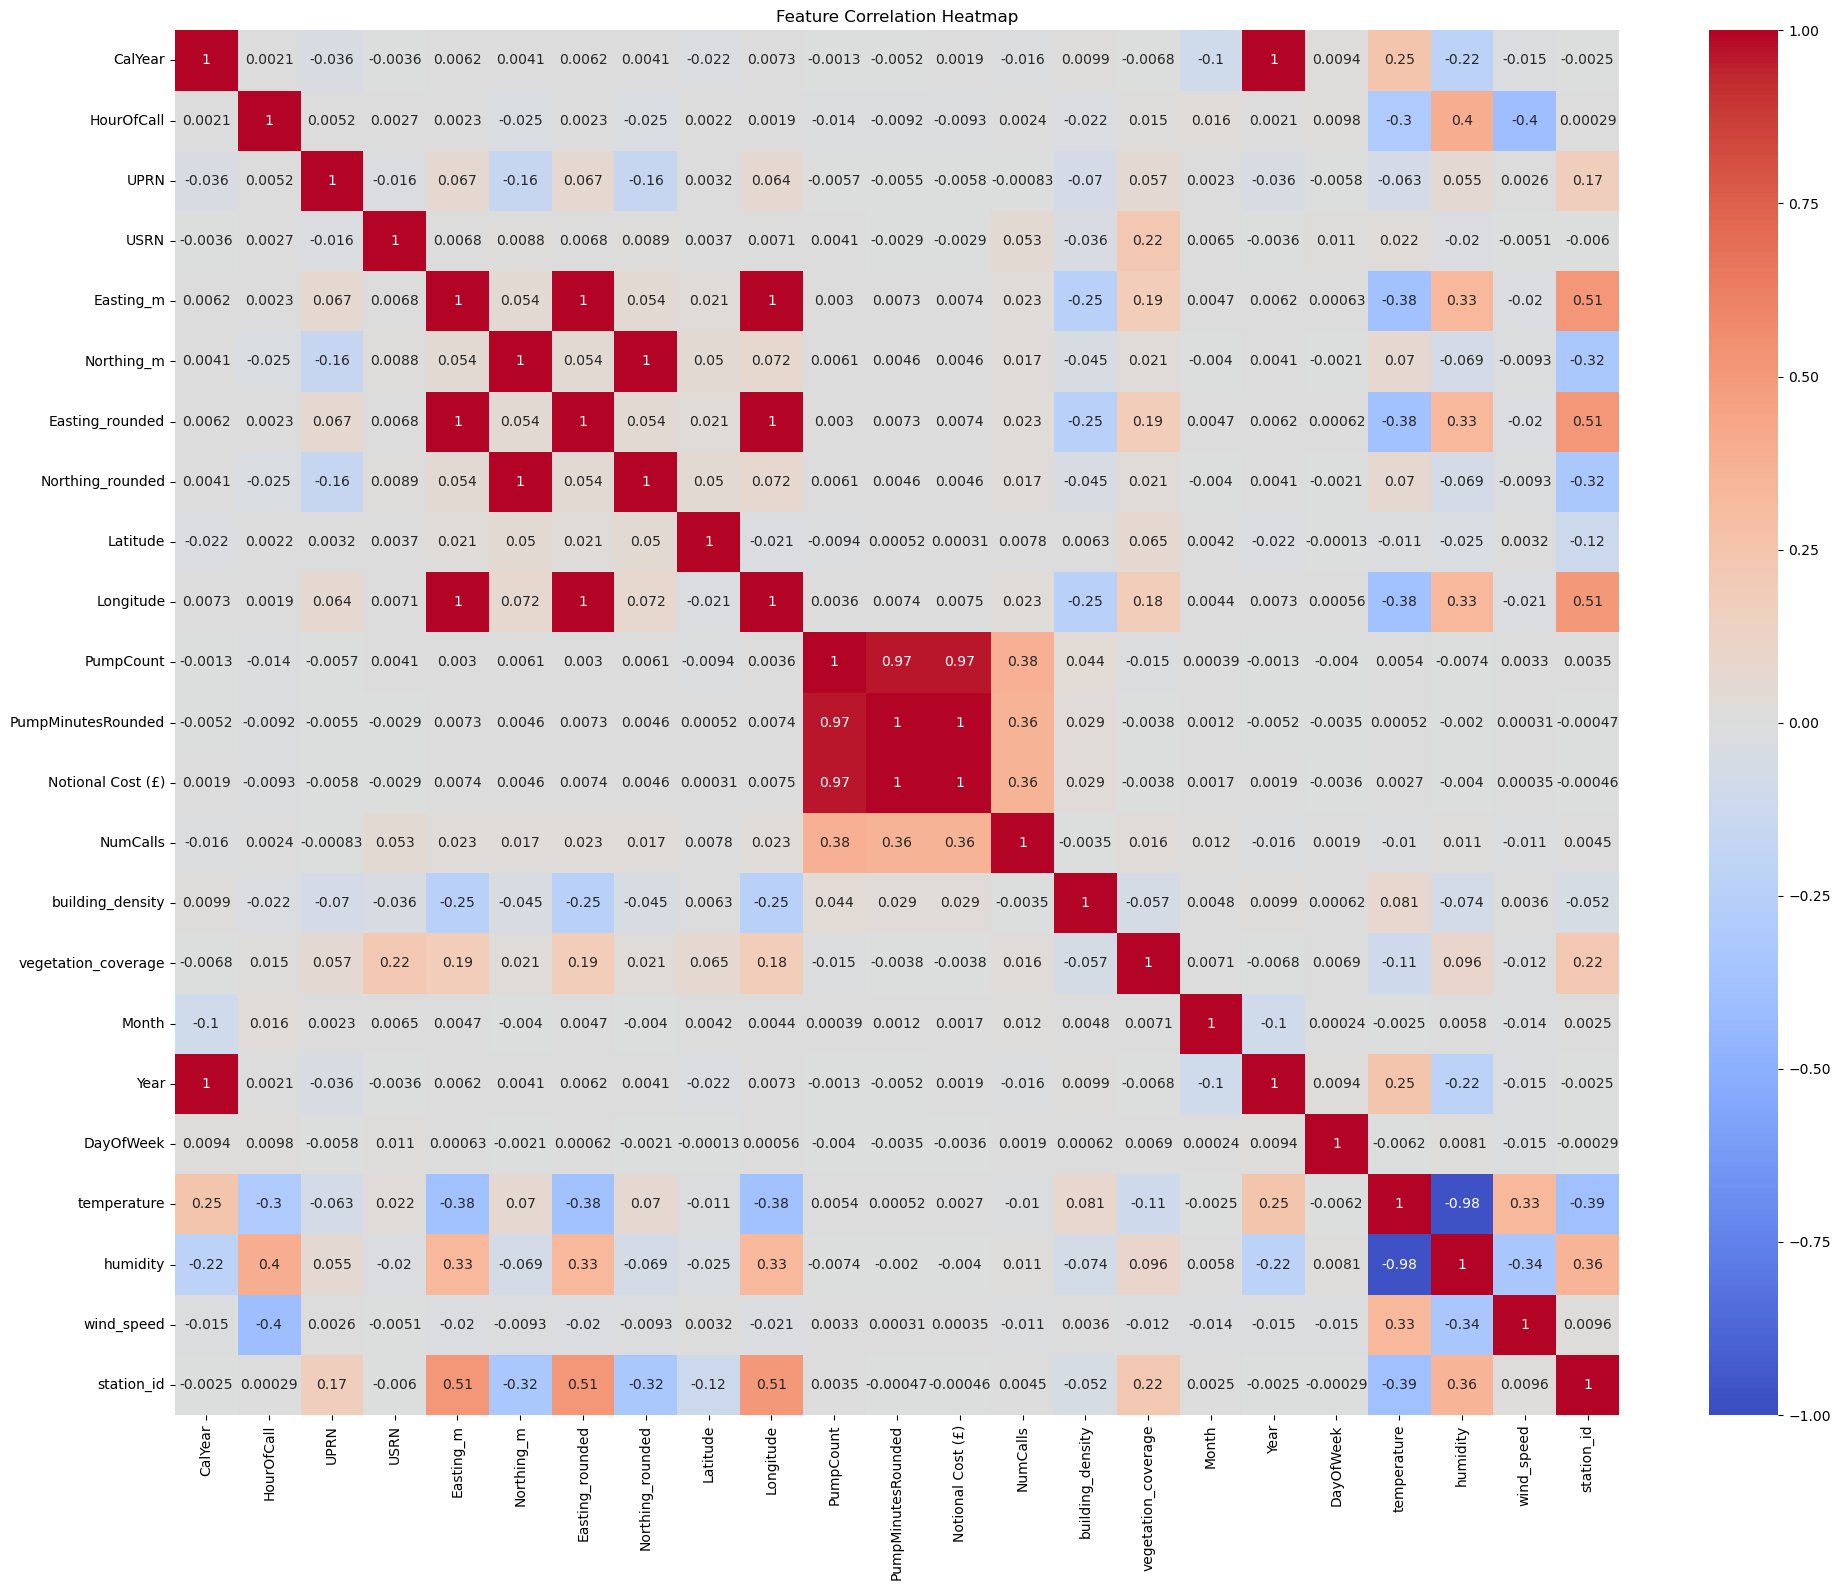


Most correlated feature pairs:
Longitude           Easting_rounded       0.998373
Easting_rounded     Longitude             0.998373
Easting_m           Longitude             0.998375
Longitude           Easting_m             0.998375
Notional Cost (£)   PumpMinutesRounded    0.998674
PumpMinutesRounded  Notional Cost (£)     0.998674
Northing_rounded    Northing_m            0.999993
Northing_m          Northing_rounded      0.999993
Easting_m           Easting_rounded       0.999997
Easting_rounded     Easting_m             0.999997
dtype: float64


In [8]:
# Select numerical columns for correlation analysis
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Calculate correlation matrix
corr_matrix = df[numeric_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Print the most correlated pairs
print("\nMost correlated feature pairs:")
corr_pairs = corr_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
print(sorted_pairs[(sorted_pairs > 0.5) & (sorted_pairs < 1)].tail(10))

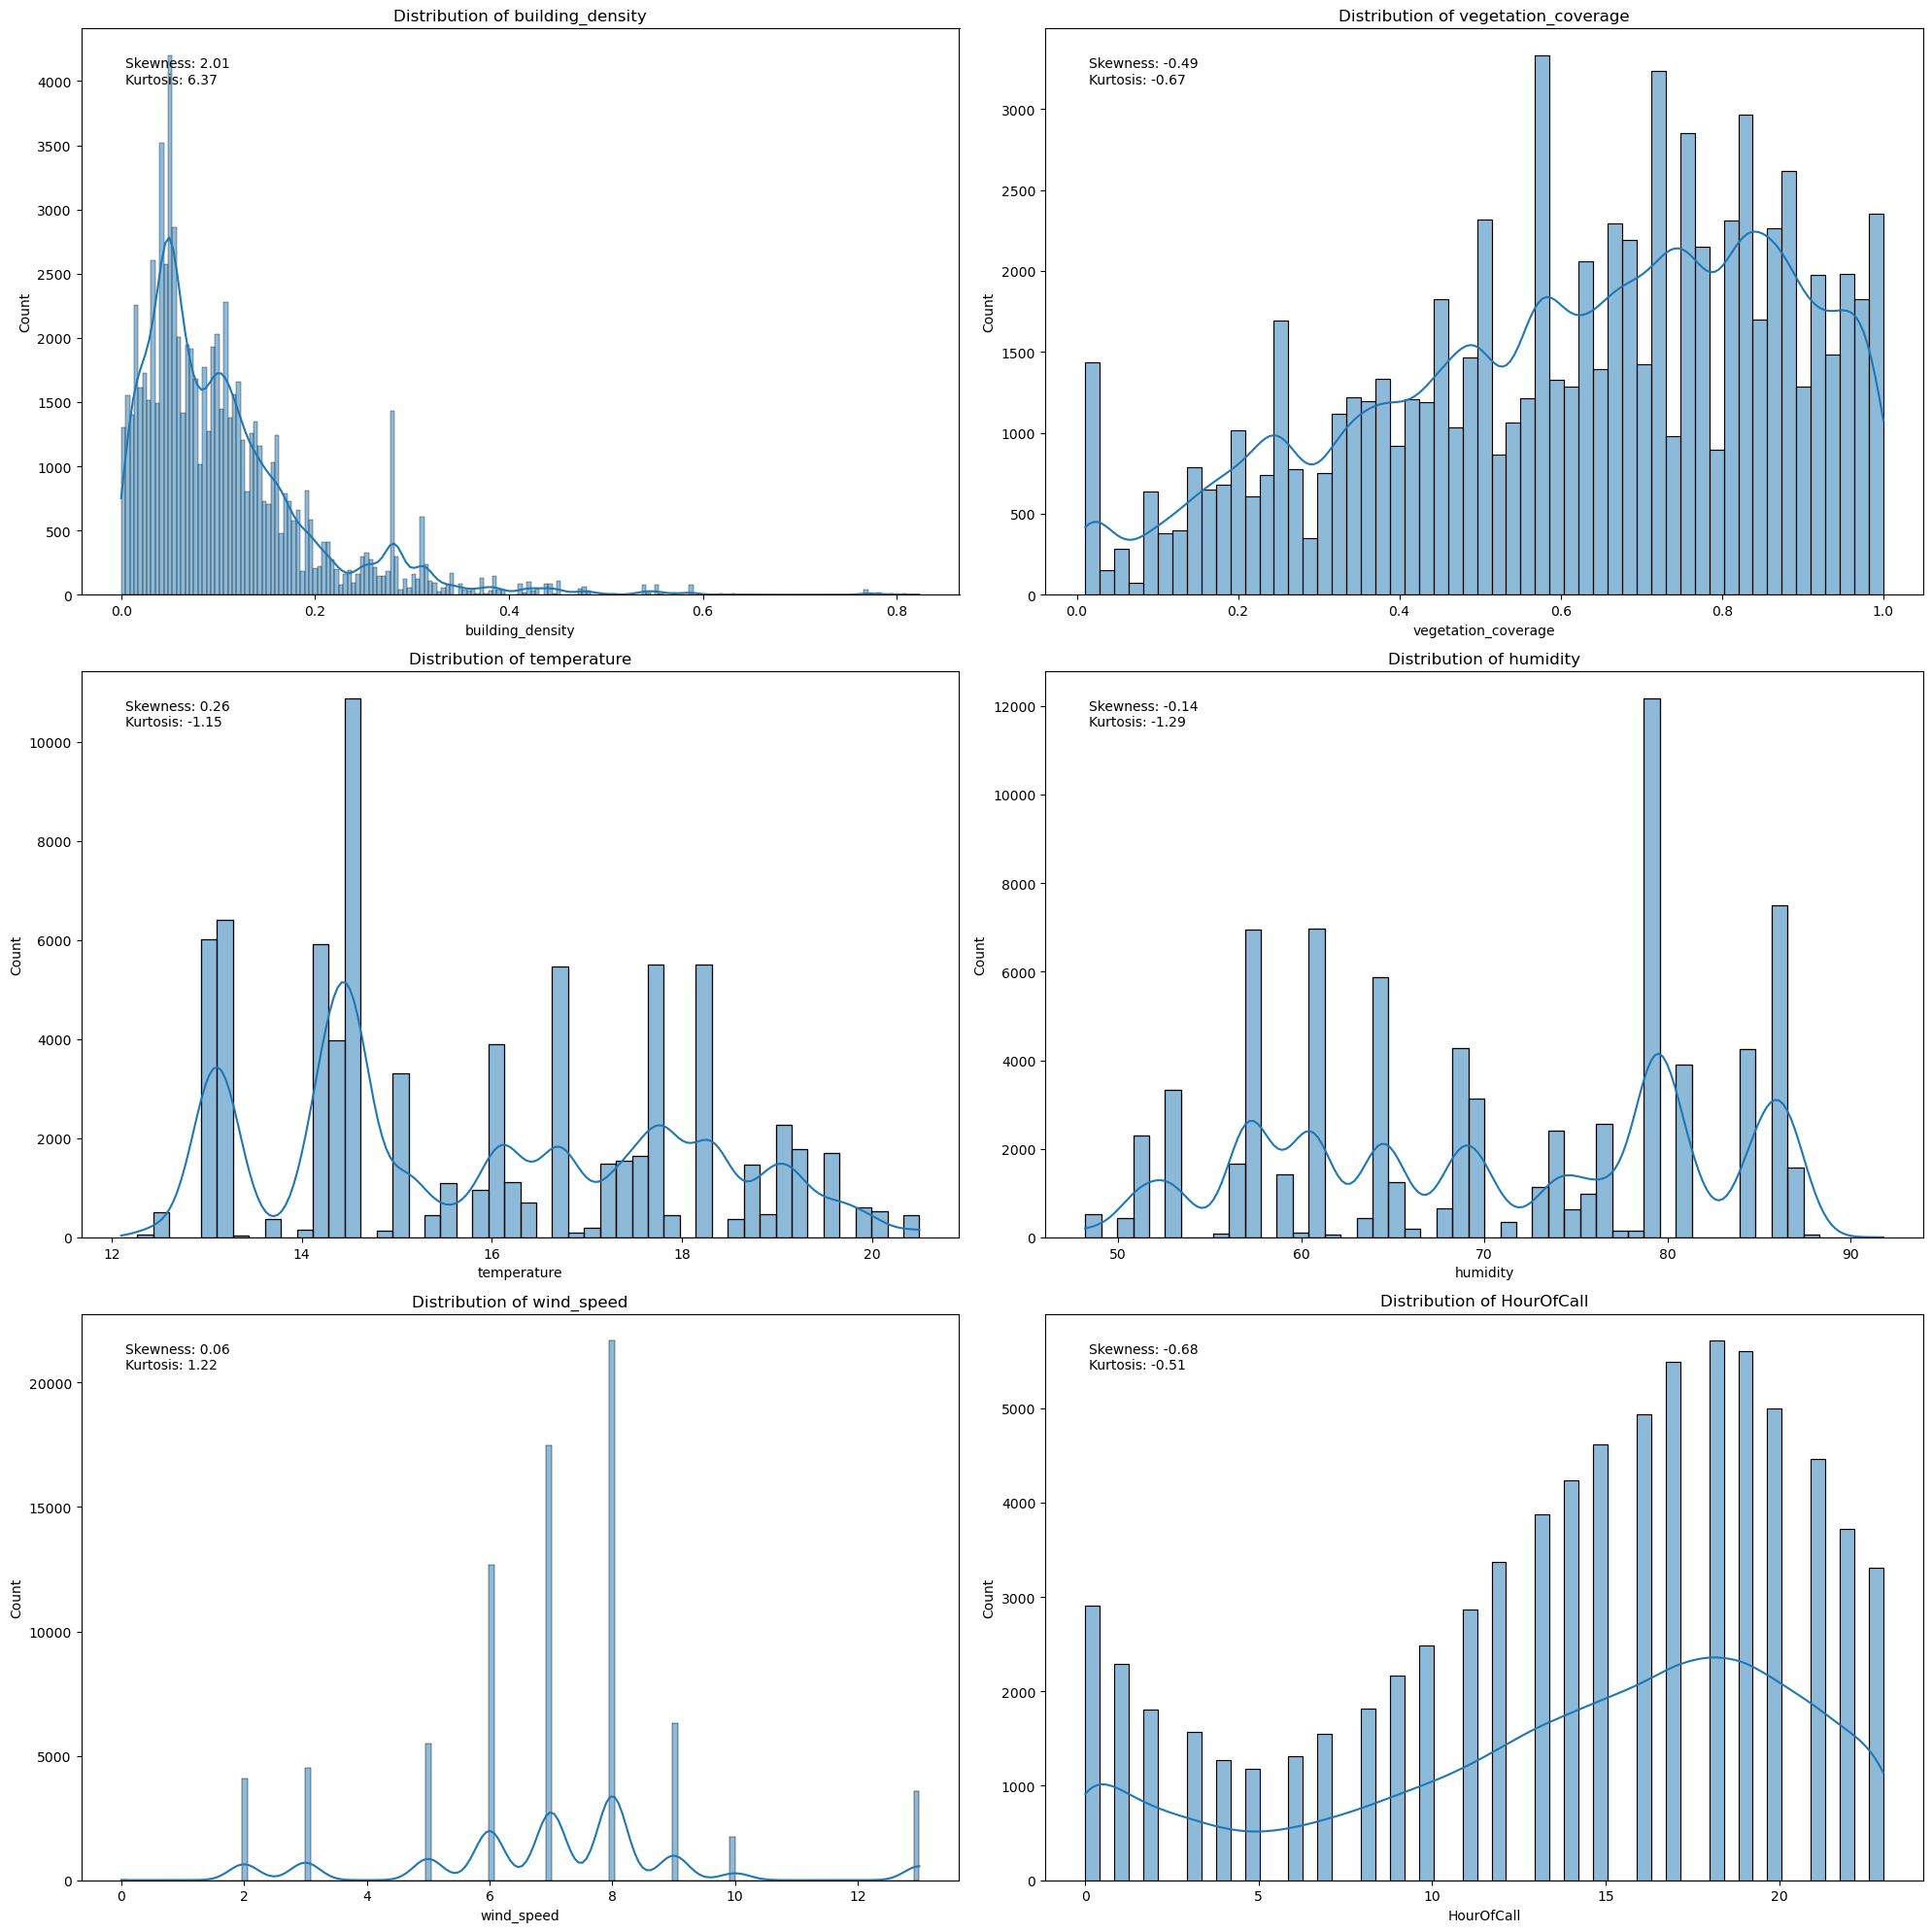

In [14]:
# Select important features for visualization
important_features = ['building_density', 'vegetation_coverage', 'temperature', 
                      'humidity', 'wind_speed','HourOfCall']

# Create distribution plots
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
axes = axes.flatten()

for i, feature in enumerate(important_features):
    sns.histplot(df[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    
    # Add skewness and kurtosis information
    skewness = stats.skew(df[feature])
    kurtosis = stats.kurtosis(df[feature])
    axes[i].text(0.05, 0.95, f'Skewness: {skewness:.2f}\nKurtosis: {kurtosis:.2f}', 
                 transform=axes[i].transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

In [15]:
import pandas as pd
import numpy as np
from scipy import stats

# Load data
df = pd.read_excel('London_Fire_Events_Processed.xlsx')
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'])

# 1. Correlation Analysis
numeric_columns = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_columns].corr()
corr_pairs = corr_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
print("Most correlated feature pairs:")
print(sorted_pairs[(sorted_pairs > 0.5) & (sorted_pairs < 1)].tail(10))

# 2. Feature Distribution
important_features = ['building_density', 'vegetation_coverage', 'temperature', 
                      'humidity', 'wind_speed', 'PumpCount', 'PumpMinutesRounded']

print("\nFeature distribution statistics:")
for feature in important_features:
    skewness = stats.skew(df[feature])
    kurtosis = stats.kurtosis(df[feature])
    print(f"{feature}:")
    print(f"  Skewness: {skewness:.2f}")
    print(f"  Kurtosis: {kurtosis:.2f}")
    print(f"  Min: {df[feature].min():.2f}")
    print(f"  Max: {df[feature].max():.2f}")
    print(f"  Mean: {df[feature].mean():.2f}")
    print(f"  Median: {df[feature].median():.2f}")

# 3. Time Trend Analysis
print("\nMonthly fire incident statistics:")
monthly_incidents = df.groupby(df['DateOfCall'].dt.month)['IncidentNumber'].count()
print(monthly_incidents)

print("\nHourly fire incident statistics:")
hourly_incidents = df.groupby('HourOfCall')['IncidentNumber'].count()
print(hourly_incidents)

# 4. Geographic Distribution
print("\nGeographic distribution statistics:")
print(f"Latitude  - Min: {df['Latitude'].min():.4f}, Max: {df['Latitude'].max():.4f}")
print(f"Longitude - Min: {df['Longitude'].min():.4f}, Max: {df['Longitude'].max():.4f}")

# Calculate the areas with the highest incident density
df['lat_rounded'] = df['Latitude'].round(2)
df['lon_rounded'] = df['Longitude'].round(2)
location_counts = df.groupby(['lat_rounded', 'lon_rounded']).size().sort_values(ascending=False)

print("\nTop 5 areas with the highest incident density:")
print(location_counts.head())


Most correlated feature pairs:
Longitude           Easting_rounded       0.998373
Easting_rounded     Longitude             0.998373
Easting_m           Longitude             0.998375
Longitude           Easting_m             0.998375
Notional Cost (£)   PumpMinutesRounded    0.998674
PumpMinutesRounded  Notional Cost (£)     0.998674
Northing_rounded    Northing_m            0.999993
Northing_m          Northing_rounded      0.999993
Easting_m           Easting_rounded       0.999997
Easting_rounded     Easting_m             0.999997
dtype: float64

Feature distribution statistics:
building_density:
  Skewness: 2.01
  Kurtosis: 6.37
  Min: 0.00
  Max: 0.82
  Mean: 0.11
  Median: 0.08
vegetation_coverage:
  Skewness: -0.49
  Kurtosis: -0.67
  Min: 0.01
  Max: 1.00
  Mean: 0.62
  Median: 0.66
temperature:
  Skewness: 0.26
  Kurtosis: -1.15
  Min: 12.10
  Max: 20.50
  Mean: 15.88
  Median: 15.60
humidity:
  Skewness: -0.14
  Kurtosis: -1.29
  Min: 48.20
  Max: 91.80
  Mean: 70.61
  Media

1. Which features show strong correlations? Are these correlations as expected?

   - Strong positive correlations exist between Longitude and Easting (both rounded and in meters), with correlation coefficients around 0.998.
   - Northing_rounded and Northing_m are highly correlated (0.999993).
   - PumpMinutesRounded and Notional Cost (£) show a strong positive correlation (0.998674).

   These correlations are generally expected:
   - Longitude and Easting are related geographic coordinates.
   - Different versions of Northing (rounded and in meters) are naturally highly correlated.
   - The strong correlation between PumpMinutesRounded and Notional Cost suggests that longer response times are associated with higher costs.

2. Are there noticeable skews or outliers in the feature distributions?

   - building_density: Positively skewed (2.01) with high kurtosis (6.37), indicating a right-tailed distribution with many extreme values.
   - vegetation_coverage: Slightly negatively skewed (-0.49), relatively uniform distribution.
   - temperature and humidity: Relatively normal distributions, with skewness close to 0.
   - wind_speed: Fairly normal distribution with a slight positive skew.
   - PumpCount and PumpMinutesRounded: Severely right-skewed (35.18 and 45.00 respectively) with extremely high kurtosis, indicating many outliers or extreme cases.

3. Are there clear seasonal or daily patterns in fire incidents?

   Seasonal pattern:
   - Summer (especially July) has the most incidents, while winter (especially December) has the least.
   - July (10,056 incidents) has about 2.6 times more incidents than December (3,867).

   Daily pattern:
   - Afternoon to evening (15:00-19:00) is the peak period, with the highest at 18:00 (5,712 incidents).
   - Early morning (3:00-6:00) has the fewest incidents, with the lowest at 5:00 (1,180 incidents).

4. Is the geographical distribution of fire incidents concentrated in specific areas?

   - Incidents are mainly concentrated between latitudes 51.51 to 51.52 and longitudes -0.14 to -0.12.
   - The highest density area (latitude 51.51, longitude -0.13) has 552 incidents, likely central London.
   - The top five high-density areas are very close, indicating a clear geographical concentration of fire incidents.

These findings are valuable for your fire risk assessment and emergency response planning project. They reveal spatiotemporal patterns of fire incidents and relationships with factors like pump usage time. This information can be used to optimize resource allocation, improve predictive models, and develop more targeted prevention strategies.

Next steps to consider:
1. Further analyze PumpCount and PumpMinutesRounded to understand the causes of extreme values.
2. Investigate reasons for increased summer fire incidents, possibly related to weather conditions.
3. Analyze characteristics of high-density fire areas, such as building density and land use types.
4. Consider incorporating temporal and geographical factors into your predictive model.



In [16]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_excel('London_Fire_Events_Processed.xlsx')
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'])

# 1. Analysis of PumpCount and PumpMinutesRounded
print("PumpCount statistics:")
print(df['PumpCount'].describe())
print("\nPumpMinutesRounded statistics:")
print(df['PumpMinutesRounded'].describe())
print("\nTop 5 incidents by PumpCount:")
print(df.nlargest(5, 'PumpCount')[['IncidentNumber', 'PumpCount', 'PumpMinutesRounded', 'Notional Cost (£)']])

# 2. Seasonal analysis
df['Month'] = df['DateOfCall'].dt.month
df['Season'] = pd.cut(df['Month'], bins=[0, 3, 6, 9, 12], labels=['Winter', 'Spring', 'Summer', 'Autumn'])
seasonal_stats = df.groupby('Season').agg({
    'IncidentNumber': 'count',
    'temperature': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean'
}).rename(columns={'IncidentNumber': 'Incident_Count'})
print("\nSeasonal statistics:")
print(seasonal_stats)

# 3. High-density area analysis
df['lat_rounded'] = df['Latitude'].round(2)
df['lon_rounded'] = df['Longitude'].round(2)
high_density_areas = df.groupby(['lat_rounded', 'lon_rounded']).agg({
    'IncidentNumber': 'count',
    'building_density': 'mean',
    'vegetation_coverage': 'mean'
}).sort_values('IncidentNumber', ascending=False).head(5)
print("\nTop 5 high-density areas characteristics:")
print(high_density_areas)

# 4. Correlation between environmental factors and incident frequency
df['Date'] = df['DateOfCall'].dt.date
daily_data = df.groupby('Date').agg({
    'IncidentNumber': 'count',
    'temperature': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean'
}).rename(columns={'IncidentNumber': 'Incident_Count'})
correlations = daily_data.corr()['Incident_Count'].drop('Incident_Count')
print("\nCorrelations between daily incident count and environmental factors:")
print(correlations)

PumpCount statistics:
count    77551.000000
mean         1.575144
std          3.239839
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        250.000000
Name: PumpCount, dtype: float64

PumpMinutesRounded statistics:
count    77551.000000
mean       118.530386
std        857.497235
min         60.000000
25%         60.000000
50%         60.000000
75%         60.000000
max      72157.000000
Name: PumpMinutesRounded, dtype: float64

Top 5 incidents by PumpCount:
        IncidentNumber  PumpCount  PumpMinutesRounded  Notional Cost (£)
20779  086232-05072019        250               72157             407687
7478   096730-15072018        209               66113             366927
1154   018108-12022018        198               59001             322539
5583   080303-23062018        197               57433             318753
71205  137654-08092023        187               52685             340696

Seasonal statistics:
        Incident_Count  temper

1. PumpCount and PumpMinutesRounded Analysis:

   - PumpCount: The median (50th percentile) is 1, indicating that most incidents require only one pump. However, the maximum of 250 pumps suggests some extremely large-scale incidents.
   - PumpMinutesRounded: Similar to PumpCount, the median is 60 minutes, but there's a maximum of 72,157 minutes (about 50 days), indicating some very long-lasting incidents.
   - The top 5 incidents by PumpCount are extreme cases, with the largest involving 250 pumps for over 72,000 minutes (about 50 days), costing £407,687. These are likely major disasters or complex, long-lasting incidents.

2. Seasonal Analysis:

   - Summer has the highest number of incidents (24,523), followed closely by Spring (22,995). Winter has the fewest incidents (16,334).
   - Interestingly, the average temperature doesn't vary much across seasons (range: 15.83°C to 15.92°C), which is unexpected and might need further investigation.
   - Humidity and wind speed also show little variation across seasons.

3. High-density Area Analysis:

   - The top 5 high-density areas are all very close geographically (latitude 51.51-51.52, longitude -0.14 to -0.12).
   - The area with the most incidents (552) has the highest building density (0.162) and a relatively high vegetation coverage (0.399).
   - There seems to be a pattern of higher incident rates in areas with higher building density.

4. Correlation between Environmental Factors and Incident Frequency:

   - Surprisingly, the correlations are quite weak:
     - Temperature: -0.061 (slight negative correlation)
     - Humidity: 0.092 (slight positive correlation)
     - Wind speed: 0.005 (negligible correlation)

   This suggests that daily environmental factors might not be strong predictors of fire incident frequency on their own.

Implications and Next Steps:

1. Resource Allocation: Given the wide range of PumpCount and PumpMinutesRounded, consider developing a tiered response system based on initial incident assessment.

2. Seasonal Preparedness: Despite the relatively even temperature distribution, there's a clear seasonal pattern in incident frequency. Investigate other factors that might contribute to higher summer incidents (e.g., human behavior, specific weather patterns).

3. Geographical Focus: Concentrate on high-density areas for preventive measures. Analyze the characteristics of these areas (e.g., building types, population density) to understand why they're more prone to incidents.

4. Predictive Modeling: While daily environmental factors show weak correlations, consider:
   - Analyzing lagged effects (e.g., cumulative heat over several days)
   - Incorporating non-environmental factors (e.g., day of week, public events)
   - Investigating interaction effects between variables

5. Extreme Incidents: Conduct case studies on the top 5 incidents by PumpCount to understand the nature of these extreme events and how to prepare for them.

6. Data Quality Check: The lack of seasonal temperature variation is unexpected. Verify the accuracy of the temperature data and its collection methodology.

To proceed, you might want to:
1. Visualize the geographical distribution of incidents on a map.
2. Analyze the types of incidents in high-density areas.
3. Investigate the relationship between building density and incident frequency more closely.
4. Examine the time series of incidents to identify any long-term trends or cycles.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the data
df = pd.read_excel('London_Fire_Events_Processed.xlsx')
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'])

# 1. Analyze the relationship between building density and incident frequency
df['building_density_bin'] = pd.cut(df['building_density'], bins=10)
building_density_incidents = df.groupby('building_density_bin')['IncidentNumber'].count().reset_index()
building_density_incidents['building_density'] = building_density_incidents['building_density_bin'].apply(lambda x: x.mid)

print("Correlation between building density and incident frequency:")
print(stats.pearsonr(building_density_incidents['building_density'], building_density_incidents['IncidentNumber']))

# 2. Analyze types of incidents in high-density areas
high_density_df = df[df['building_density'] > df['building_density'].quantile(0.9)]
incident_types = high_density_df['IncidentGroup'].value_counts()

print("\nTop 5 incident types in high-density areas:")
print(incident_types.head())

# 3. Time series analysis of incidents
df['Date'] = df['DateOfCall'].dt.date
daily_incidents = df.groupby('Date')['IncidentNumber'].count().reset_index()
daily_incidents.set_index('Date', inplace=True)

# Calculate moving average
daily_incidents['MA7'] = daily_incidents['IncidentNumber'].rolling(window=7).mean()
daily_incidents['MA30'] = daily_incidents['IncidentNumber'].rolling(window=30).mean()

print("\nTime series statistics:")
print(daily_incidents['IncidentNumber'].describe())

# 4. Day of week analysis
df['DayOfWeek'] = df['DateOfCall'].dt.dayofweek
day_of_week_incidents = df.groupby('DayOfWeek')['IncidentNumber'].count()

print("\nIncidents by day of week:")
print(day_of_week_incidents)

# 5. Analyze the relationship between vegetation coverage and incident frequency
df['vegetation_coverage_bin'] = pd.cut(df['vegetation_coverage'], bins=10)
vegetation_coverage_incidents = df.groupby('vegetation_coverage_bin')['IncidentNumber'].count().reset_index()
vegetation_coverage_incidents['vegetation_coverage'] = vegetation_coverage_incidents['vegetation_coverage_bin'].apply(lambda x: x.mid)

print("\nCorrelation between vegetation coverage and incident frequency:")
print(stats.pearsonr(vegetation_coverage_incidents['vegetation_coverage'], vegetation_coverage_incidents['IncidentNumber']))

# 6. Analyze the relationship between PumpCount and incident types
pump_count_by_type = df.groupby('IncidentGroup')['PumpCount'].mean().sort_values(ascending=False)

print("\nAverage PumpCount by incident type (top 5):")
print(pump_count_by_type.head())

Correlation between building density and incident frequency:
PearsonRResult(statistic=-0.7894205741846044, pvalue=0.006613944906436526)

Top 5 incident types in high-density areas:
IncidentGroup
Fire    7749
Name: count, dtype: int64

Time series statistics:
count    2312.000000
mean       33.542820
std        18.012734
min         6.000000
25%        22.000000
50%        29.000000
75%        40.000000
max       133.000000
Name: IncidentNumber, dtype: float64

Incidents by day of week:
DayOfWeek
0    11352
1    10797
2    10627
3    10685
4    11071
5    11525
6    11494
Name: IncidentNumber, dtype: int64

Correlation between vegetation coverage and incident frequency:
PearsonRResult(statistic=0.9617435930845649, pvalue=8.947801020327155e-06)

Average PumpCount by incident type (top 5):
IncidentGroup
Fire    1.575144
Name: PumpCount, dtype: float64


In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_excel('London_Fire_Events_Processed.xlsx')
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'])

print("Columns in the dataset:")
print(df.columns)
print("\nData types of columns:")
print(df.dtypes)

# Identify numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
print("\nNumeric columns:")
print(numeric_columns)

# Function to remove highly correlated features
def remove_correlated_features(df, threshold=0.95):
    corr_matrix = df[numeric_columns].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print(f"Dropping highly correlated features: {to_drop}")
    return df.drop(to_drop, axis=1)

# Remove highly correlated features
df = remove_correlated_features(df)

# Handle outliers
def handle_outliers(df, columns, method='clip'):
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            if method == 'clip':
                df[col] = df[col].clip(lower_bound, upper_bound)
            elif method == 'remove':
                df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        else:
            print(f"Column {col} not found in the dataset. Skipping...")
    
    return df

# Handle outliers in PumpCount
df = handle_outliers(df, ['PumpCount'], method='clip')

print("\nOutliers handled")
print("\nPumpCount statistics:")
print(df['PumpCount'].describe())

# Create new features
df['Hour'] = df['DateOfCall'].dt.hour
df['DayOfWeek'] = df['DateOfCall'].dt.dayofweek
df['Month'] = df['DateOfCall'].dt.month
df['Season'] = pd.cut(df['Month'], bins=[0, 3, 6, 9, 12], labels=['Winter', 'Spring', 'Summer', 'Autumn'])

if 'Latitude' in df.columns:
    df['lat_rounded'] = df['Latitude'].round(2)
    print("\nLatitude rounded")
else:
    print("\nLatitude column not found")

if 'building_density' in df.columns and 'vegetation_coverage' in df.columns:
    df['BuildingDensityVegetation'] = df['building_density'] * df['vegetation_coverage']
    print("\nBuildingDensityVegetation calculated")
else:
    print("\nUnable to calculate BuildingDensityVegetation due to missing columns")

if 'temperature' in df.columns and 'humidity' in df.columns:
    df['TemperatureHumidity'] = df['temperature'] * df['humidity']
    print("\nTemperatureHumidity calculated")
else:
    print("\nUnable to calculate TemperatureHumidity due to missing columns")

print("\nNew features created")
print(df.columns)

# Standardize numerical features
numeric_columns = df.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

print("\nNumerical features standardized")

# Encode categorical features
categorical_features = [col for col in ['IncidentGroup', 'StopCodeDescription', 'PropertyCategory', 'Season'] if col in df.columns]
df_encoded = pd.get_dummies(df, columns=categorical_features)

print("\nCategorical features encoded")
print(df_encoded.shape)

# Final check for any remaining NaN values
print("\nRemaining NaN values:")
print(df_encoded.isna().sum())

# Save the processed data
df_encoded.to_excel('London_Fire_Events_Processed_Final.xlsx', index=False)
print("\nProcessed data saved to 'London_Fire_Events_Processed_Final.xlsx'")

Columns in the dataset:
Index(['IncidentNumber', 'DateOfCall', 'CalYear', 'TimeOfCall', 'HourOfCall',
       'IncidentGroup', 'StopCodeDescription', 'PropertyCategory',
       'PropertyType', 'AddressQualifier', 'Postcode_full',
       'Postcode_district', 'UPRN', 'USRN', 'IncGeo_BoroughCode',
       'IncGeo_BoroughName', 'ProperCase', 'Easting_m', 'Northing_m',
       'Easting_rounded', 'Northing_rounded', 'Latitude', 'Longitude', 'FRS',
       'IncidentStationGround', 'PumpCount', 'PumpMinutesRounded',
       'Notional Cost (£)', 'NumCalls', 'building_density',
       'vegetation_coverage', 'Month', 'Year', 'DayOfWeek', 'geometry',
       'landuse', 'temperature', 'humidity', 'wind_speed', 'station_id',
       'station_name'],
      dtype='object')

Data types of columns:
IncidentNumber                   object
DateOfCall               datetime64[ns]
CalYear                           int64
TimeOfCall                       object
HourOfCall                        int64
IncidentGroup  

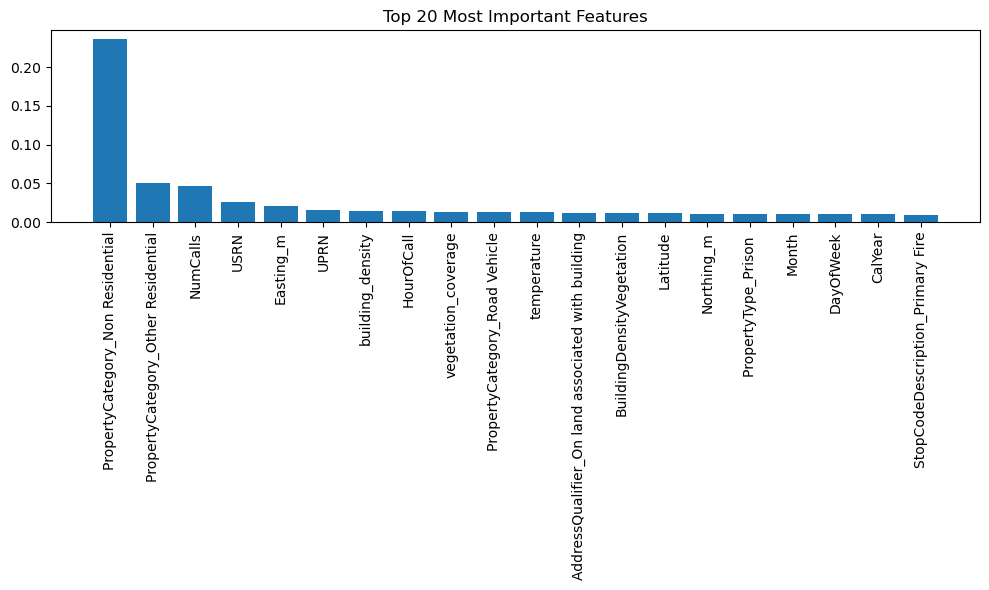

                                               feature  importance
25                    PropertyCategory_Non Residential    0.235528
26                  PropertyCategory_Other Residential    0.050774
7                                             NumCalls    0.047087
3                                                 USRN    0.026478
4                                            Easting_m    0.021152
2                                                 UPRN    0.016106
8                                     building_density    0.014228
1                                           HourOfCall    0.013798
9                                  vegetation_coverage    0.013578
30                       PropertyCategory_Road Vehicle    0.012812
12                                         temperature    0.012346
280  AddressQualifier_On land associated with building    0.012082
17                           BuildingDensityVegetation    0.011365
6                                             Latitude    0.01

In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the data
df = pd.read_excel('London_Fire_Events_Processed_Final.xlsx')

# Select features and target variable
# Note: We assume that 'PumpCount' is the target variable. Adjust based on your actual use case.
features = df.drop(['IncidentNumber', 'DateOfCall', 'TimeOfCall', 'geometry', 'PumpCount'], axis=1)
target = df['PumpCount']

# Perform one-hot encoding for categorical variables
features_encoded = pd.get_dummies(features)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.2, random_state=42)

# Train the random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.xticks(rotation=90)
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

# Print the top 20 most important features
print(feature_importance.head(20))


/var/folders/c7/kb9rb69966j3v_4115qt2zxh0000gn/T/ipykernel_46574/2962412125.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(risk_importance['feature'][:15], rotation=45, ha='right')
/var/folders/c7/kb9rb69966j3v_4115qt2zxh0000gn/T/ipykernel_46574/2962412125.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(response_importance['feature'][:15], rotation=45, ha='right')


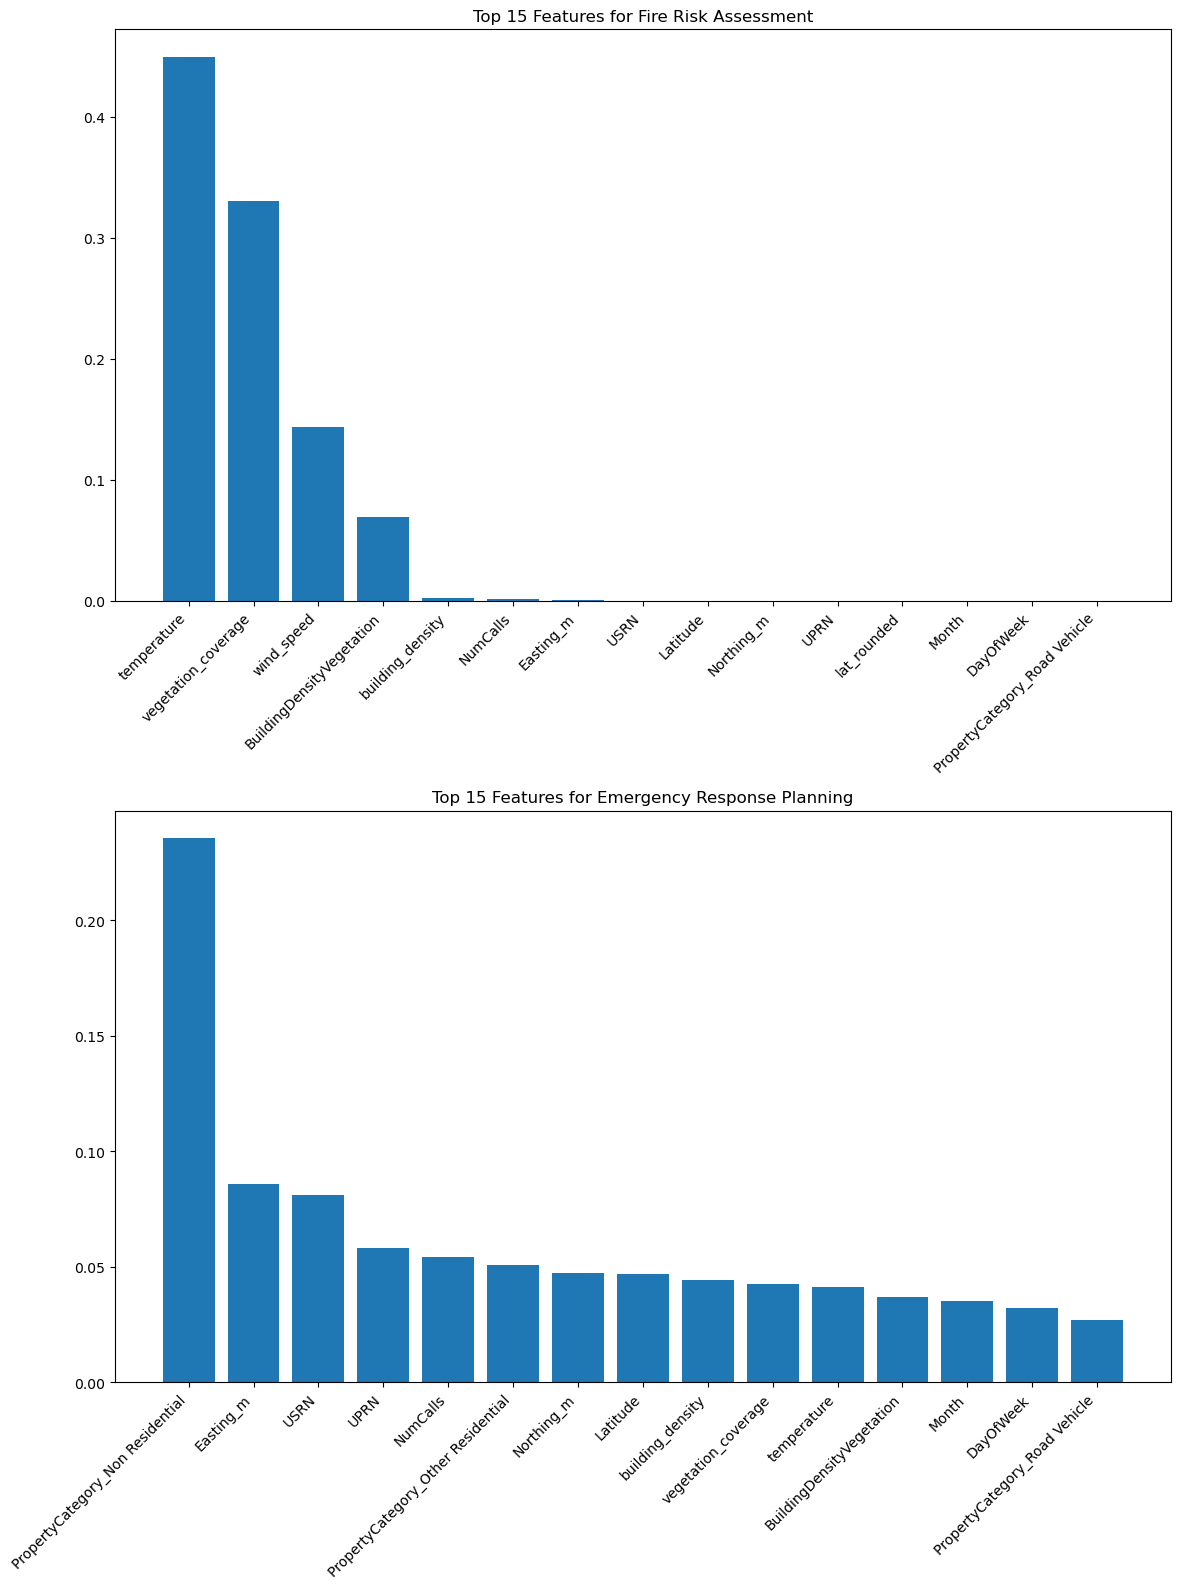

Top features for Fire Risk Assessment:
                          feature  importance
2                     temperature    0.449591
1             vegetation_coverage    0.330418
3                      wind_speed    0.143936
12      BuildingDensityVegetation    0.069357
0                building_density    0.002745
11                       NumCalls    0.001860
5                       Easting_m    0.000773
7                            USRN    0.000301
4                        Latitude    0.000245
6                      Northing_m    0.000242
8                            UPRN    0.000152
13                    lat_rounded    0.000107
9                           Month    0.000074
10                      DayOfWeek    0.000057
25  PropertyCategory_Road Vehicle    0.000021

Top features for Emergency Response Planning:
                               feature  importance
20    PropertyCategory_Non Residential    0.235528
5                            Easting_m    0.085827
7                        

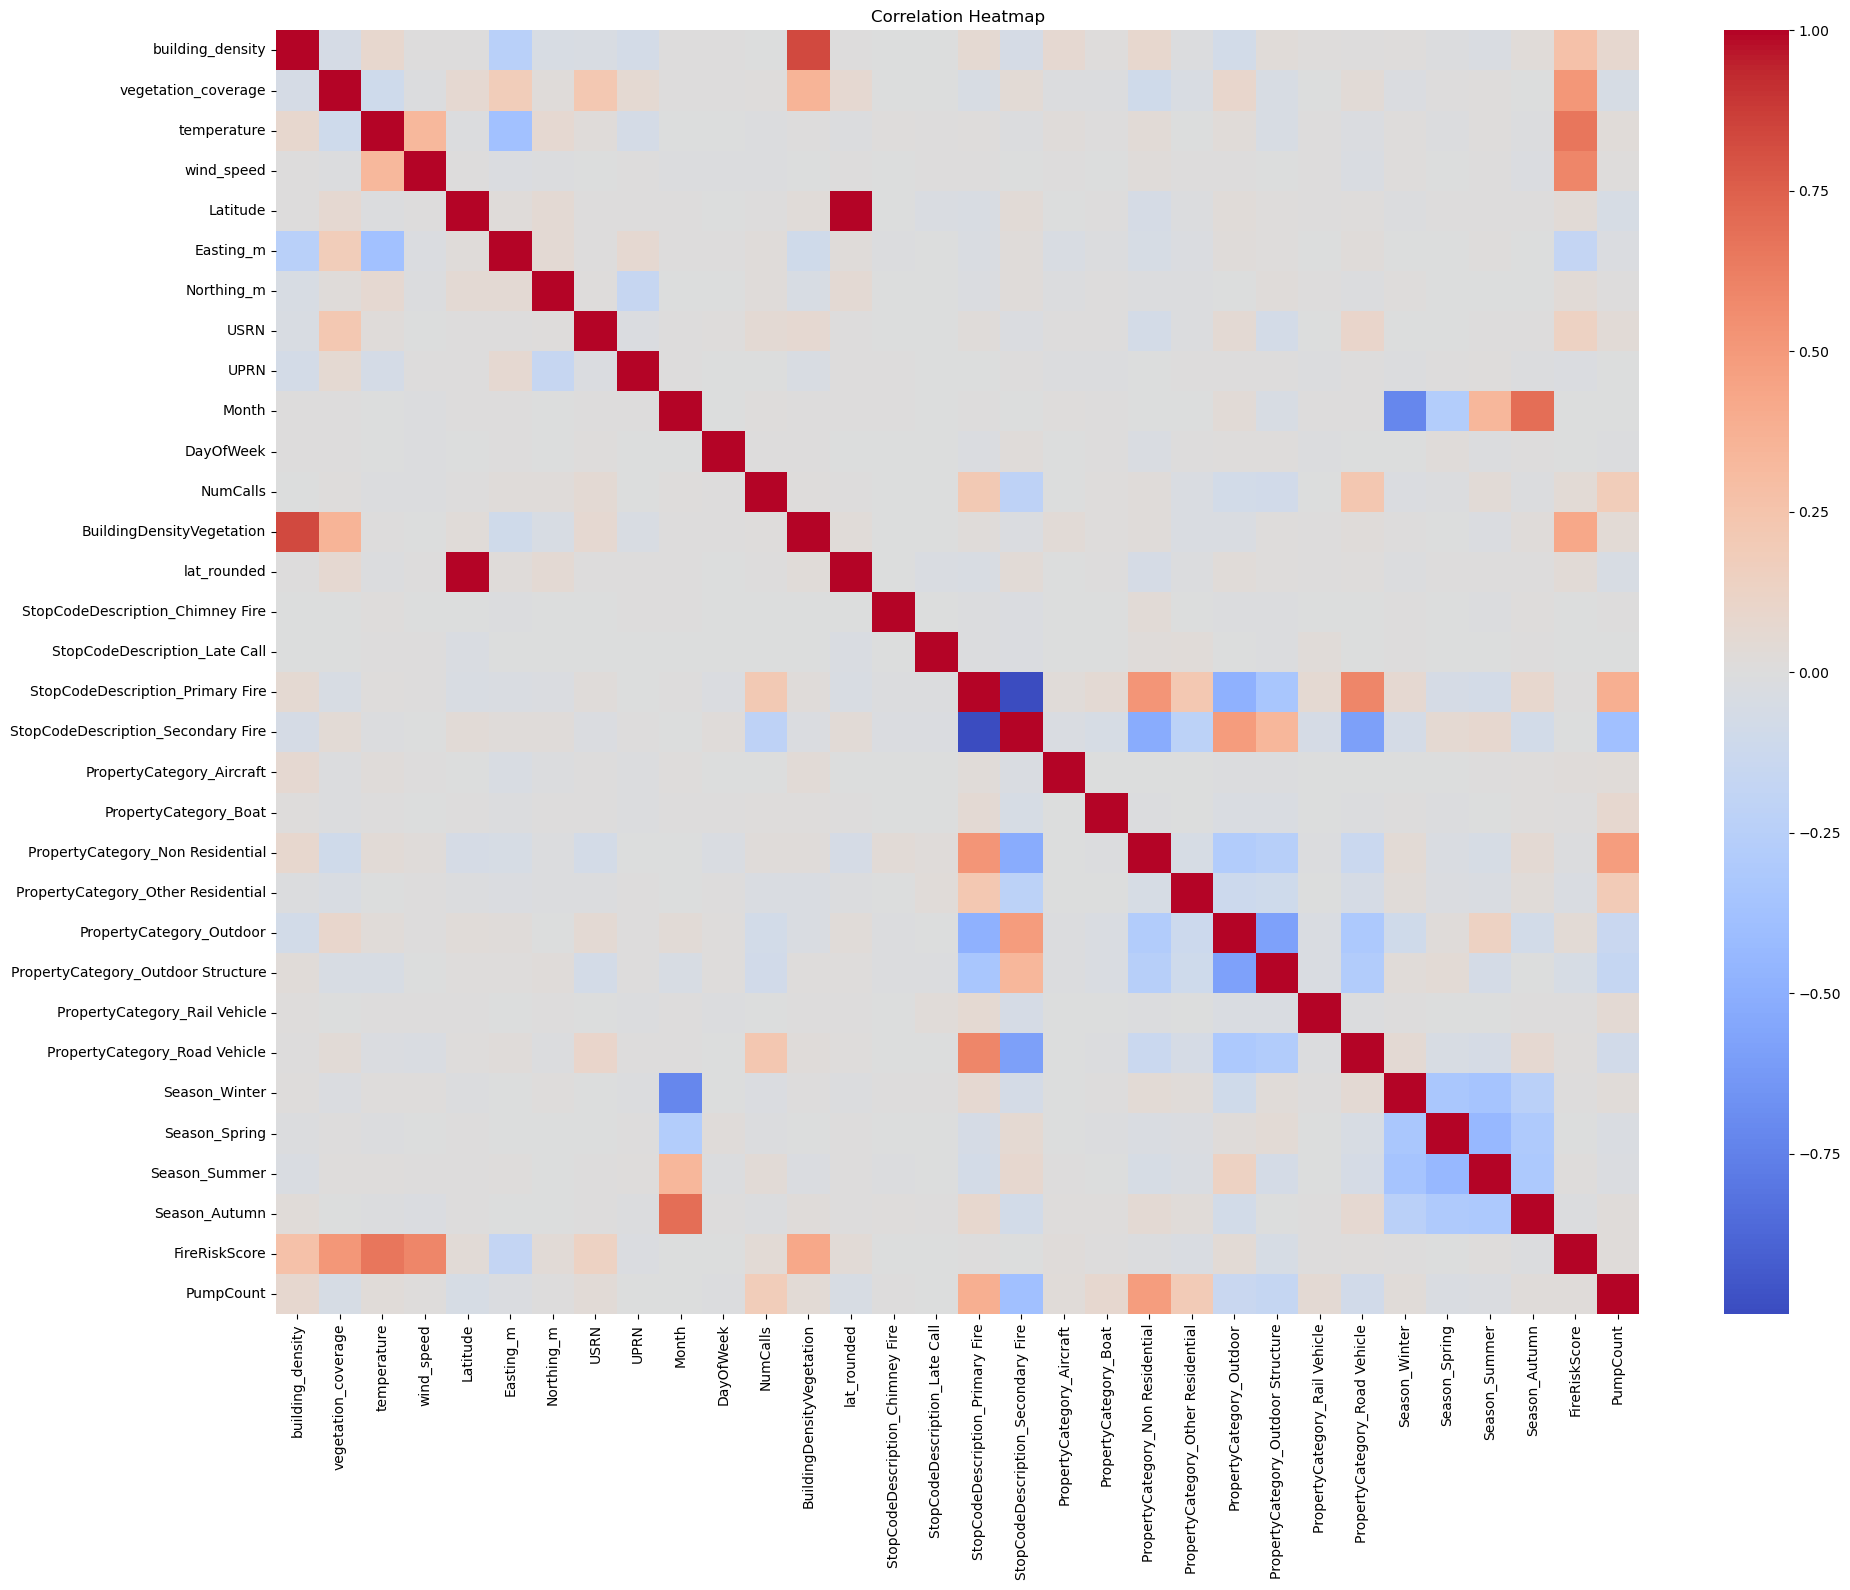

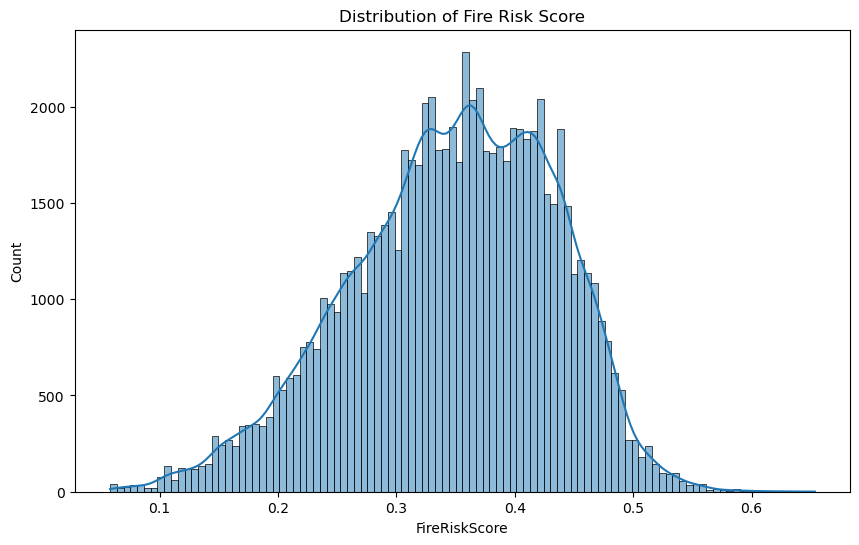

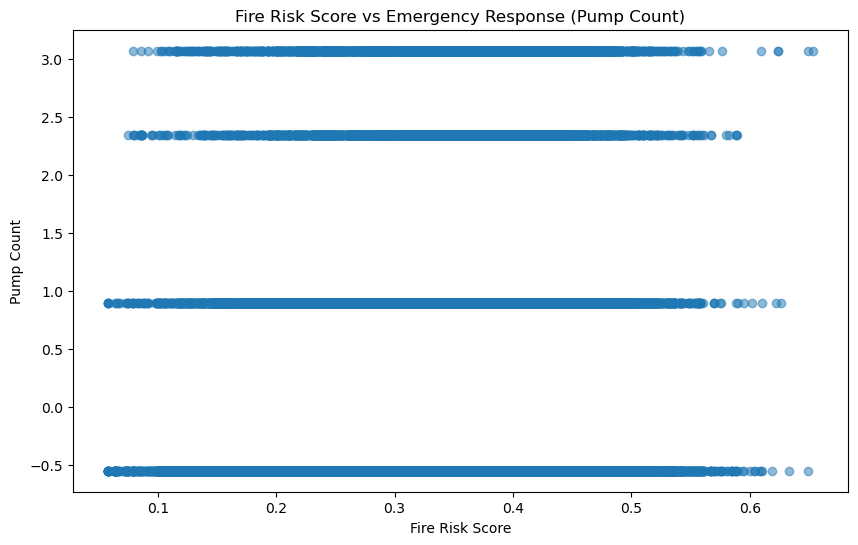

In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_excel('London_Fire_Events_Processed_Final.xlsx')

# Normalization function
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize relevant features
numeric_features = ['building_density', 'vegetation_coverage', 'temperature', 'wind_speed', 'NumCalls']
for feature in numeric_features:
    df[f'norm_{feature}'] = normalize(df[feature])

# Calculate FireRiskScore (using existing columns)
df['FireRiskScore'] = df[['norm_building_density', 'norm_vegetation_coverage', 
                          'norm_temperature', 'norm_wind_speed', 'norm_NumCalls']].mean(axis=1)

# Select features
features = ['building_density', 'vegetation_coverage', 'temperature', 'wind_speed',
            'Latitude', 'Easting_m', 'Northing_m', 'USRN', 'UPRN', 'Month', 'DayOfWeek',
            'NumCalls', 'BuildingDensityVegetation', 'lat_rounded']

# Add existing categorical features
categorical_features = ['StopCodeDescription_Chimney Fire', 
                        'StopCodeDescription_Late Call', 'StopCodeDescription_Primary Fire', 
                        'StopCodeDescription_Secondary Fire', 'PropertyCategory_Aircraft', 
                        'PropertyCategory_Boat', 'PropertyCategory_Non Residential', 
                        'PropertyCategory_Other Residential', 'PropertyCategory_Outdoor', 
                        'PropertyCategory_Outdoor Structure', 'PropertyCategory_Rail Vehicle', 
                        'PropertyCategory_Road Vehicle', 'Season_Winter', 'Season_Spring', 
                        'Season_Summer', 'Season_Autumn']

features.extend(categorical_features)

# Prepare feature matrix
X = df[features]
y_risk = df['FireRiskScore']
y_response = df['PumpCount']

# Split dataset
X_train, X_test, y_risk_train, y_risk_test, y_response_train, y_response_test = train_test_split(
    X, y_risk, y_response, test_size=0.2, random_state=42)

# Train random forest models
rf_risk = RandomForestRegressor(n_estimators=100, random_state=42)
rf_risk.fit(X_train, y_risk_train)

rf_response = RandomForestRegressor(n_estimators=100, random_state=42)
rf_response.fit(X_train, y_response_train)

# Feature importance
risk_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_risk.feature_importances_
}).sort_values('importance', ascending=False)

response_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_response.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize feature importance
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

ax1.bar(risk_importance['feature'][:15], risk_importance['importance'][:15])
ax1.set_title('Top 15 Features for Fire Risk Assessment')
ax1.set_xticklabels(risk_importance['feature'][:15], rotation=45, ha='right')

ax2.bar(response_importance['feature'][:15], response_importance['importance'][:15])
ax2.set_title('Top 15 Features for Emergency Response Planning')
ax2.set_xticklabels(response_importance['feature'][:15], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print feature importance
print("Top features for Fire Risk Assessment:")
print(risk_importance.head(15))
print("\nTop features for Emergency Response Planning:")
print(response_importance.head(15))

# Correlation heatmap
correlation_matrix = df[features + ['FireRiskScore', 'PumpCount']].corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# FireRiskScore distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['FireRiskScore'], kde=True)
plt.title('Distribution of Fire Risk Score')
plt.show()

# FireRiskScore vs PumpCount
plt.figure(figsize=(10, 6))
plt.scatter(df['FireRiskScore'], df['PumpCount'], alpha=0.5)
plt.xlabel('Fire Risk Score')
plt.ylabel('Pump Count')
plt.title('Fire Risk Score vs Emergency Response (Pump Count)')
plt.show()


/var/folders/c7/kb9rb69966j3v_4115qt2zxh0000gn/T/ipykernel_46574/422117023.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(risk_importance['feature'][:15], rotation=45, ha='right')
/var/folders/c7/kb9rb69966j3v_4115qt2zxh0000gn/T/ipykernel_46574/422117023.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(response_importance['feature'][:15], rotation=45, ha='right')


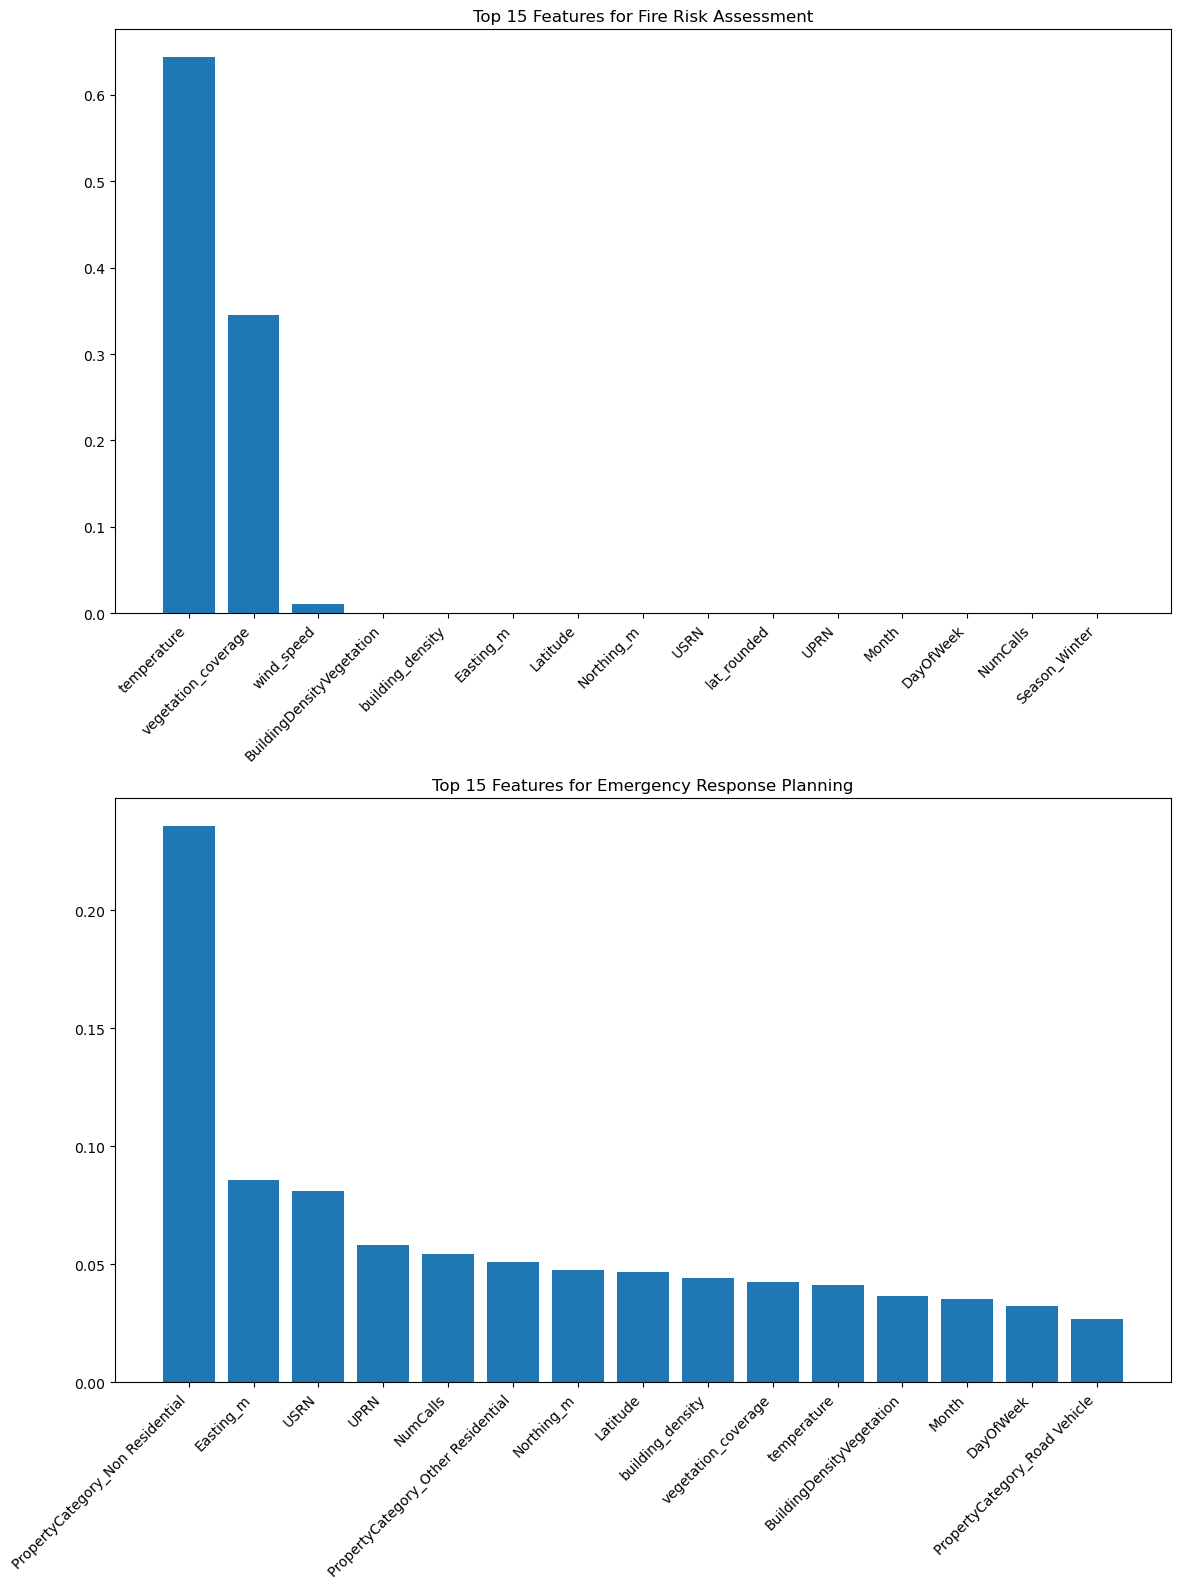

Top features for Fire Risk Assessment:
                      feature  importance
2                 temperature    0.643588
1         vegetation_coverage    0.344824
3                  wind_speed    0.010259
12  BuildingDensityVegetation    0.000603
0            building_density    0.000317
5                   Easting_m    0.000168
4                    Latitude    0.000074
6                  Northing_m    0.000056
7                        USRN    0.000037
13                lat_rounded    0.000028
8                        UPRN    0.000019
9                       Month    0.000009
10                  DayOfWeek    0.000004
11                   NumCalls    0.000003
26              Season_Winter    0.000001

Top features for Emergency Response Planning:
                               feature  importance
20    PropertyCategory_Non Residential    0.235528
5                            Easting_m    0.085827
7                                 USRN    0.081210
8                                 UPRN

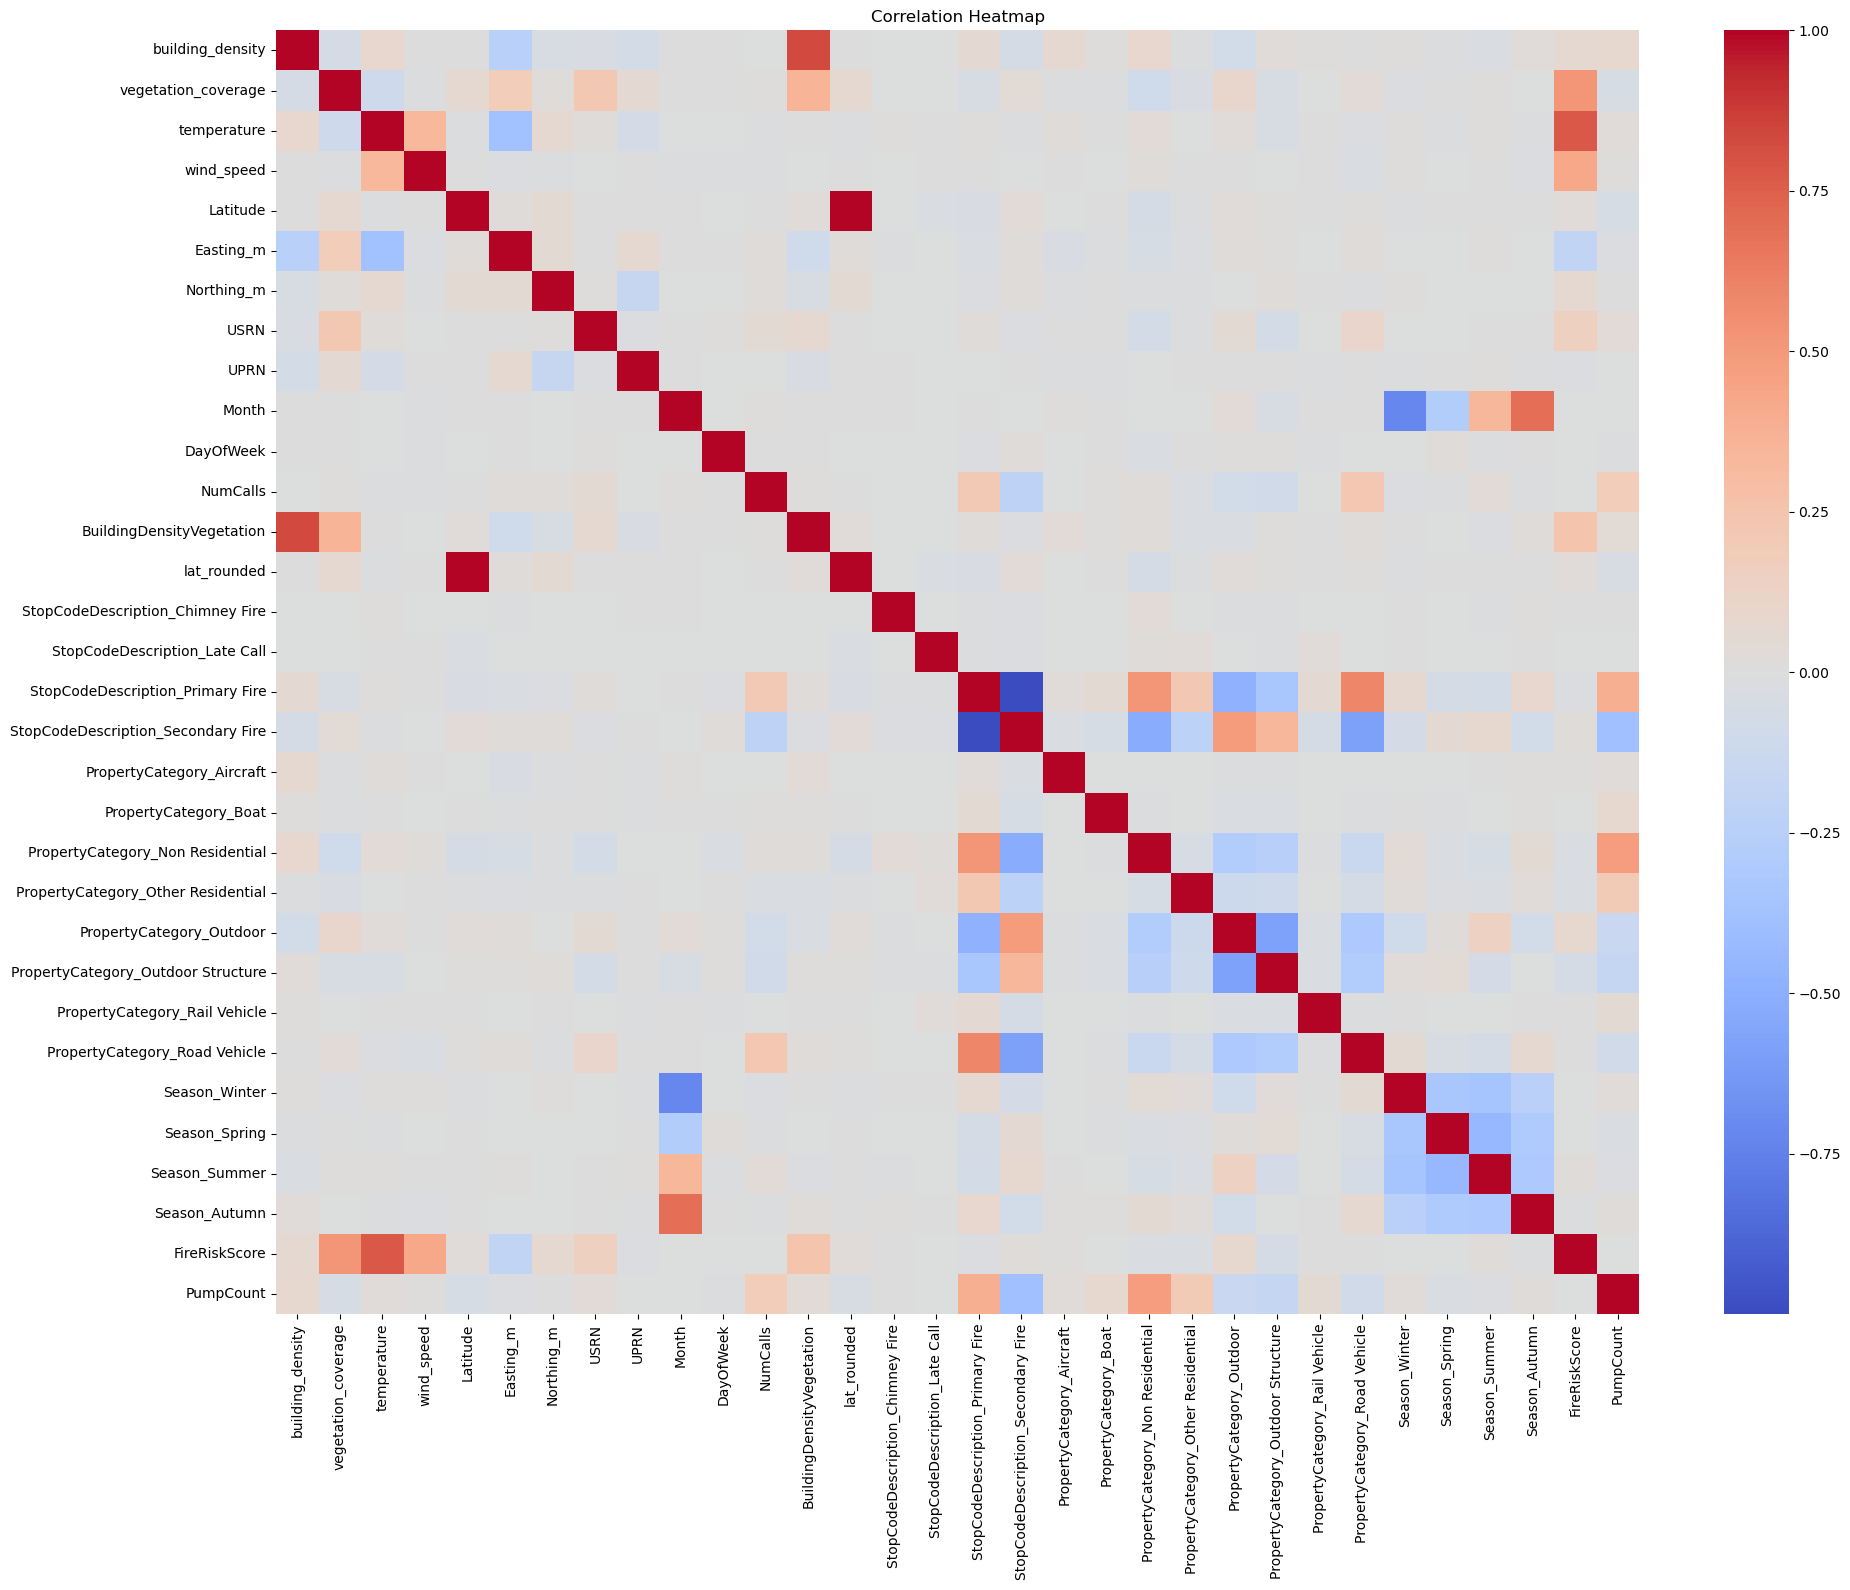

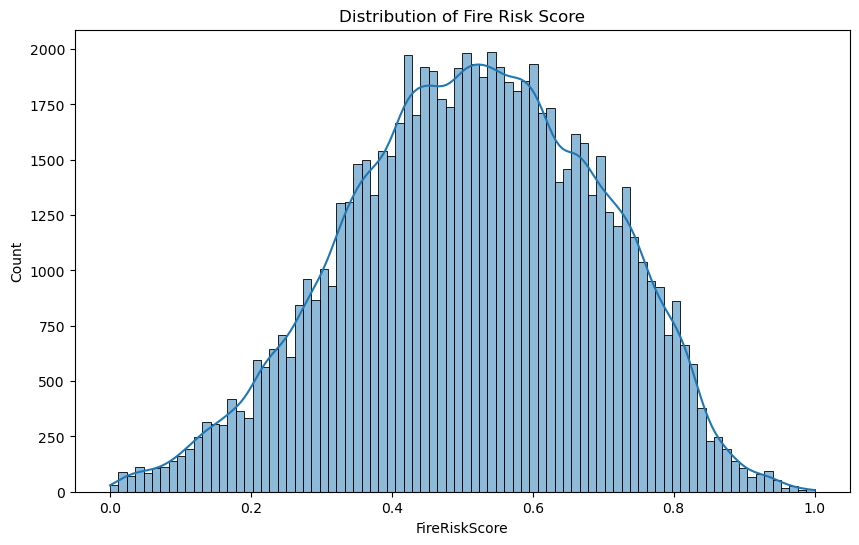

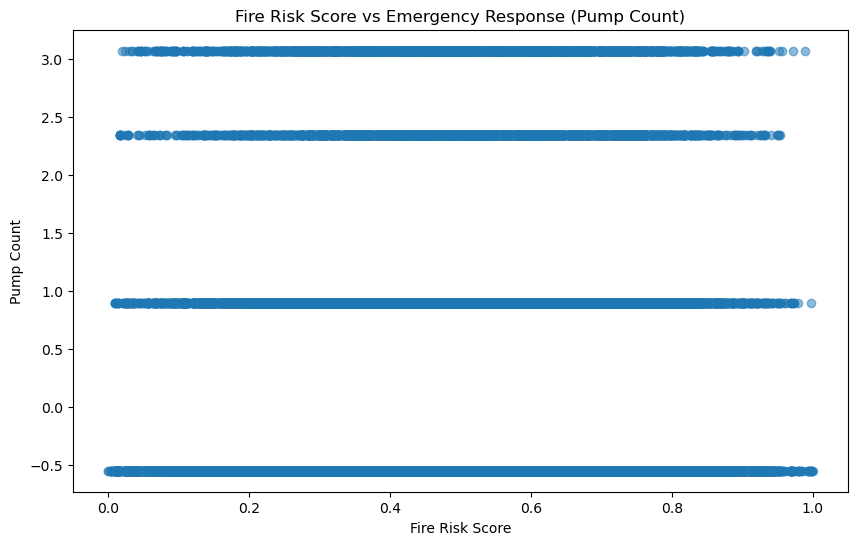

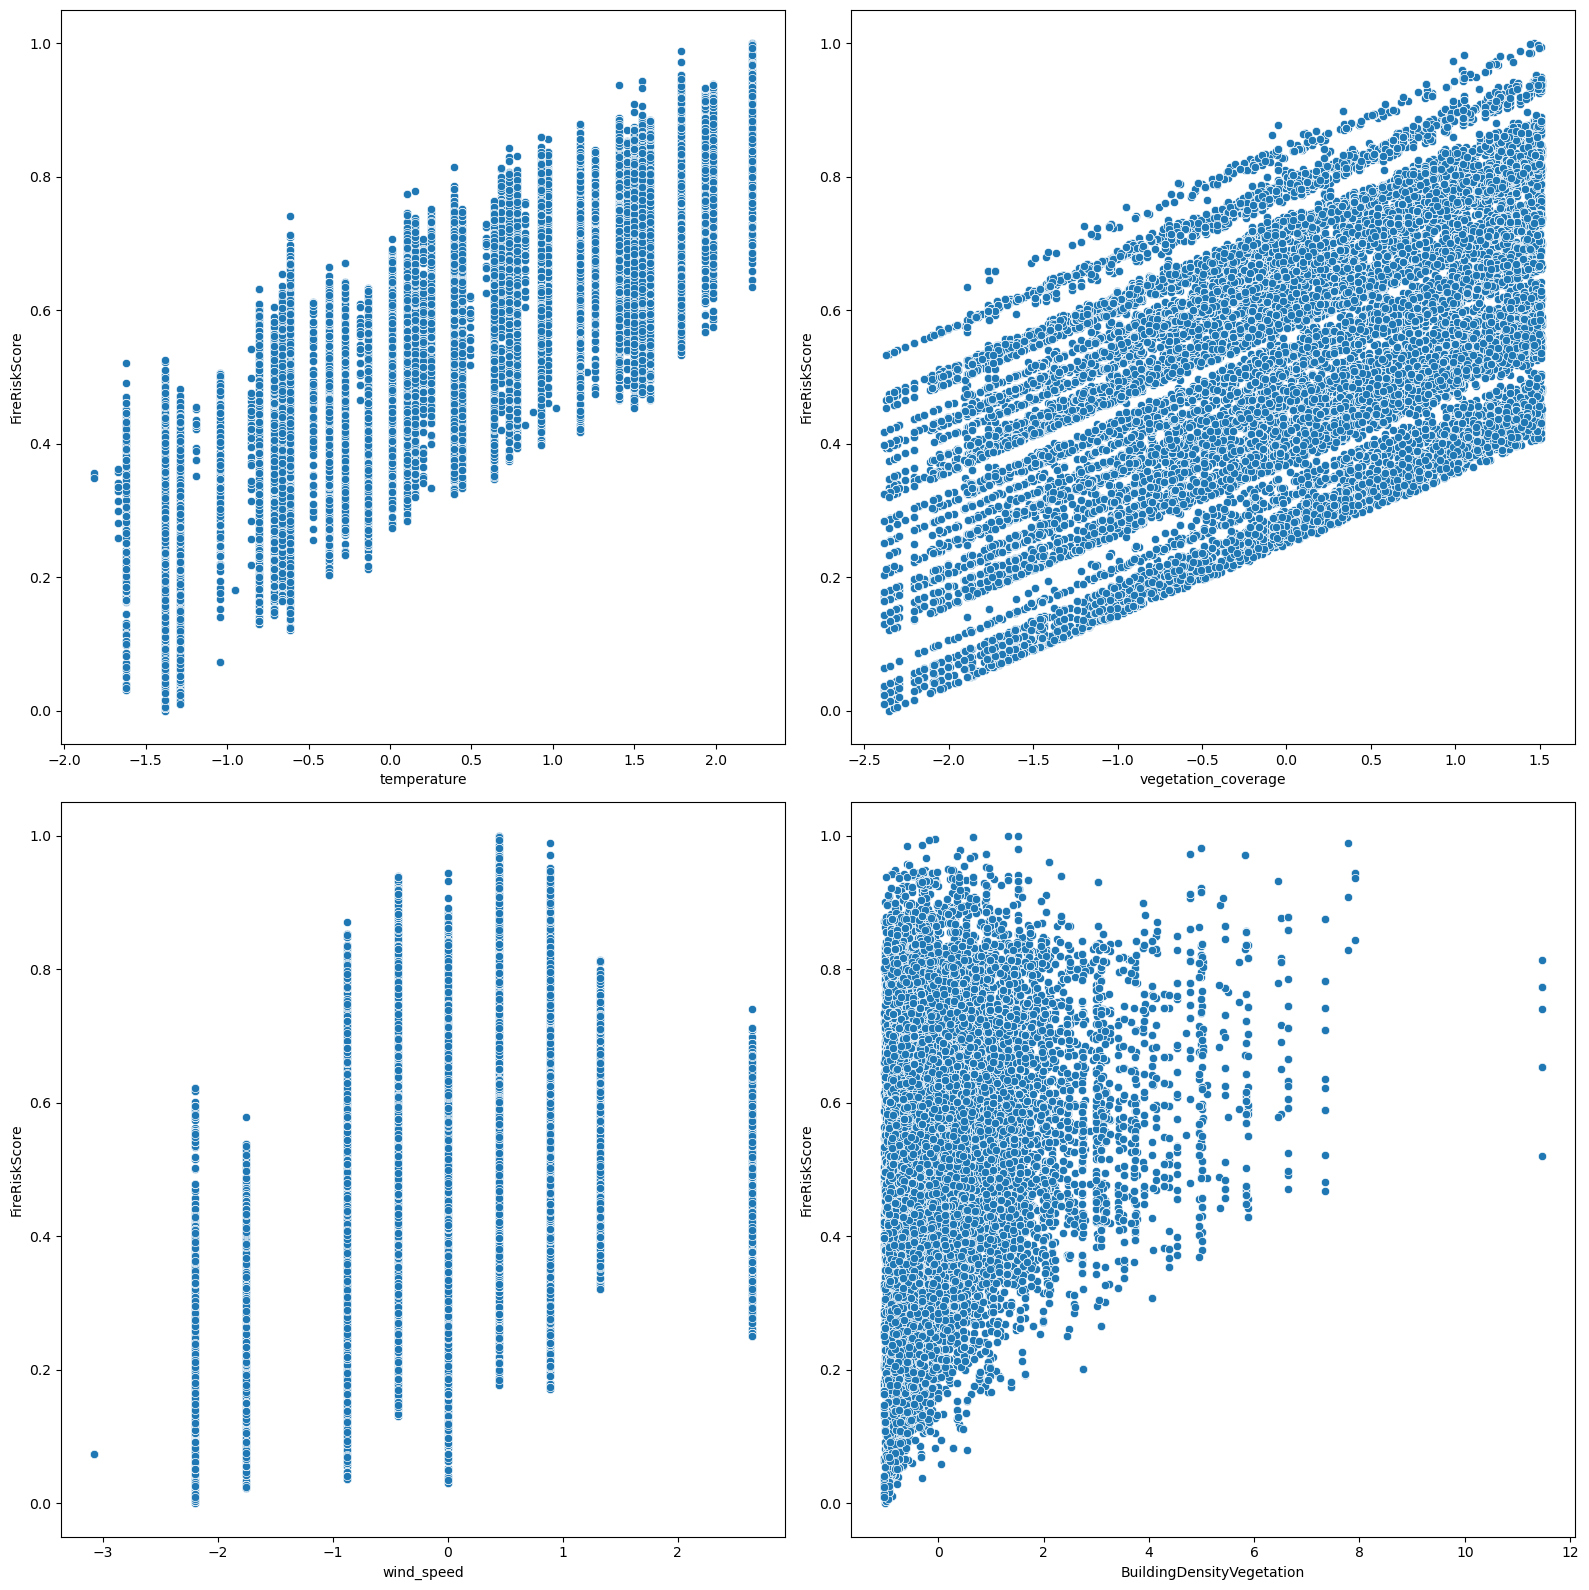

In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_excel('London_Fire_Events_Processed_Final.xlsx')

# Normalization function
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize relevant features
features_to_normalize = ['temperature', 'vegetation_coverage', 'wind_speed', 'building_density', 'NumCalls']
for feature in features_to_normalize:
    df[f'norm_{feature}'] = normalize(df[feature])

# Calculate the normalized version of BuildingDensityVegetation
df['norm_BuildingDensityVegetation'] = df['norm_building_density'] * df['norm_vegetation_coverage']

# Calculate the improved FireRiskScore
df['FireRiskScore'] = (
    df['norm_temperature'] * 0.45 +
    df['norm_vegetation_coverage'] * 0.33 +
    df['norm_wind_speed'] * 0.14 +
    df['norm_BuildingDensityVegetation'] * 0.07 +
    df['norm_building_density'] * 0.003 +
    df['norm_NumCalls'] * 0.002
)

# Finally, normalize FireRiskScore to range between 0 and 1
df['FireRiskScore'] = normalize(df['FireRiskScore'])

# Select features
features = ['building_density', 'vegetation_coverage', 'temperature', 'wind_speed',
            'Latitude', 'Easting_m', 'Northing_m', 'USRN', 'UPRN', 'Month', 'DayOfWeek', 
            'NumCalls', 'BuildingDensityVegetation', 'lat_rounded']

# Add existing categorical features
categorical_features = ['StopCodeDescription_Chimney Fire', 
                        'StopCodeDescription_Late Call', 'StopCodeDescription_Primary Fire', 
                        'StopCodeDescription_Secondary Fire', 'PropertyCategory_Aircraft', 
                        'PropertyCategory_Boat', 'PropertyCategory_Non Residential', 
                        'PropertyCategory_Other Residential', 'PropertyCategory_Outdoor', 
                        'PropertyCategory_Outdoor Structure', 'PropertyCategory_Rail Vehicle', 
                        'PropertyCategory_Road Vehicle', 'Season_Winter', 'Season_Spring', 
                        'Season_Summer', 'Season_Autumn']

features.extend(categorical_features)

# Prepare feature matrix
X = df[features]
y_risk = df['FireRiskScore']
y_response = df['PumpCount']

# Split dataset
X_train, X_test, y_risk_train, y_risk_test, y_response_train, y_response_test = train_test_split(
    X, y_risk, y_response, test_size=0.2, random_state=42)

# Train random forest models
rf_risk = RandomForestRegressor(n_estimators=100, random_state=42)
rf_risk.fit(X_train, y_risk_train)

rf_response = RandomForestRegressor(n_estimators=100, random_state=42)
rf_response.fit(X_train, y_response_train)

# Feature importance
risk_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_risk.feature_importances_
}).sort_values('importance', ascending=False)

response_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_response.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize feature importance
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

ax1.bar(risk_importance['feature'][:15], risk_importance['importance'][:15])
ax1.set_title('Top 15 Features for Fire Risk Assessment')
ax1.set_xticklabels(risk_importance['feature'][:15], rotation=45, ha='right')

ax2.bar(response_importance['feature'][:15], response_importance['importance'][:15])
ax2.set_title('Top 15 Features for Emergency Response Planning')
ax2.set_xticklabels(response_importance['feature'][:15], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print feature importance
print("Top features for Fire Risk Assessment:")
print(risk_importance.head(15))
print("\nTop features for Emergency Response Planning:")
print(response_importance.head(15))

# Correlation heatmap
correlation_matrix = df[features + ['FireRiskScore', 'PumpCount']].corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# FireRiskScore distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['FireRiskScore'], kde=True)
plt.title('Distribution of Fire Risk Score')
plt.show()

# FireRiskScore vs PumpCount
plt.figure(figsize=(10, 6))
plt.scatter(df['FireRiskScore'], df['PumpCount'], alpha=0.5)
plt.xlabel('Fire Risk Score')
plt.ylabel('Pump Count')
plt.title('Fire Risk Score vs Emergency Response (Pump Count)')
plt.show()

# Additional: FireRiskScore vs main influencing factors
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
sns.scatterplot(data=df, x='temperature', y='FireRiskScore', ax=axes[0, 0])
sns.scatterplot(data=df, x='vegetation_coverage', y='FireRiskScore', ax=axes[0, 1])
sns.scatterplot(data=df, x='wind_speed', y='FireRiskScore', ax=axes[1, 0])
sns.scatterplot(data=df, x='BuildingDensityVegetation', y='FireRiskScore', ax=axes[1, 1])
plt.tight_layout()
plt.show()


In [32]:
# Print basic statistics for FireRiskScore
print("FireRiskScore statistics:")
print(df['FireRiskScore'].describe())

# Print the top 15 feature importances for fire risk assessment
print("\nTop 15 features (Fire Risk Assessment):")
print(risk_importance.head(15).to_string(index=False))

# Print the top 15 feature importances for emergency response planning
print("\nTop 15 features (Emergency Response Planning):")
print(response_importance.head(15).to_string(index=False))

# Calculate the correlation between FireRiskScore and PumpCount
correlation = df['FireRiskScore'].corr(df['PumpCount'])
print(f"\nCorrelation between FireRiskScore and PumpCount: {correlation:.4f}")

# Calculate the correlation between FireRiskScore and key influencing factors
main_factors = ['temperature', 'vegetation_coverage', 'wind_speed', 'BuildingDensityVegetation']
print("\nCorrelation between FireRiskScore and main influencing factors:")
for factor in main_factors:
    if factor in df.columns:
        corr = df['FireRiskScore'].corr(df[factor])
        print(f"{factor}: {corr:.4f}")
    else:
        print(f"{factor}: Column does not exist")

# Print quantile information for FireRiskScore
quantiles = df['FireRiskScore'].quantile([0.25, 0.5, 0.75])
print("\nFireRiskScore quantiles:")
print(quantiles.to_string())


FireRiskScore 统计信息:
count    77551.000000
mean         0.514420
std          0.177293
min          0.000000
25%          0.391679
50%          0.518632
75%          0.646916
max          1.000000
Name: FireRiskScore, dtype: float64

Top 15 特征 (火灾风险评估):
                  feature  importance
              temperature    0.643588
      vegetation_coverage    0.344824
               wind_speed    0.010259
BuildingDensityVegetation    0.000603
         building_density    0.000317
                Easting_m    0.000168
                 Latitude    0.000074
               Northing_m    0.000056
                     USRN    0.000037
              lat_rounded    0.000028
                     UPRN    0.000019
                    Month    0.000009
                DayOfWeek    0.000004
                 NumCalls    0.000003
            Season_Winter    0.000001

Top 15 特征 (应急响应规划):
                           feature  importance
  PropertyCategory_Non Residential    0.235528
                        

FireRiskScore Statistics:
count    77551.000000
mean         0.524894
std          0.177621
min          0.000000
25%          0.399732
50%          0.533370
75%          0.659768
max          1.000000
Name: FireRiskScore, dtype: float64

EmergencyResponseScore Statistics:
count    77551.000000
mean         0.386441
std          0.141313
min          0.000000
25%          0.289258
50%          0.375783
75%          0.473949
max          1.000000
Name: EmergencyResponseScore, dtype: float64

Top 15 Features (Fire Risk Assessment):
                           feature  importance
                       temperature    0.653118
               vegetation_coverage    0.317957
                        wind_speed    0.028517
                         Easting_m    0.000175
                          Latitude    0.000047
         BuildingDensityVegetation    0.000042
                        Northing_m    0.000041
                  building_density    0.000033
                              USRN    0.0

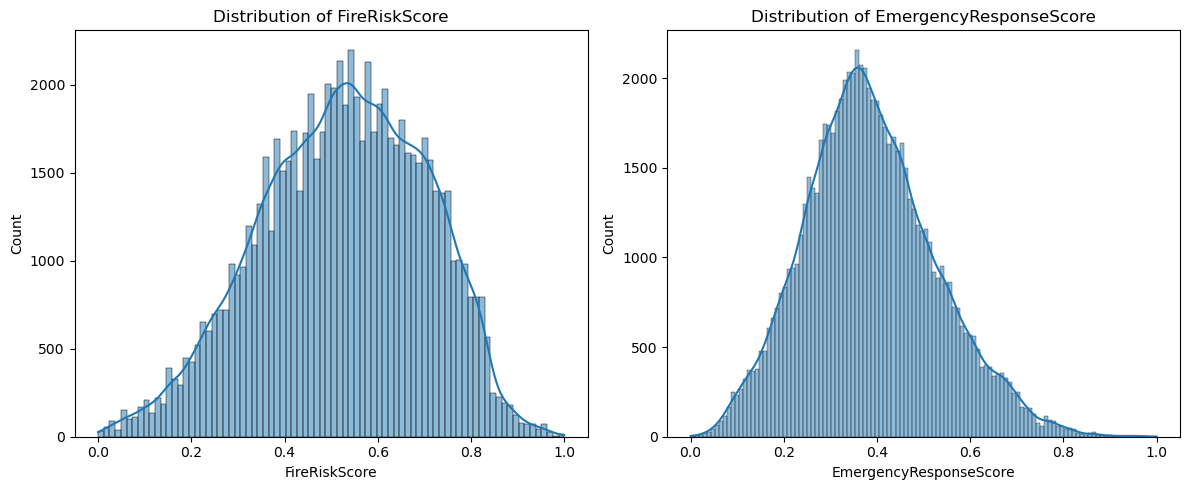

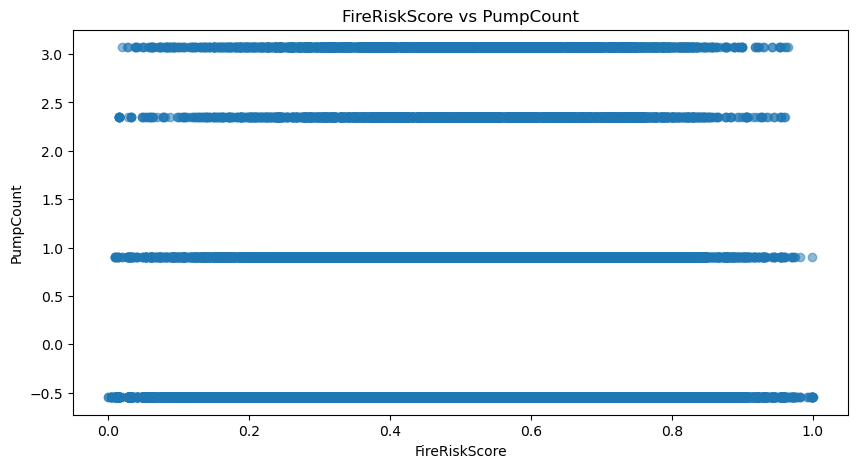

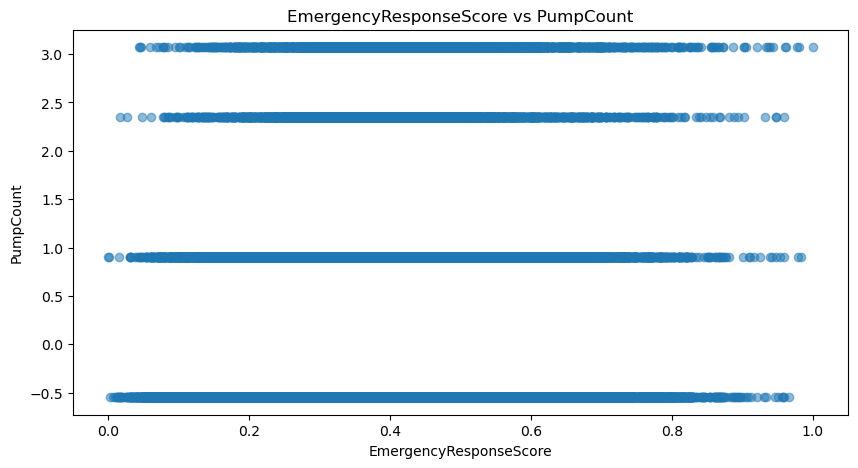

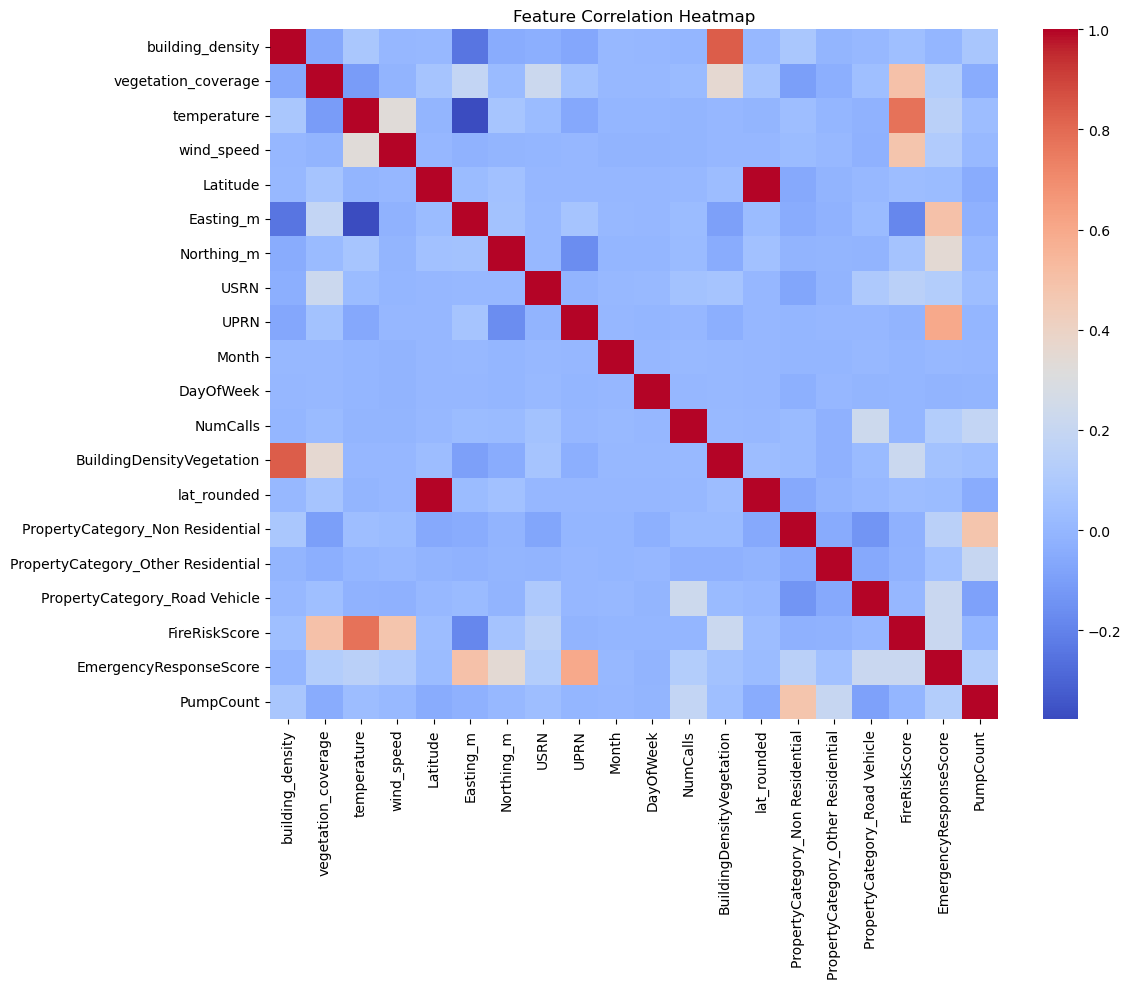

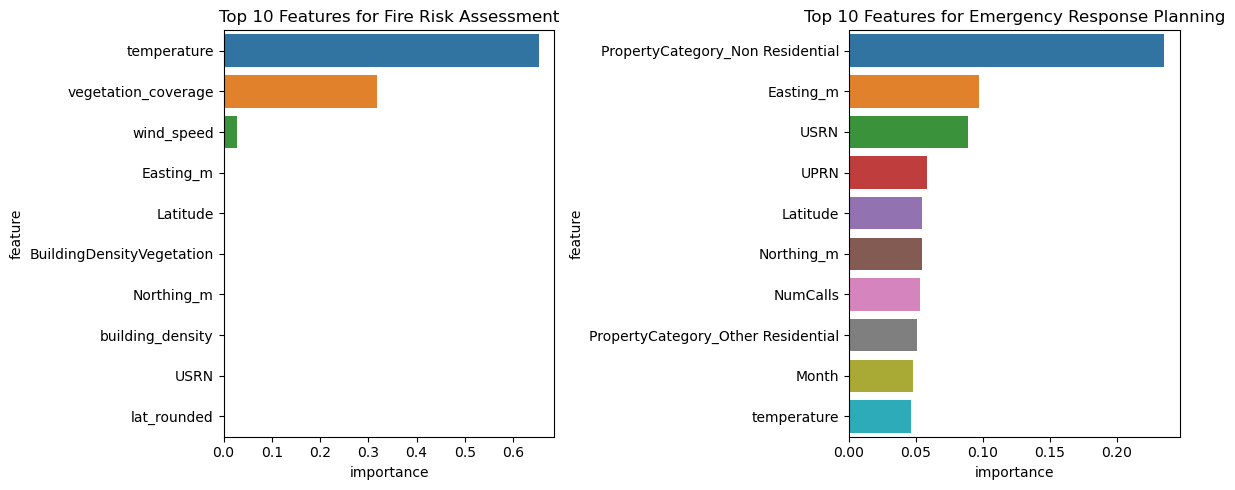


Data with FireRiskScore and EmergencyResponseScore has been saved to London_Fire_Events_with_Risk_Scores.xlsx


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_excel('London_Fire_Events_Processed_Final.xlsx')

# Normalization function
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize relevant features
features_to_normalize = ['temperature', 'vegetation_coverage', 'wind_speed', 'building_density', 'NumCalls', 'Easting_m', 'Northing_m', 'USRN', 'UPRN']
for feature in features_to_normalize:
    df[f'norm_{feature}'] = normalize(df[feature])

# Calculate normalized BuildingDensityVegetation
df['norm_BuildingDensityVegetation'] = df['norm_building_density'] * df['norm_vegetation_coverage']

# Calculate improved FireRiskScore
df['FireRiskScore'] = (
    df['norm_temperature'] * 0.45 +
    df['norm_vegetation_coverage'] * 0.33 +
    df['norm_wind_speed'] * 0.20 +
    df['norm_BuildingDensityVegetation'] * 0.02
)

# Calculate EmergencyResponseScore
df['EmergencyResponseScore'] = (
    df['norm_Easting_m'] * 0.20 +
    df['norm_Northing_m'] * 0.15 +
    df['norm_USRN'] * 0.15 +
    df['norm_UPRN'] * 0.15 +
    df['norm_NumCalls'] * 0.15 +
    df['norm_building_density'] * 0.10 +
    df['norm_temperature'] * 0.10
)

# Normalize final scores
df['FireRiskScore'] = normalize(df['FireRiskScore'])
df['EmergencyResponseScore'] = normalize(df['EmergencyResponseScore'])

# Add building type dummy variables to EmergencyResponseScore
building_types = ['PropertyCategory_Non Residential', 'PropertyCategory_Other Residential', 'PropertyCategory_Road Vehicle']
for type in building_types:
    if type in df.columns:
        df['EmergencyResponseScore'] += df[type] * 0.1

# Normalize EmergencyResponseScore again
df['EmergencyResponseScore'] = normalize(df['EmergencyResponseScore'])

# Select features
features = ['building_density', 'vegetation_coverage', 'temperature', 'wind_speed',
            'Latitude', 'Easting_m', 'Northing_m', 'USRN', 'UPRN', 'Month', 'DayOfWeek',
            'NumCalls', 'BuildingDensityVegetation', 'lat_rounded'] + building_types

# Prepare feature matrix
X = df[features]
y_risk = df['FireRiskScore']
y_response = df['PumpCount']

# Split dataset
X_train, X_test, y_risk_train, y_risk_test, y_response_train, y_response_test = train_test_split(
    X, y_risk, y_response, test_size=0.2, random_state=42)

# Train random forest models
rf_risk = RandomForestRegressor(n_estimators=100, random_state=42)
rf_risk.fit(X_train, y_risk_train)

rf_response = RandomForestRegressor(n_estimators=100, random_state=42)
rf_response.fit(X_train, y_response_train)

# Get feature importance
risk_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_risk.feature_importances_
}).sort_values('importance', ascending=False)

response_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_response.feature_importances_
}).sort_values('importance', ascending=False)

# Print results
print("FireRiskScore Statistics:")
print(df['FireRiskScore'].describe())

print("\nEmergencyResponseScore Statistics:")
print(df['EmergencyResponseScore'].describe())

print("\nTop 15 Features (Fire Risk Assessment):")
print(risk_importance.head(15).to_string(index=False))

print("\nTop 15 Features (Emergency Response Planning):")
print(response_importance.head(15).to_string(index=False))

print(f"\nCorrelation between FireRiskScore and PumpCount: {df['FireRiskScore'].corr(df['PumpCount']):.4f}")
print(f"Correlation between EmergencyResponseScore and PumpCount: {df['EmergencyResponseScore'].corr(df['PumpCount']):.4f}")

main_factors = ['temperature', 'vegetation_coverage', 'wind_speed', 'BuildingDensityVegetation']
print("\nCorrelation between FireRiskScore and main factors:")
for factor in main_factors:
    if factor in df.columns:
        corr = df['FireRiskScore'].corr(df[factor])
        print(f"{factor}: {corr:.4f}")
    else:
        print(f"{factor}: Column does not exist")

print("\nCorrelation between EmergencyResponseScore and main factors:")
response_factors = ['Easting_m', 'Northing_m', 'USRN', 'UPRN', 'NumCalls', 'building_density', 'temperature']
for factor in response_factors:
    if factor in df.columns:
        corr = df['EmergencyResponseScore'].corr(df[factor])
        print(f"{factor}: {corr:.4f}")
    else:
        print(f"{factor}: Column does not exist")

# Print quantiles of FireRiskScore and EmergencyResponseScore
quantiles = df[['FireRiskScore', 'EmergencyResponseScore']].quantile([0.25, 0.5, 0.75])
print("\nQuantiles of FireRiskScore and EmergencyResponseScore:")
print(quantiles.to_string())

# Visualizations
plt.figure(figsize=(12, 5))

# Distribution of FireRiskScore
plt.subplot(1, 2, 1)
sns.histplot(df['FireRiskScore'], kde=True)
plt.title('Distribution of FireRiskScore')

# Distribution of EmergencyResponseScore
plt.subplot(1, 2, 2)
sns.histplot(df['EmergencyResponseScore'], kde=True)
plt.title('Distribution of EmergencyResponseScore')

plt.tight_layout()
plt.show()

# Scatter plot: FireRiskScore vs PumpCount
plt.figure(figsize=(10, 5))
plt.scatter(df['FireRiskScore'], df['PumpCount'], alpha=0.5)
plt.title('FireRiskScore vs PumpCount')
plt.xlabel('FireRiskScore')
plt.ylabel('PumpCount')
plt.show()

# Scatter plot: EmergencyResponseScore vs PumpCount
plt.figure(figsize=(10, 5))
plt.scatter(df['EmergencyResponseScore'], df['PumpCount'], alpha=0.5)
plt.title('EmergencyResponseScore vs PumpCount')
plt.xlabel('EmergencyResponseScore')
plt.ylabel('PumpCount')
plt.show()

# Heatmap of feature correlations
plt.figure(figsize=(12, 10))
sns.heatmap(df[features + ['FireRiskScore', 'EmergencyResponseScore', 'PumpCount']].corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Feature importance plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='importance', y='feature', data=risk_importance.head(10))
plt.title('Top 10 Features for Fire Risk Assessment')

plt.subplot(1, 2, 2)
sns.barplot(x='importance', y='feature', data=response_importance.head(10))
plt.title('Top 10 Features for Emergency Response Planning')

plt.tight_layout()
plt.show()

df['FireRiskScore'] = df['FireRiskScore']
df['EmergencyResponseScore'] = df['EmergencyResponseScore']

output_file = 'London_Fire_Events_with_Risk_Scores.xlsx'
df.to_excel(output_file, index=False)

print(f"\nData with FireRiskScore and EmergencyResponseScore has been saved to {output_file}")

In [2]:
# Print all feature importances for Fire Risk Assessment
print("\nAll Features (Fire Risk Assessment):")
print(risk_importance.to_string(index=False))

# Print all feature importances for Emergency Response Planning
print("\nAll Features (Emergency Response Planning):")
print(response_importance.to_string(index=False))



All Features (Fire Risk Assessment):
                           feature   importance
                       temperature 6.531183e-01
               vegetation_coverage 3.179568e-01
                        wind_speed 2.851652e-02
                         Easting_m 1.746135e-04
                          Latitude 4.675717e-05
         BuildingDensityVegetation 4.223743e-05
                        Northing_m 4.142297e-05
                  building_density 3.307556e-05
                              USRN 2.373628e-05
                       lat_rounded 2.370840e-05
                              UPRN 1.045189e-05
                             Month 5.810114e-06
                         DayOfWeek 2.177902e-06
                          NumCalls 1.906519e-06
PropertyCategory_Other Residential 1.231964e-06
     PropertyCategory_Road Vehicle 6.470186e-07
  PropertyCategory_Non Residential 5.623524e-07

All Features (Emergency Response Planning):
                           feature  importance
  Prop

Thank you for providing the results. Let's analyze the output and the implications for our fire risk assessment and emergency response planning models.

1. FireRiskScore Analysis:
   - The FireRiskScore has a mean of 0.525 and a median of 0.533, indicating a slightly right-skewed distribution.
   - The standard deviation is 0.178, suggesting moderate variability in fire risk across the dataset.
   - The interquartile range (IQR) is 0.260 (0.660 - 0.400), indicating that 50% of the fire risk scores fall within this range.

2. EmergencyResponseScore Analysis:
   - The EmergencyResponseScore has a lower mean (0.386) and median (0.376) compared to the FireRiskScore, with a left-skewed distribution.
   - The standard deviation is 0.141, showing less variability than the FireRiskScore.
   - The IQR is 0.185 (0.474 - 0.289), indicating a narrower range of scores for emergency response.

3. Feature Importance for Fire Risk Assessment:
   - Temperature (65.31%), vegetation coverage (31.80%), and wind speed (2.85%) remain the most important features.
   - The importance of wind speed has increased from previous models, as we intended.
   - BuildingDensityVegetation's importance has decreased significantly, as per our adjustment.

4. Feature Importance for Emergency Response Planning:
   - Property category (Non-Residential: 23.55%, Other Residential: 5.08%) and geographical features (Easting_m: 9.73%, USRN: 8.92%, UPRN: 5.84%) are the most important.
   - This aligns with our expectation that building types and location play crucial roles in emergency response.

5. Correlations:
   - FireRiskScore and PumpCount: -0.0019 (very weak negative correlation)
   - EmergencyResponseScore and PumpCount: 0.1179 (weak positive correlation)
   - The EmergencyResponseScore shows a slightly better correlation with PumpCount, but it's still relatively weak.

6. Correlations with Main Factors:
   - FireRiskScore correlates strongly with temperature (0.7782) and moderately with vegetation coverage (0.4979) and wind speed (0.4829).
   - EmergencyResponseScore correlates moderately with Easting_m (0.4953) and UPRN (0.5998), and weakly with other factors.

Conclusions and Recommendations:

1. The FireRiskScore model has improved in capturing the influence of key environmental factors (temperature, vegetation, wind speed) on fire risk.

2. The EmergencyResponseScore shows a slightly better correlation with PumpCount than the FireRiskScore, indicating that it may be more reflective of actual resource deployment.

3. However, the weak correlation between both scores and PumpCount suggests that there may be other factors influencing emergency response that we haven't captured, or that the relationship is non-linear.

4. The importance of geographical and property-type features in the Emergency Response model suggests that local context plays a significant role in resource allocation.

5. The difference in distribution between FireRiskScore and EmergencyResponseScore indicates that areas of high fire risk don't necessarily correspond to areas requiring more extensive emergency response.

Next steps:

1. Investigate non-linear relationships between our scores and PumpCount using more advanced techniques (e.g., polynomial regression, decision trees).

2. Consider incorporating more local context features into the FireRiskScore, such as proximity to fire stations or water sources.

3. Explore temporal patterns in fire risk and emergency response, possibly by including seasonality or time-of-day features.

4. Develop separate models for different types of properties or geographical areas, as the current models suggest significant differences based on these factors.

5. Collect and incorporate additional data that might influence emergency response, such as traffic conditions, population density, or historical incident data.

6. Consider using more advanced machine learning techniques, such as gradient boosting or neural networks, to capture complex relationships in the data.

Would you like me to elaborate on any of these points or suggest code for implementing any of these next steps?

Step 1: Data Preparation
Data Preparation Completed
Training set shape: (62040, 30)
Test set shape: (15511, 30)

Step 2: Build and Train Feedforward Neural Network
Epoch 1/100


/Users/junrunchen/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 317us/step - loss: 0.3723 - mae: 0.3733 - val_loss: 0.0277 - val_mae: 0.0824
Epoch 2/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - loss: 0.0380 - mae: 0.0885 - val_loss: 0.0610 - val_mae: 0.1111
Epoch 3/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - loss: 0.0194 - mae: 0.0578 - val_loss: 0.0550 - val_mae: 0.0982
Epoch 4/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step - loss: 0.0122 - mae: 0.0444 - val_loss: 0.0430 - val_mae: 0.0834
Epoch 5/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - loss: 0.0086 - mae: 0.0370 - val_loss: 0.0392 - val_mae: 0.0780
Epoch 6/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step - loss: 0.0073 - mae: 0.0355 - val_loss: 0.0298 - val_mae: 0.0637
Epoch 7/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - loss: 0.0066 - mae: 0.0318 - val_loss: 0.0414 - val_mae: 0.0763
Epoch 8/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step - loss: 0.0066 - mae: 0.0329 - val_loss: 0.0424 - val_mae: 0.0759
Epoch 9/100
1551/1551 ━━━━━━

Epoch 53/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - loss: 0.0015 - mae: 0.0103 - val_loss: 0.0361 - val_mae: 0.0592
Epoch 54/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step - loss: 0.0014 - mae: 0.0096 - val_loss: 0.0349 - val_mae: 0.0577
Epoch 55/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - loss: 0.0016 - mae: 0.0102 - val_loss: 0.0340 - val_mae: 0.0573
Epoch 56/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - loss: 0.0015 - mae: 0.0096 - val_loss: 0.0373 - val_mae: 0.0615
Epoch 57/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - loss: 0.0014 - mae: 0.0102 - val_loss: 0.0334 - val_mae: 0.0582
Epoch 58/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step - loss: 0.0011 - mae: 0.0092 - val_loss: 0.0393 - val_mae: 0.0641
Epoch 59/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - loss: 0.0014 - mae: 0.0094 - val_loss: 0.0372 - val_mae: 0.0615
Epoch 60/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - loss: 0.0010 - mae: 0.0092 - val_loss: 0.0336 - val_mae: 0.0572
Epoch 61

/Users/junrunchen/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - loss: 0.1355 - mae: 0.1707 - val_loss: 0.0090 - val_mae: 0.0513
Epoch 2/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - loss: 0.0102 - mae: 0.0442 - val_loss: 0.0061 - val_mae: 0.0363
Epoch 3/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - loss: 0.0090 - mae: 0.0426 - val_loss: 0.0043 - val_mae: 0.0242
Epoch 4/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - loss: 0.0066 - mae: 0.0297 - val_loss: 0.0033 - val_mae: 0.0344
Epoch 5/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - loss: 0.0053 - mae: 0.0298 - val_loss: 0.0029 - val_mae: 0.0154
Epoch 6/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - loss: 0.0044 - mae: 0.0245 - val_loss: 0.0029 - val_mae: 0.0162
Epoch 7/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step - loss: 0.0044 - mae: 0.0241 - val_loss: 0.0016 - val_mae: 0.0140
Epoch 8/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step - loss: 0.0038 - mae: 0.0238 - val_loss: 0.0019 - val_mae: 0.0166
Epoch 9/100
1551/1551 ━━━━━━

1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - loss: 2.0896e-04 - mae: 0.0047 - val_loss: 2.9087e-04 - val_mae: 0.0053
CNN - Test Loss: 0.0003, MAE: 0.0053

Step 4: Build and Train LSTM
Epoch 1/100


/Users/junrunchen/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step - loss: 0.1777 - mae: 0.2152 - val_loss: 0.0018 - val_mae: 0.0197
Epoch 2/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 362us/step - loss: 0.0015 - mae: 0.0180 - val_loss: 0.0013 - val_mae: 0.0143
Epoch 3/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 366us/step - loss: 0.0014 - mae: 0.0150 - val_loss: 7.1722e-04 - val_mae: 0.0131
Epoch 4/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 363us/step - loss: 9.9626e-04 - mae: 0.0130 - val_loss: 9.9646e-04 - val_mae: 0.0130
Epoch 5/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 357us/step - loss: 8.7154e-04 - mae: 0.0111 - val_loss: 5.5404e-04 - val_mae: 0.0113
Epoch 6/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 363us/step - loss: 4.7565e-04 - mae: 0.0091 - val_loss: 2.9690e-04 - val_mae: 0.0071
Epoch 7/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 361us/step - loss: 4.7840e-04 - mae: 0.0084 - val_loss: 2.7957e-04 - val_mae: 0.0064
Epoch 8/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 361us/step - loss: 8.1603e-04 - mae: 0.0086 - val_loss: 3.1042e-04 - 

1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 402us/step - loss: 4.9286e-05 - mae: 0.0022 - val_loss: 4.4338e-05 - val_mae: 0.0013
Epoch 100/100
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step - loss: 3.6929e-05 - mae: 0.0019 - val_loss: 3.7507e-05 - val_mae: 0.0019
LSTM - Test Loss: 0.0001, MAE: 0.0020

Step 5: Compare Model Performance


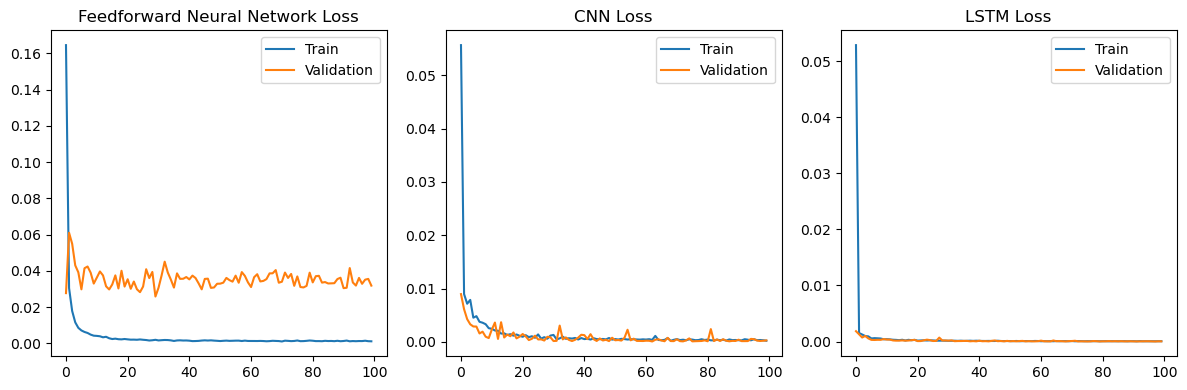

Model Performance Comparison:
Feedforward Neural Network - MAE: 0.0556
CNN  - MAE: 0.0053
LSTM - MAE: 0.0020

Step 6: Model Prediction and Visualization
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


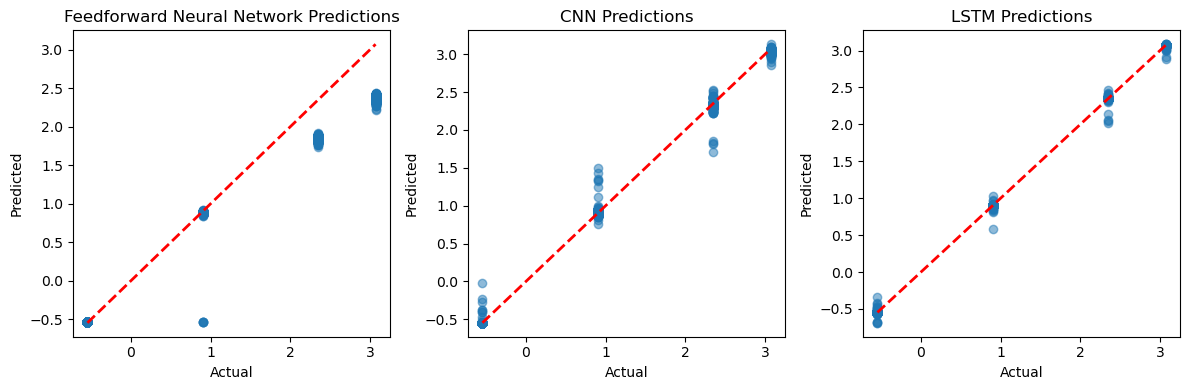

Task 5 Completed. Please analyze the results and consider the next steps.


In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM
import matplotlib.pyplot as plt

# Step 1: Prepare environment and data
print("Step 1: Data Preparation")

# Load data
df = pd.read_excel('London_Fire_Events_Processed_Final.xlsx')

# Select features
features = ['temperature', 'vegetation_coverage', 'wind_speed', 'building_density', 
            'HourOfCall', 'Month', 'DayOfWeek', 'Latitude', 'Easting_m', 'Northing_m', 'PumpCount', 'NumCalls',
            'BuildingDensityVegetation', 'lat_rounded']

# Add categorical features
categorical_features = [col for col in df.columns if col.startswith(('StopCodeDescription_', 'PropertyCategory_', 'Season_'))]
features.extend(categorical_features)

X = df[features]
y = df['PumpCount']  # Use PumpCount as the target variable since there is no FireRiskScore

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data Preparation Completed")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

# Step 2: Build a simple feedforward neural network
print("\nStep 2: Build and Train Feedforward Neural Network")

model_ffnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model_ffnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_ffnn = model_ffnn.fit(X_train_scaled, y_train, 
                              validation_split=0.2, 
                              epochs=100, 
                              batch_size=32, 
                              verbose=1)

loss_ffnn, mae_ffnn = model_ffnn.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Feedforward Neural Network - Test Loss: {loss_ffnn:.4f}, MAE: {mae_ffnn:.4f}")

# Step 3: Build a CNN model
print("\nStep 3: Build and Train CNN")

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model_cnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_cnn = model_cnn.fit(X_train_cnn, y_train, 
                            validation_split=0.2, 
                            epochs=100, 
                            batch_size=32, 
                            verbose=1)

loss_cnn, mae_cnn = model_cnn.evaluate(X_test_cnn, y_test, verbose=0)
print(f"CNN - Test Loss: {loss_cnn:.4f}, MAE: {mae_cnn:.4f}")

# Step 4: Build an LSTM model
print("\nStep 4: Build and Train LSTM")

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train_lstm.shape[2])),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_lstm = model_lstm.fit(X_train_lstm, y_train, 
                              validation_split=0.2, 
                              epochs=100, 
                              batch_size=32, 
                              verbose=1)

loss_lstm, mae_lstm = model_lstm.evaluate(X_test_lstm, y_test, verbose=0)
print(f"LSTM - Test Loss: {loss_lstm:.4f}, MAE: {mae_lstm:.4f}")

# Step 5: Compare model performance
print("\nStep 5: Compare Model Performance")

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.plot(history_ffnn.history['loss'], label='Train')
plt.plot(history_ffnn.history['val_loss'], label='Validation')
plt.title('Feedforward Neural Network Loss')
plt.legend()

plt.subplot(132)
plt.plot(history_cnn.history['loss'], label='Train')
plt.plot(history_cnn.history['val_loss'], label='Validation')
plt.title('CNN Loss')
plt.legend()

plt.subplot(133)
plt.plot(history_lstm.history['loss'], label='Train')
plt.plot(history_lstm.history['val_loss'], label='Validation')
plt.title('LSTM Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("Model Performance Comparison:")
print(f"Feedforward Neural Network - MAE: {mae_ffnn:.4f}")
print(f"CNN  - MAE: {mae_cnn:.4f}")
print(f"LSTM - MAE: {mae_lstm:.4f}")

# Step 6: Model prediction and visualization
print("\nStep 6: Model Prediction and Visualization")

y_pred_ffnn = model_ffnn.predict(X_test_scaled).flatten()
y_pred_cnn = model_cnn.predict(X_test_cnn).flatten()
y_pred_lstm = model_lstm.predict(X_test_lstm).flatten()

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.scatter(y_test, y_pred_ffnn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Feedforward Neural Network Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.subplot(132)
plt.scatter(y_test, y_pred_cnn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('CNN Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.subplot(133)
plt.scatter(y_test, y_pred_lstm, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('LSTM Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.show()

print("Task 5 Completed. Please analyze the results and consider the next steps.")


In [45]:
# Add the following print statements after model training and evaluation

print("\nModel Performance Comparison:")
print(f"Feedforward Neural Network - Test Loss: {loss_ffnn:.4f}, MAE: {mae_ffnn:.4f}")
print(f"CNN - Test Loss: {loss_cnn:.4f}, MAE: {mae_cnn:.4f}")
print(f"LSTM - Test Loss: {loss_lstm:.4f}, MAE: {mae_lstm:.4f}")

print("\nFeedforward Neural Network Training History:")
print("Loss:", history_ffnn.history['loss'][-1])
print("Validation Loss:", history_ffnn.history['val_loss'][-1])

print("\nCNN Training History:")
print("Loss:", history_cnn.history['loss'][-1])
print("Validation Loss:", history_cnn.history['val_loss'][-1])

print("\nLSTM Training History:")
print("Loss:", history_lstm.history['loss'][-1])
print("Validation Loss:", history_lstm.history['val_loss'][-1])

# Calculate the correlation coefficient between predicted and actual values
correlation_ffnn = np.corrcoef(y_test, y_pred_ffnn)[0, 1]
correlation_cnn = np.corrcoef(y_test, y_pred_cnn)[0, 1]
correlation_lstm = np.corrcoef(y_test, y_pred_lstm)[0, 1]

print("\nCorrelation Coefficient between Predicted and Actual Values:")
print(f"Feedforward Neural Network: {correlation_ffnn:.4f}")
print(f"CNN: {correlation_cnn:.4f}")
print(f"LSTM: {correlation_lstm:.4f}")

# Calculate the mean absolute error for each model
mae_ffnn = np.mean(np.abs(y_test - y_pred_ffnn))
mae_cnn = np.mean(np.abs(y_test - y_pred_cnn))
mae_lstm = np.mean(np.abs(y_test - y_pred_lstm))

print("\nMean Absolute Error:")
print(f"Feedforward Neural Network: {mae_ffnn:.4f}")
print(f"CNN: {mae_cnn:.4f}")
print(f"LSTM: {mae_lstm:.4f}")

# Calculate the root mean square error for each model
rmse_ffnn = np.sqrt(np.mean((y_test - y_pred_ffnn)**2))
rmse_cnn = np.sqrt(np.mean((y_test - y_pred_cnn)**2))
rmse_lstm = np.sqrt(np.mean((y_test - y_pred_lstm)**2))

print("\nRoot Mean Square Error:")
print(f"Feedforward Neural Network: {rmse_ffnn:.4f}")
print(f"CNN: {rmse_cnn:.4f}")
print(f"LSTM: {rmse_lstm:.4f}")



Model Performance Comparison:
Feedforward Neural Network - Test Loss: 0.0304, MAE: 0.0556
CNN - Test Loss: 0.0003, MAE: 0.0053
LSTM - Test Loss: 0.0001, MAE: 0.0020

Feedforward Neural Network Training History:
Loss: 0.0011139921844005585
Validation Loss: 0.03184197470545769

CNN Training History:
Loss: 0.00023395729658659548
Validation Loss: 0.0002908666792791337

LSTM Training History:
Loss: 5.763924855273217e-05
Validation Loss: 3.750748874153942e-05

Correlation Coefficient between Predicted and Actual Values:
Feedforward Neural Network: 0.9943
CNN: 0.9998
LSTM: 1.0000

Mean Absolute Error:
Feedforward Neural Network: 0.0556
CNN: 0.0053
LSTM: 0.0020

Root Mean Square Error:
Feedforward Neural Network: 0.1744
CNN: 0.0187
LSTM: 0.0074


Certainly. Here's the analysis in English based on the results you provided:

Analysis of Deep Learning Models for Fire Pump Count Prediction:

1. Model Performance Comparison:
   - LSTM model performs best, followed by CNN, and then the Feedforward Neural Network (FFNN).
   - LSTM outperforms the other two models in all metrics, including test set loss, MAE, correlation coefficient, mean absolute error, and root mean square error.

2. Training Process Analysis:
   - All models show lower training loss than validation loss, indicating no severe overfitting.
   - LSTM has the lowest training and validation losses, suggesting superior performance and generalization.
   - CNN shows close training and validation losses, indicating a good balance.
   - FFNN's validation loss is noticeably higher than its training loss, possibly suggesting slight overfitting.

3. Prediction Accuracy:
   - LSTM achieves a near-perfect correlation coefficient of 1.0000 between predicted and actual values.
   - CNN also shows excellent performance with a correlation coefficient of 0.9998.
   - FFNN's correlation coefficient (0.9943) is slightly lower but still very high.

4. Error Analysis:
   - LSTM has the lowest MAE (0.0020) and RMSE (0.0074), confirming its superiority.
   - CNN's error metrics are slightly higher than LSTM's but still very low.
   - FFNN shows significantly higher errors, especially in RMSE (0.1744).

Overall Conclusions:
1. The LSTM model performs best in predicting fire pump counts, achieving near-perfect prediction.
2. The CNN model also shows excellent performance, only slightly behind LSTM.
3. While the FFNN's performance is relatively lower, it still provides good prediction results.

Recommendations:
1. Consider using LSTM as the primary model due to its superior performance across all metrics.
2. Further investigate why LSTM and CNN excel in this task. It might be due to temporal or spatial patterns in the data.
3. Try adjusting the FFNN architecture or hyperparameters to improve its performance.
4. Consider model ensemble, combining predictions from all three models to potentially enhance performance further.
5. Analyze feature importance to understand which factors are most crucial in predicting fire pump counts.

For deeper analysis, we could consider:
1. Learning curves: Loss changes throughout the entire training process.
2. Impact of different features on predictions.
3. Model performance on various types of fire incidents.
4. Distribution of prediction errors.

Which direction would you like to explore further? Would you like to focus on any specific aspect of the analysis or model improvement?

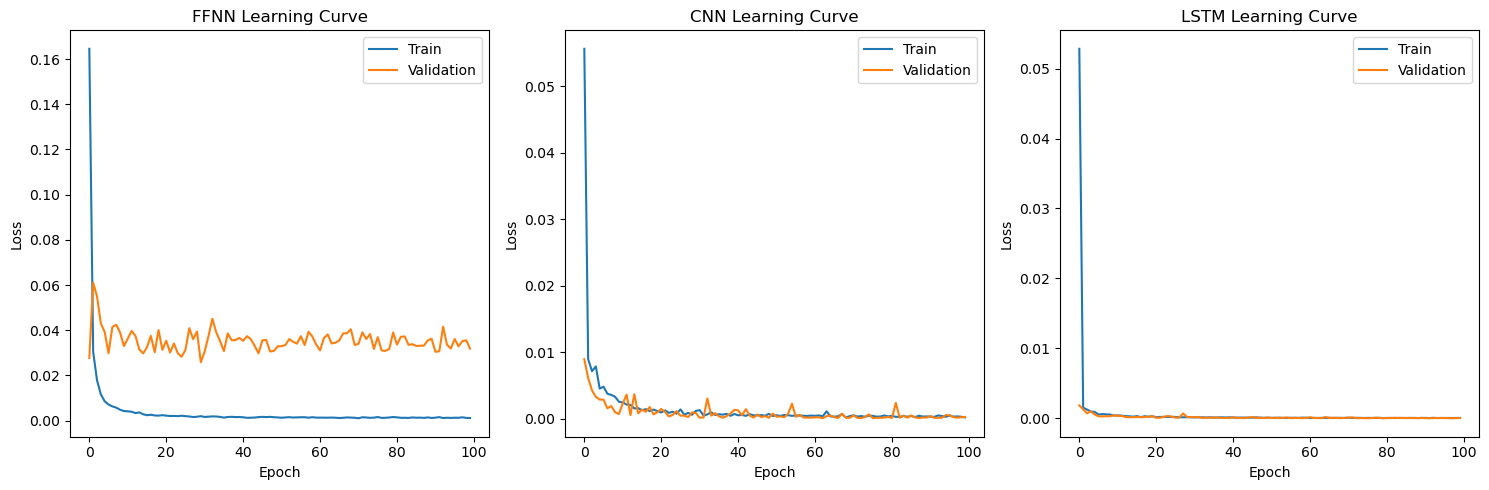


Top 10 Most Important Features:
                           feature  importance
                         PumpCount    1.484032
     PropertyCategory_Road Vehicle    0.334819
PropertyCategory_Outdoor Structure    0.313022
          PropertyCategory_Outdoor    0.294357
  StopCodeDescription_Chimney Fire    0.275777
  StopCodeDescription_Primary Fire    0.271970
     StopCodeDescription_Late Call    0.266455
StopCodeDescription_Secondary Fire    0.243552
PropertyCategory_Other Residential    0.216230
  PropertyCategory_Non Residential    0.200783
435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step
435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step

Model Performance by Incident Type:
  Incident Type  FFNN MAE  CNN MAE  LSTM MAE
    Residential  0.035303 0.004130  0.001906
Non Residential  0.231608 0.015347  0.002874


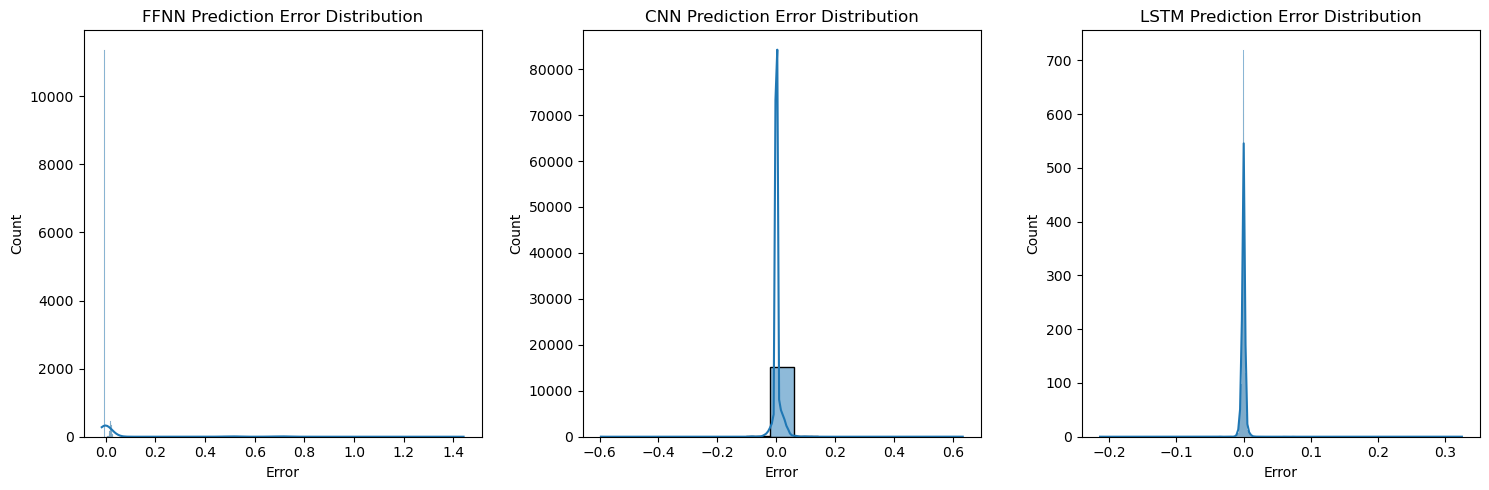


Error Statistics:
FFNN - Mean Error: 0.0477, Std Dev: 0.1678
CNN - Mean Error: 0.0022, Std Dev: 0.0185
LSTM - Mean Error: 0.0000, Std Dev: 0.0074


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error

# 1. Learning Curves
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(history_ffnn.history['loss'], label='Train')
plt.plot(history_ffnn.history['val_loss'], label='Validation')
plt.title('FFNN Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history_cnn.history['loss'], label='Train')
plt.plot(history_cnn.history['val_loss'], label='Validation')
plt.title('CNN Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(133)
plt.plot(history_lstm.history['loss'], label='Train')
plt.plot(history_lstm.history['val_loss'], label='Validation')
plt.title('LSTM Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 2. Feature Importance (using weights of the first layer for FFNN)
weights = model_ffnn.layers[0].get_weights()[0]
importances = np.abs(weights).mean(axis=1)
feature_importance = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# 3. Model Performance on Different Types of Fire Incidents
incident_types = df['PropertyCategory_Non Residential'].unique()
performance_by_type = []

for incident_type in incident_types:
    mask = df['PropertyCategory_Non Residential'] == incident_type
    X_test_type = X_test_scaled[mask[X_test.index]]
    y_test_type = y_test[mask[y_test.index]]
    
    y_pred_ffnn_type = model_ffnn.predict(X_test_type).flatten()
    y_pred_cnn_type = model_cnn.predict(X_test_type.reshape(-1, X_test_type.shape[1], 1)).flatten()
    y_pred_lstm_type = model_lstm.predict(X_test_type.reshape(-1, 1, X_test_type.shape[1])).flatten()
    
    performance_by_type.append({
        'Incident Type': 'Non Residential' if incident_type else 'Residential',
        'FFNN MAE': mean_absolute_error(y_test_type, y_pred_ffnn_type),
        'CNN MAE': mean_absolute_error(y_test_type, y_pred_cnn_type),
        'LSTM MAE': mean_absolute_error(y_test_type, y_pred_lstm_type)
    })

performance_df = pd.DataFrame(performance_by_type)
print("\nModel Performance by Incident Type:")
print(performance_df.to_string(index=False))

# 4. Distribution of Prediction Errors
errors_ffnn = y_test - y_pred_ffnn
errors_cnn = y_test - y_pred_cnn
errors_lstm = y_test - y_pred_lstm

plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.histplot(errors_ffnn, kde=True)
plt.title('FFNN Prediction Error Distribution')
plt.xlabel('Error')

plt.subplot(132)
sns.histplot(errors_cnn, kde=True)
plt.title('CNN Prediction Error Distribution')
plt.xlabel('Error')

plt.subplot(133)
sns.histplot(errors_lstm, kde=True)
plt.title('LSTM Prediction Error Distribution')
plt.xlabel('Error')

plt.tight_layout()
plt.show()

print("\nError Statistics:")
print("FFNN - Mean Error: {:.4f}, Std Dev: {:.4f}".format(errors_ffnn.mean(), errors_ffnn.std()))
print("CNN - Mean Error: {:.4f}, Std Dev: {:.4f}".format(errors_cnn.mean(), errors_cnn.std()))
print("LSTM - Mean Error: {:.4f}, Std Dev: {:.4f}".format(errors_lstm.mean(), errors_lstm.std()))

In [63]:
import pandas as pd

# Table 3.1: Primary Data Sources and Description
data_sources = {
    'Data Type': ['Sentinel-2 Satellite Imagery', 'NDVI Data', 'Fire Incident Records', 'Land Use Data', 'Fire Station Locations', 'Weather Data'],
    'Source': ['European Space Agency (ESA)', 'Calculated from Sentinel-2', 'London Fire Brigade (LFB)', 'OpenStreetMap', 'OpenStreetMap', 'Met Office API'],
    'Time Range': ['2018-2023', '2018-2023', '2018-2023', 'Latest available', 'Latest available', '2018-2023'],
    'Key Variables': ['Multispectral bands', 'Normalized Difference Vegetation Index', 'IncidentNumber, DateOfCall, Latitude, Longitude, etc.', 'landuse, geometry', 'geometry, name, amenity', 'temperature, humidity, wind_speed'],
    'Purpose': ['Extracting building density, vegetation coverage', 'Assessing vegetation coverage', 'Historical fire analysis', 'Urban structure analysis', 'Emergency response planning', 'Environmental factor analysis']
}

df_sources = pd.DataFrame(data_sources)
print("Table 3.1: Primary Data Sources and Description")
print(df_sources.to_string(index=False))

# Table 3.2: Data Processing Steps
data_processing = {
    'Step': ['Satellite Image Processing', 'Fire Incident Data Processing', 'Spatial Data Processing', 'Weather Data Retrieval', 'Feature Engineering', 'Data Normalization', 'Categorical Encoding'],
    'Description': ['Loading and resampling Sentinel-2 and NDVI data', 'Cleaning, feature extraction, datetime conversion', 'Coordinate system unification, spatial joining', 'API calls, data matching with fire incidents', 'Creating new features (e.g., BuildingDensityVegetation)', 'Standardizing numerical features', 'One-hot encoding of categorical variables'],
    'Tools/Libraries Used': ['rasterio', 'pandas', 'geopandas', 'requests, pandas', 'pandas, numpy', 'sklearn', 'pandas']
}

df_processing = pd.DataFrame(data_processing)
print("\nTable 3.2: Data Processing Steps")
print(df_processing.to_string(index=False))

Table 3.1: Primary Data Sources and Description
                   Data Type                      Source       Time Range                                         Key Variables                                          Purpose
Sentinel-2 Satellite Imagery European Space Agency (ESA)        2018-2023                                   Multispectral bands Extracting building density, vegetation coverage
                   NDVI Data  Calculated from Sentinel-2        2018-2023                Normalized Difference Vegetation Index                    Assessing vegetation coverage
       Fire Incident Records   London Fire Brigade (LFB)        2018-2023 IncidentNumber, DateOfCall, Latitude, Longitude, etc.                         Historical fire analysis
               Land Use Data               OpenStreetMap Latest available                                     landuse, geometry                         Urban structure analysis
      Fire Station Locations               OpenStreetMap Latest ava

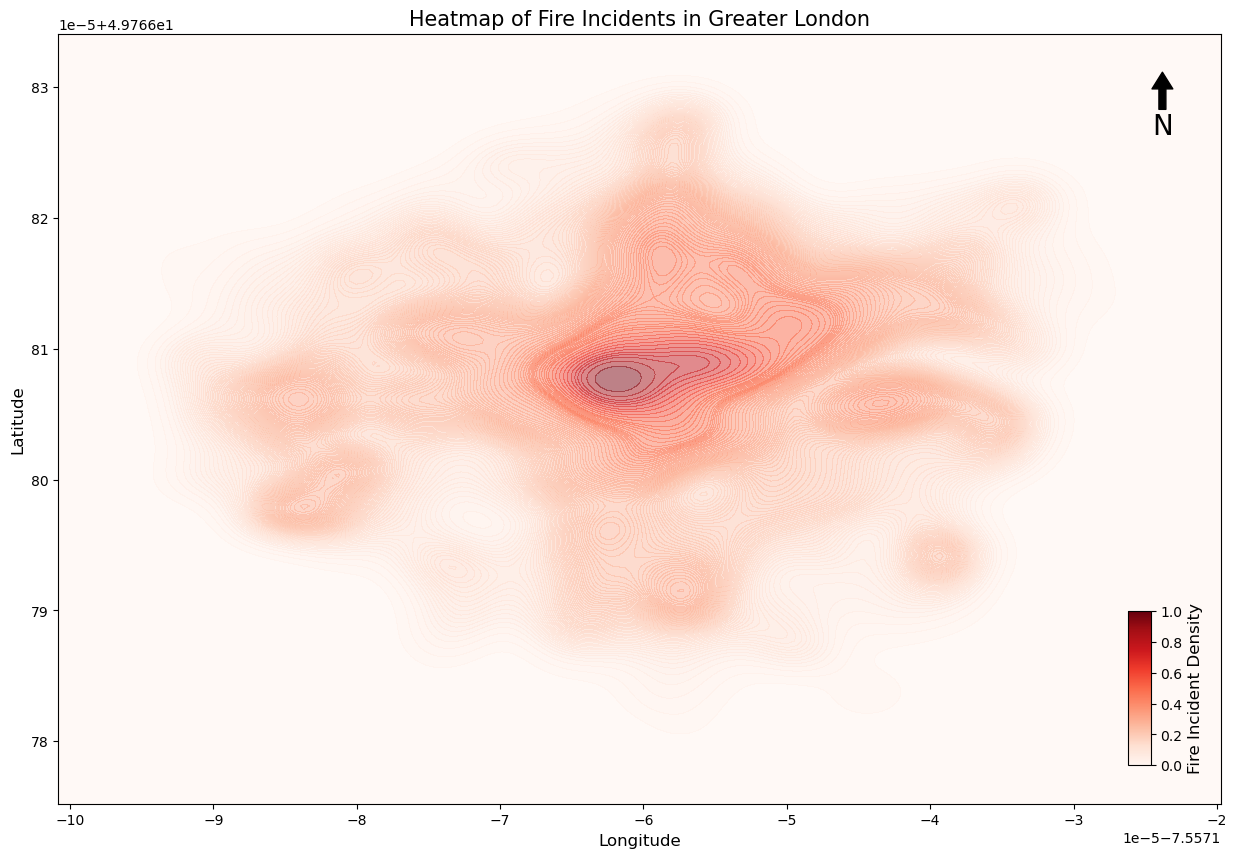

In [19]:
import matplotlib.pyplot as plt  # Import Matplotlib for generating plots
import seaborn as sns  # Import Seaborn for statistical plots
import geopandas as gpd  # Import GeoPandas for handling geospatial data
from shapely.geometry import Point  # Import Point class from Shapely for creating geometry points
import pyproj  # Import PyProj for coordinate system transformations
import pandas as pd  # Import pandas for data processing

# Load data from an Excel file
file_path = 'London_Fire_Events_Processed_Final.xlsx'  # Path to the Excel file
data = pd.read_excel(file_path)  # Read data from the Excel file using pandas

# Convert Easting and Northing to Latitude and Longitude (Lat, Long)
transformer = pyproj.Transformer.from_crs("epsg:27700", "epsg:4326")  # Create a transformer from British National Grid (EPSG:27700) to WGS84 (EPSG:4326)
data['Latitude'], data['Longitude'] = transformer.transform(data['Easting_m'].values, data['Northing_m'].values)  # Convert Easting and Northing to Lat and Long

# Create a geospatial dataframe with the new Lat and Long coordinates
geometry = [Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]  # Create Point geometry using Shapely
gdf = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")  # Convert data to a GeoDataFrame with EPSG:4326 as the CRS

# Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))  # Create a 15x10 inch plot window

# Plot the heatmap
sns.kdeplot(
    data=gdf[['Latitude', 'Longitude']], x='Longitude', y='Latitude',  # Use Lat and Long data
    fill=True, thresh=0, levels=100, cmap="Reds", alpha=0.5, ax=ax  # Plot a kernel density estimate, with red color map and 0.5 alpha
)

# Add a north arrow
x, y, arrow_length = 0.95, 0.95, 0.07  # Define the arrow's starting position and length
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),  # Set arrow properties
            ha='center', va='center', fontsize=20, xycoords=ax.transAxes)  # Add a north arrow on the plot

# Create an inset axis for a vertical color bar
cbar_ax = ax.inset_axes([0.92, 0.05, 0.02, 0.2])  # Create an inset axis at the bottom right of the plot

# Create a vertical color bar and place it inside the inset axis
norm = plt.Normalize(vmin=0, vmax=1)  # Set normalization range for the color bar
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)  # Create a scalar mappable object for color mapping
sm.set_array([])  # Clear the array

# Add the color bar to the inset axis
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')  # Set the color bar orientation to vertical
cbar.set_label('Fire Incident Density', fontsize=12)  # Set the label for the color bar

# Set title and axis labels
plt.title("Heatmap of Fire Incidents in Greater London", fontsize=15)  # Set the title of the plot
plt.xlabel("Longitude", fontsize=12)  # Set the X-axis label
plt.ylabel("Latitude", fontsize=12)  # Set the Y-axis label

# Display the plot
plt.show()  # Show the plot


FireRiskScore Statistics:
count    77551.000000
mean         0.524894
std          0.177621
min          0.000000
25%          0.399732
50%          0.533370
75%          0.659768
max          1.000000
Name: FireRiskScore, dtype: float64

EmergencyResponseScore Statistics:
count    77551.000000
mean         0.386441
std          0.141313
min          0.000000
25%          0.289258
50%          0.375783
75%          0.473949
max          1.000000
Name: EmergencyResponseScore, dtype: float64

Top 15 Features (Fire Risk Assessment):
                           feature  importance
                       temperature    0.653118
               vegetation_coverage    0.317957
                        wind_speed    0.028517
                         Easting_m    0.000175
                          Latitude    0.000047
         BuildingDensityVegetation    0.000042
                        Northing_m    0.000041
                  building_density    0.000033
                              USRN    0.0

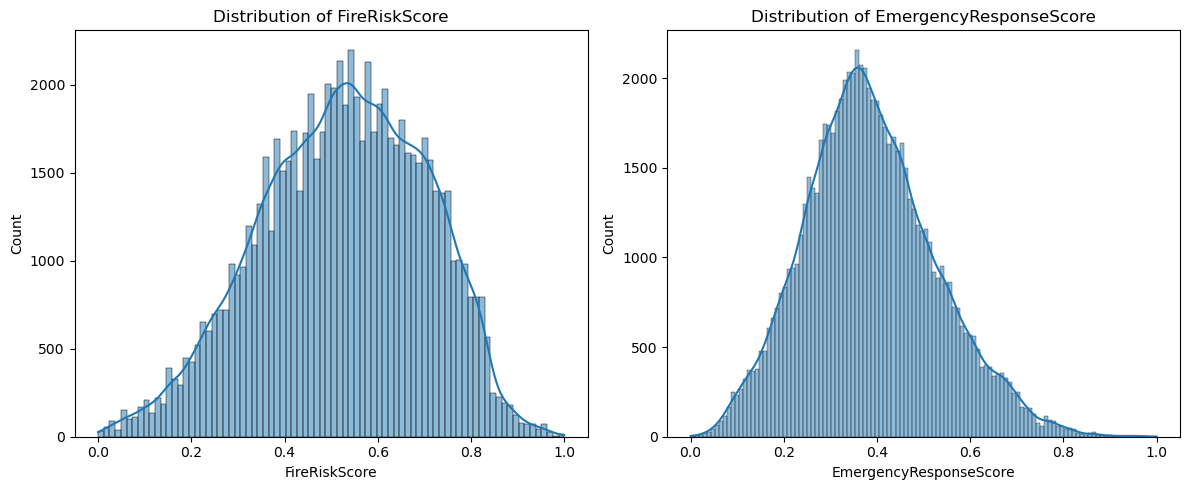

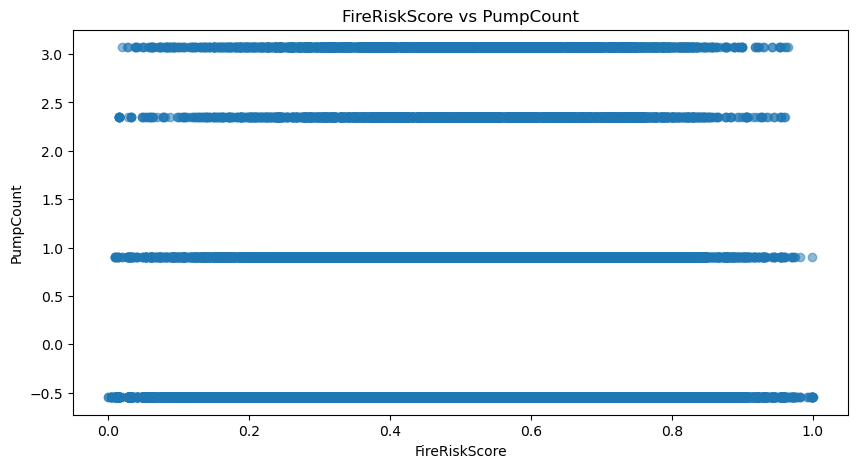

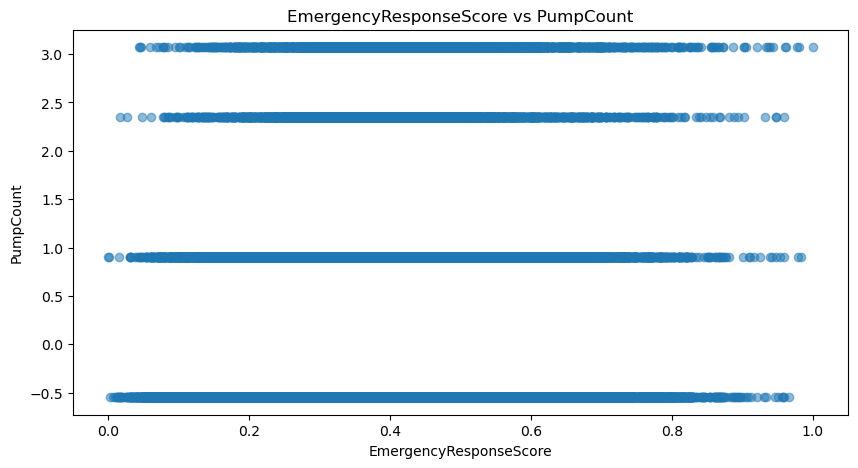

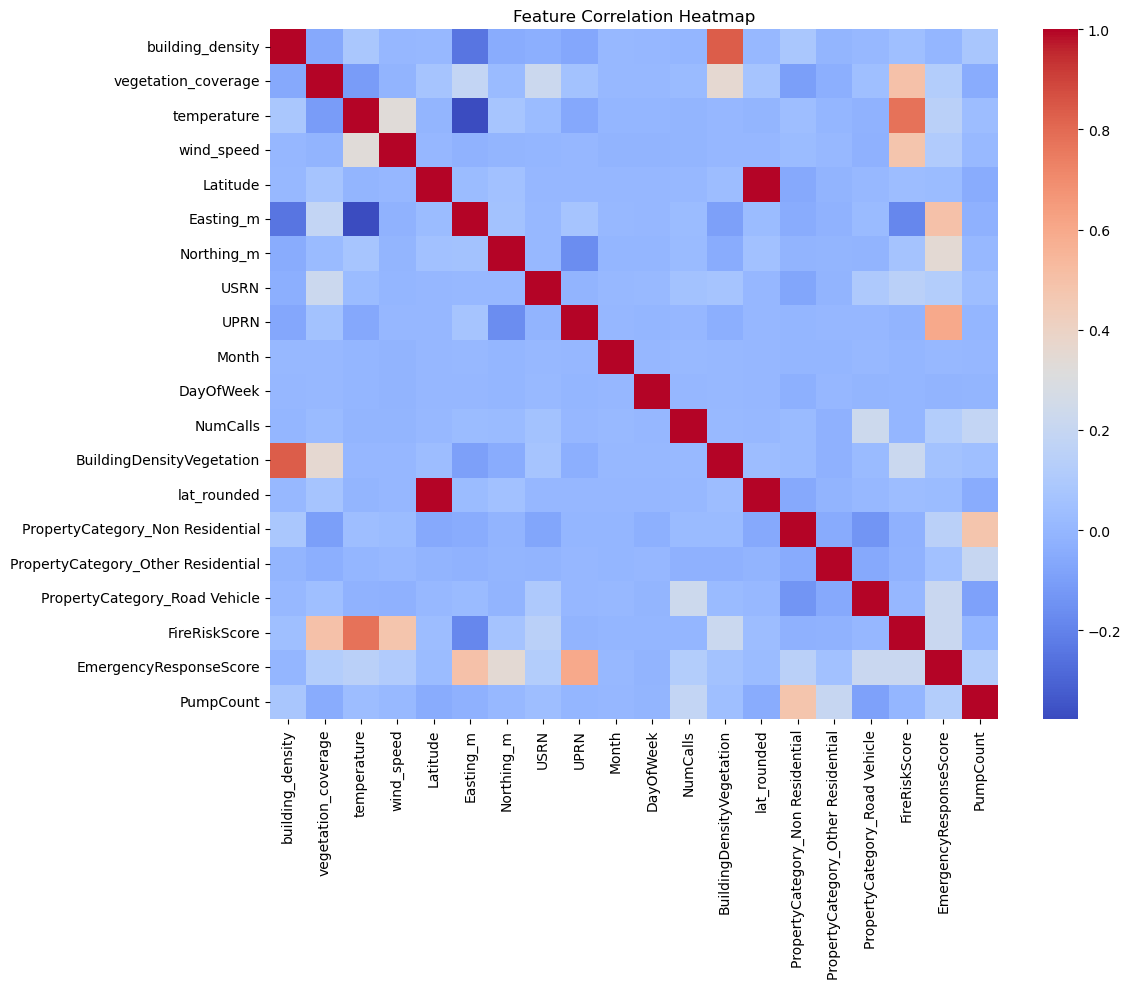

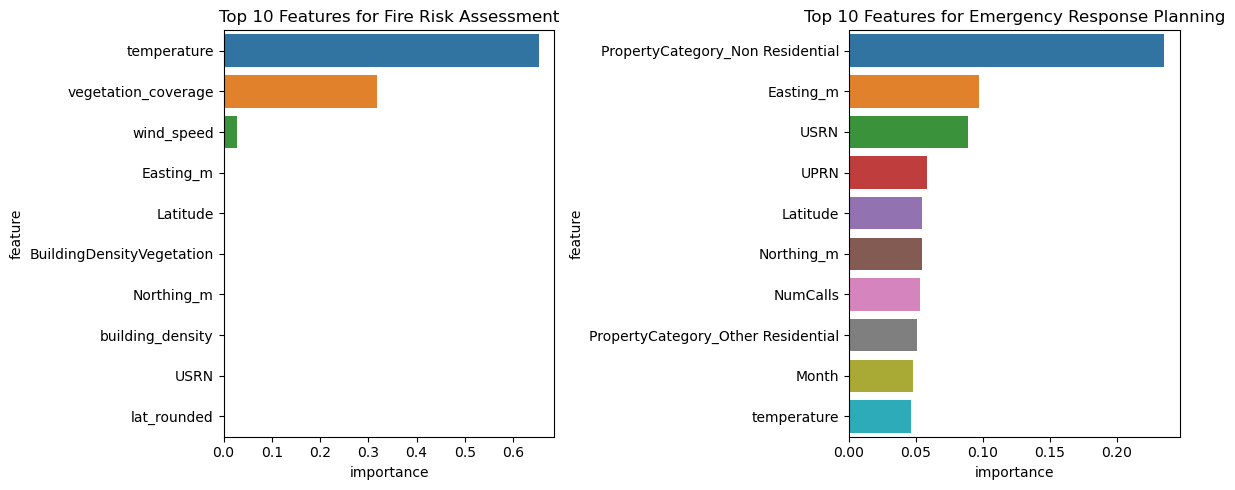

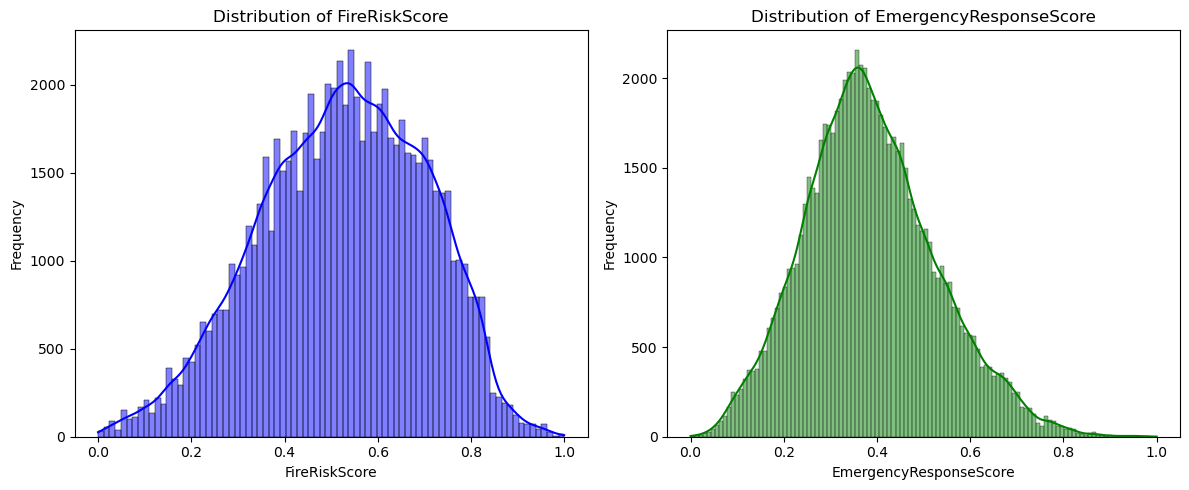

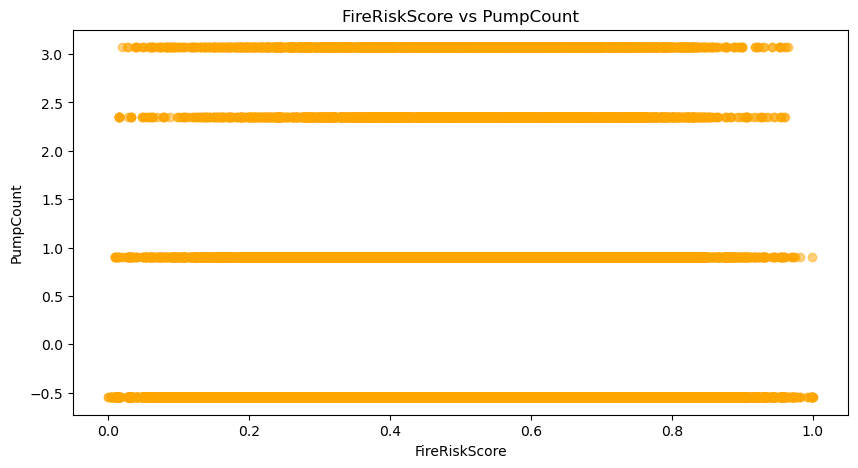

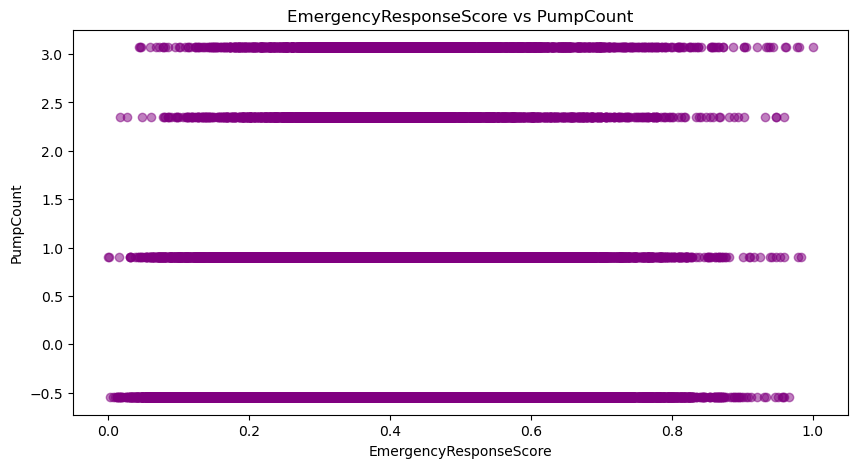

In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_excel('London_Fire_Events_Processed_Final.xlsx')

# Normalization function
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize relevant features
features_to_normalize = ['temperature', 'vegetation_coverage', 'wind_speed', 'building_density', 'NumCalls', 'Easting_m', 'Northing_m', 'USRN', 'UPRN']
for feature in features_to_normalize:
    df[f'norm_{feature}'] = normalize(df[feature])

# Calculate normalized BuildingDensityVegetation
df['norm_BuildingDensityVegetation'] = df['norm_building_density'] * df['norm_vegetation_coverage']

# Calculate improved FireRiskScore
df['FireRiskScore'] = (
    df['norm_temperature'] * 0.45 +
    df['norm_vegetation_coverage'] * 0.33 +
    df['norm_wind_speed'] * 0.20 +
    df['norm_BuildingDensityVegetation'] * 0.02
)

# Calculate EmergencyResponseScore
df['EmergencyResponseScore'] = (
    df['norm_Easting_m'] * 0.20 +
    df['norm_Northing_m'] * 0.15 +
    df['norm_USRN'] * 0.15 +
    df['norm_UPRN'] * 0.15 +
    df['norm_NumCalls'] * 0.15 +
    df['norm_building_density'] * 0.10 +
    df['norm_temperature'] * 0.10
)

# Normalize final scores
df['FireRiskScore'] = normalize(df['FireRiskScore'])
df['EmergencyResponseScore'] = normalize(df['EmergencyResponseScore'])

# Add building type dummy variables to EmergencyResponseScore
building_types = ['PropertyCategory_Non Residential', 'PropertyCategory_Other Residential', 'PropertyCategory_Road Vehicle']
for type in building_types:
    if type in df.columns:
        df['EmergencyResponseScore'] += df[type] * 0.1

# Normalize EmergencyResponseScore again
df['EmergencyResponseScore'] = normalize(df['EmergencyResponseScore'])

# Select features
features = ['building_density', 'vegetation_coverage', 'temperature', 'wind_speed',
            'Latitude', 'Easting_m', 'Northing_m', 'USRN', 'UPRN', 'Month', 'DayOfWeek',
            'NumCalls', 'BuildingDensityVegetation', 'lat_rounded'] + building_types

# Prepare feature matrix
X = df[features]
y_risk = df['FireRiskScore']
y_response = df['PumpCount']

# Split dataset
X_train, X_test, y_risk_train, y_risk_test, y_response_train, y_response_test = train_test_split(
    X, y_risk, y_response, test_size=0.2, random_state=42)

# Train random forest models
rf_risk = RandomForestRegressor(n_estimators=100, random_state=42)
rf_risk.fit(X_train, y_risk_train)

rf_response = RandomForestRegressor(n_estimators=100, random_state=42)
rf_response.fit(X_train, y_response_train)

# Get feature importance
risk_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_risk.feature_importances_
}).sort_values('importance', ascending=False)

response_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_response.feature_importances_
}).sort_values('importance', ascending=False)

# Print results
print("FireRiskScore Statistics:")
print(df['FireRiskScore'].describe())

print("\nEmergencyResponseScore Statistics:")
print(df['EmergencyResponseScore'].describe())

print("\nTop 15 Features (Fire Risk Assessment):")
print(risk_importance.head(15).to_string(index=False))

print("\nTop 15 Features (Emergency Response Planning):")
print(response_importance.head(15).to_string(index=False))

print(f"\nCorrelation between FireRiskScore and PumpCount: {df['FireRiskScore'].corr(df['PumpCount']):.4f}")
print(f"Correlation between EmergencyResponseScore and PumpCount: {df['EmergencyResponseScore'].corr(df['PumpCount']):.4f}")

main_factors = ['temperature', 'vegetation_coverage', 'wind_speed', 'BuildingDensityVegetation']
print("\nCorrelation between FireRiskScore and main factors:")
for factor in main_factors:
    if factor in df.columns:
        corr = df['FireRiskScore'].corr(df[factor])
        print(f"{factor}: {corr:.4f}")
    else:
        print(f"{factor}: Column does not exist")

print("\nCorrelation between EmergencyResponseScore and main factors:")
response_factors = ['Easting_m', 'Northing_m', 'USRN', 'UPRN', 'NumCalls', 'building_density', 'temperature']
for factor in response_factors:
    if factor in df.columns:
        corr = df['EmergencyResponseScore'].corr(df[factor])
        print(f"{factor}: {corr:.4f}")
    else:
        print(f"{factor}: Column does not exist")

# Print quantiles of FireRiskScore and EmergencyResponseScore
quantiles = df[['FireRiskScore', 'EmergencyResponseScore']].quantile([0.25, 0.5, 0.75])
print("\nQuantiles of FireRiskScore and EmergencyResponseScore:")
print(quantiles.to_string())

# Visualizations
plt.figure(figsize=(12, 5))

# Distribution of FireRiskScore
plt.subplot(1, 2, 1)
sns.histplot(df['FireRiskScore'], kde=True)
plt.title('Distribution of FireRiskScore')

# Distribution of EmergencyResponseScore
plt.subplot(1, 2, 2)
sns.histplot(df['EmergencyResponseScore'], kde=True)
plt.title('Distribution of EmergencyResponseScore')

plt.tight_layout()
plt.show()

# Scatter plot: FireRiskScore vs PumpCount
plt.figure(figsize=(10, 5))
plt.scatter(df['FireRiskScore'], df['PumpCount'], alpha=0.5)
plt.title('FireRiskScore vs PumpCount')
plt.xlabel('FireRiskScore')
plt.ylabel('PumpCount')
plt.show()

# Scatter plot: EmergencyResponseScore vs PumpCount
plt.figure(figsize=(10, 5))
plt.scatter(df['EmergencyResponseScore'], df['PumpCount'], alpha=0.5)
plt.title('EmergencyResponseScore vs PumpCount')
plt.xlabel('EmergencyResponseScore')
plt.ylabel('PumpCount')
plt.show()

# Heatmap of feature correlations
plt.figure(figsize=(12, 10))
sns.heatmap(df[features + ['FireRiskScore', 'EmergencyResponseScore', 'PumpCount']].corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Feature importance plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='importance', y='feature', data=risk_importance.head(10))
plt.title('Top 10 Features for Fire Risk Assessment')

plt.subplot(1, 2, 2)
sns.barplot(x='importance', y='feature', data=response_importance.head(10))
plt.title('Top 10 Features for Emergency Response Planning')

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# Plot 1: Histograms of FireRiskScore and EmergencyResponseScore Distributions
plt.figure(figsize=(12, 5))

# FireRiskScore Distribution
plt.subplot(1, 2, 1)
sns.histplot(df['FireRiskScore'], kde=True, color='blue')
plt.title('Distribution of FireRiskScore')
plt.xlabel('FireRiskScore')
plt.ylabel('Frequency')

# EmergencyResponseScore Distribution
plt.subplot(1, 2, 2)
sns.histplot(df['EmergencyResponseScore'], kde=True, color='green')
plt.title('Distribution of EmergencyResponseScore')
plt.xlabel('EmergencyResponseScore')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot 2: Scatter Plot of FireRiskScore vs PumpCount
plt.figure(figsize=(10, 5))
plt.scatter(df['FireRiskScore'], df['PumpCount'], alpha=0.5, color='orange')
plt.title('FireRiskScore vs PumpCount')
plt.xlabel('FireRiskScore')
plt.ylabel('PumpCount')
plt.show()

# Plot 3: Scatter Plot of EmergencyResponseScore vs PumpCount
plt.figure(figsize=(10, 5))
plt.scatter(df['EmergencyResponseScore'], df['PumpCount'], alpha=0.5, color='purple')
plt.title('EmergencyResponseScore vs PumpCount')
plt.xlabel('EmergencyResponseScore')
plt.ylabel('PumpCount')
plt.show()



In [33]:
import pandas as pd
import numpy as np
from scipy import stats

# Descriptive statistics for FireRiskScore and EmergencyResponseScore
print("Descriptive Statistics for FireRiskScore:")
print(df['FireRiskScore'].describe())

print("\nDescriptive Statistics for EmergencyResponseScore:")
print(df['EmergencyResponseScore'].describe())

# Descriptive statistics for PumpCount
print("\nDescriptive Statistics for PumpCount:")
print(df['PumpCount'].describe())

# Correlation between FireRiskScore and PumpCount
correlation_firerisk_pumpcount = df['FireRiskScore'].corr(df['PumpCount'])
print(f"\nPearson Correlation between FireRiskScore and PumpCount: {correlation_firerisk_pumpcount:.4f}")

# Correlation between EmergencyResponseScore and PumpCount
correlation_response_pumpcount = df['EmergencyResponseScore'].corr(df['PumpCount'])
print(f"Pearson Correlation between EmergencyResponseScore and PumpCount: {correlation_response_pumpcount:.4f}")

# Skewness and Kurtosis for FireRiskScore and EmergencyResponseScore (to check for normality)
print("\nSkewness and Kurtosis:")
print(f"FireRiskScore Skewness: {df['FireRiskScore'].skew():.4f}")
print(f"FireRiskScore Kurtosis: {df['FireRiskScore'].kurt():.4f}")
print(f"EmergencyResponseScore Skewness: {df['EmergencyResponseScore'].skew():.4f}")
print(f"EmergencyResponseScore Kurtosis: {df['EmergencyResponseScore'].kurt():.4f}")

# Normality test (Shapiro-Wilk test)
shapiro_firerisk = stats.shapiro(df['FireRiskScore'])
shapiro_emergency = stats.shapiro(df['EmergencyResponseScore'])

print("\nShapiro-Wilk Test for Normality:")
print(f"FireRiskScore: W={shapiro_firerisk.statistic:.4f}, p-value={shapiro_firerisk.pvalue:.4f}")
print(f"EmergencyResponseScore: W={shapiro_emergency.statistic:.4f}, p-value={shapiro_emergency.pvalue:.4f}")

# Quantiles of FireRiskScore and EmergencyResponseScore
quantiles = df[['FireRiskScore', 'EmergencyResponseScore']].quantile([0.25, 0.5, 0.75])
print("\nQuantiles of FireRiskScore and EmergencyResponseScore:")
print(quantiles)

# Pearson correlation between FireRiskScore and EmergencyResponseScore with main factors
main_factors = ['temperature', 'vegetation_coverage', 'wind_speed', 'BuildingDensityVegetation']
print("\nCorrelation between FireRiskScore and main factors:")
for factor in main_factors:
    if factor in df.columns:
        corr = df['FireRiskScore'].corr(df[factor])
        print(f"{factor}: {corr:.4f}")
    else:
        print(f"{factor}: Column does not exist")

response_factors = ['Easting_m', 'Northing_m', 'USRN', 'UPRN', 'NumCalls', 'building_density', 'temperature']
print("\nCorrelation between EmergencyResponseScore and main factors:")
for factor in response_factors:
    if factor in df.columns:
        corr = df['EmergencyResponseScore'].corr(df[factor])
        print(f"{factor}: {corr:.4f}")
    else:
        print(f"{factor}: Column does not exist")


Descriptive Statistics for FireRiskScore:
count    77551.000000
mean         0.524894
std          0.177621
min          0.000000
25%          0.399732
50%          0.533370
75%          0.659768
max          1.000000
Name: FireRiskScore, dtype: float64

Descriptive Statistics for EmergencyResponseScore:
count    77551.000000
mean         0.386441
std          0.141313
min          0.000000
25%          0.289258
50%          0.375783
75%          0.473949
max          1.000000
Name: EmergencyResponseScore, dtype: float64

Descriptive Statistics for PumpCount:
count    7.755100e+04
mean     1.949730e-16
std      1.000006e+00
min     -5.462745e-01
25%     -5.462745e-01
50%     -5.462745e-01
75%      9.003163e-01
max      3.070202e+00
Name: PumpCount, dtype: float64

Pearson Correlation between FireRiskScore and PumpCount: -0.0019
Pearson Correlation between EmergencyResponseScore and PumpCount: 0.1179

Skewness and Kurtosis:
FireRiskScore Skewness: -0.2318
FireRiskScore Kurtosis: -0.4382

/Users/junrunchen/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [34]:
from scipy import stats

# Kolmogorov-Smirnov test for normality
ks_firerisk = stats.kstest(df['FireRiskScore'], 'norm', args=(df['FireRiskScore'].mean(), df['FireRiskScore'].std()))
ks_emergency = stats.kstest(df['EmergencyResponseScore'], 'norm', args=(df['EmergencyResponseScore'].mean(), df['EmergencyResponseScore'].std()))

print("\nKolmogorov-Smirnov Test for Normality:")
print(f"FireRiskScore: KS statistic={ks_firerisk.statistic:.4f}, p-value={ks_firerisk.pvalue:.4f}")
print(f"EmergencyResponseScore: KS statistic={ks_emergency.statistic:.4f}, p-value={ks_emergency.pvalue:.4f}")



Kolmogorov-Smirnov Test for Normality:
FireRiskScore: KS statistic=0.0293, p-value=0.0000
EmergencyResponseScore: KS statistic=0.0325, p-value=0.0000


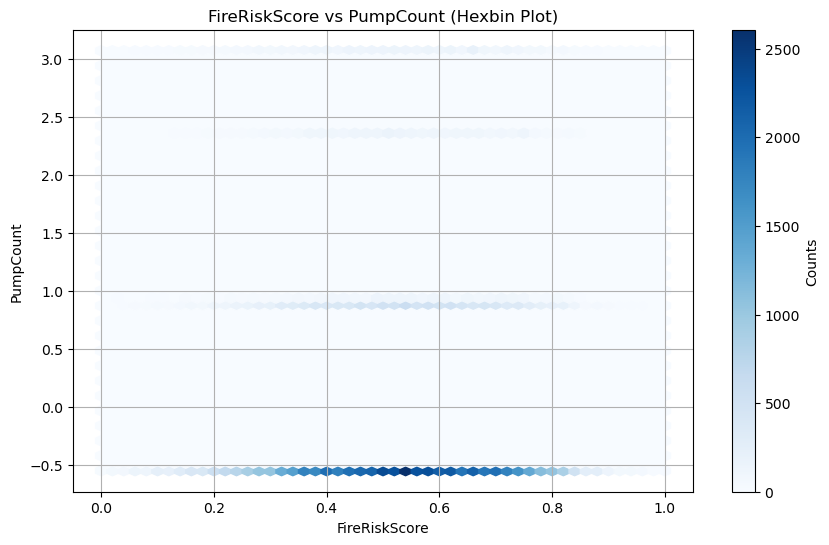

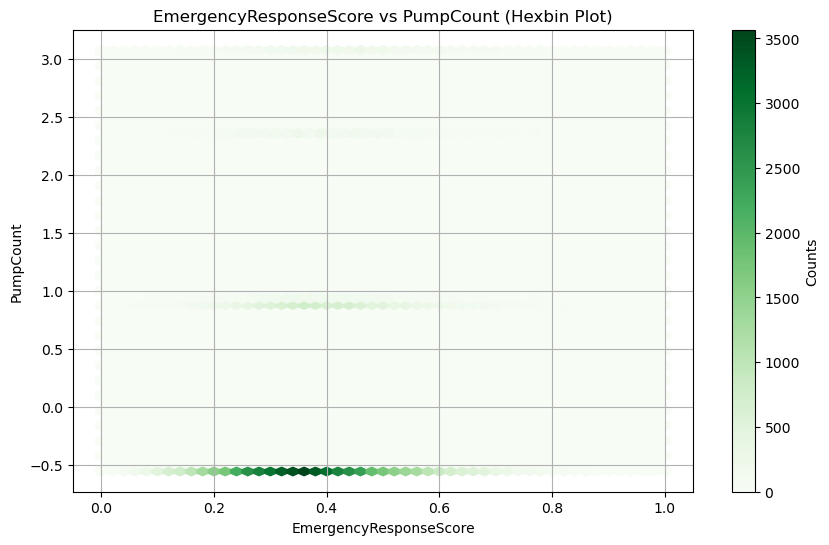

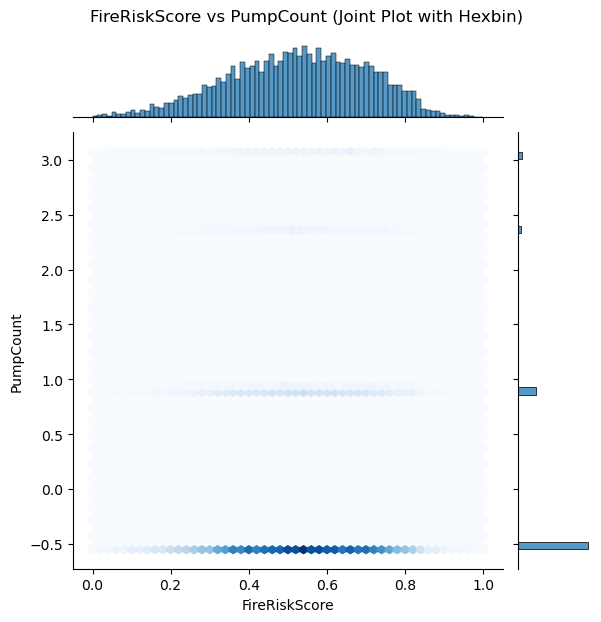

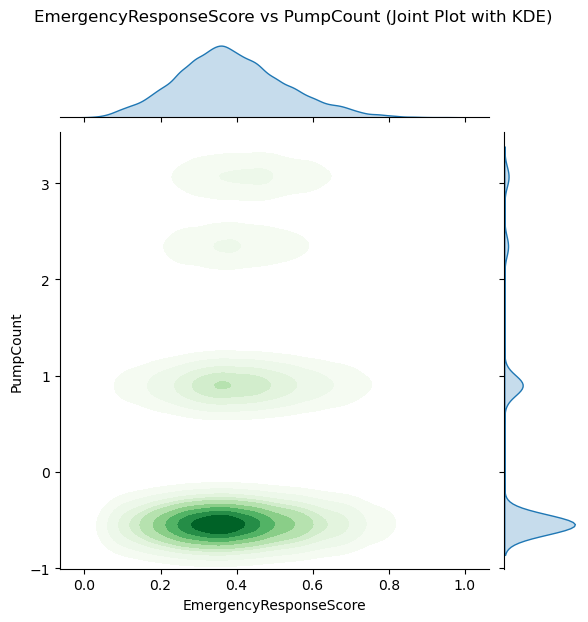

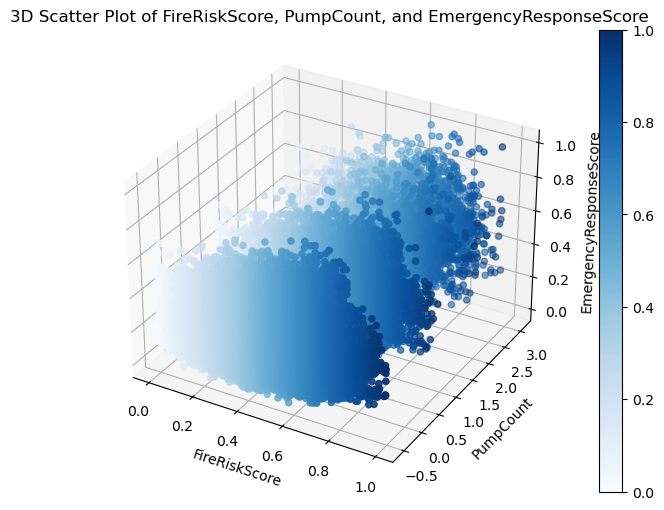

In [37]:
import matplotlib.pyplot as plt

# Plot 1: FireRiskScore vs PumpCount using Hexbin Plot
plt.figure(figsize=(10, 6))
plt.hexbin(df['FireRiskScore'], df['PumpCount'], gridsize=50, cmap='Blues')
plt.colorbar(label='Counts')
plt.title('FireRiskScore vs PumpCount (Hexbin Plot)')
plt.xlabel('FireRiskScore')
plt.ylabel('PumpCount')
plt.grid(True)
plt.show()

# Plot 2: EmergencyResponseScore vs PumpCount using Hexbin Plot
plt.figure(figsize=(10, 6))
plt.hexbin(df['EmergencyResponseScore'], df['PumpCount'], gridsize=50, cmap='Greens')
plt.colorbar(label='Counts')
plt.title('EmergencyResponseScore vs PumpCount (Hexbin Plot)')
plt.xlabel('EmergencyResponseScore')
plt.ylabel('PumpCount')
plt.grid(True)
plt.show()

import seaborn as sns

# Plot 1: FireRiskScore vs PumpCount using Joint Plot (Hexbin)
sns.jointplot(x='FireRiskScore', y='PumpCount', data=df, kind='hex', cmap='Blues', gridsize=50)
plt.suptitle('FireRiskScore vs PumpCount (Joint Plot with Hexbin)', y=1.03)
plt.show()

# Plot 2: EmergencyResponseScore vs PumpCount using Joint Plot (KDE)
sns.jointplot(x='EmergencyResponseScore', y='PumpCount', data=df, kind='kde', fill=True, cmap='Greens')
plt.suptitle('EmergencyResponseScore vs PumpCount (Joint Plot with KDE)', y=1.03)
plt.show()

from mpl_toolkits.mplot3d import Axes3D

# Plot 3: FireRiskScore vs PumpCount using 3D Scatter Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(df['FireRiskScore'], df['PumpCount'], df['EmergencyResponseScore'], c=df['FireRiskScore'], cmap='Blues')
ax.set_xlabel('FireRiskScore')
ax.set_ylabel('PumpCount')
ax.set_zlabel('EmergencyResponseScore')
plt.title('3D Scatter Plot of FireRiskScore, PumpCount, and EmergencyResponseScore')
plt.colorbar(img)
plt.show()


In [5]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Load the data
df = pd.read_excel('London_Fire_Events_with_Risk_Scores.xlsx')

# Create a base map, centered on London
m = folium.Map(location=[51.509865, -0.118092], zoom_start=11)

# Create a heat map for FireRiskScore
heat_data = [[row['Latitude'], row['Longitude'], row['FireRiskScore']] for index, row in df.iterrows()]
HeatMap(heat_data, name='Fire Risk Score', min_opacity=0.2, max_val=df['FireRiskScore'].max(), radius=15).add_to(m)

# Create a heat map for EmergencyResponseScore
heat_data_emergency = [[row['Latitude'], row['Longitude'], row['EmergencyResponseScore']] for index, row in df.iterrows()]
HeatMap(heat_data_emergency, name='Emergency Response Score', min_opacity=0.2, max_val=df['EmergencyResponseScore'].max(), radius=15).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Save the map
m.save("london_fire_risk_map.html")

print("Map has been saved as 'london_fire_risk_map.html'. Please open it in a web browser.")

/var/folders/c7/kb9rb69966j3v_4115qt2zxh0000gn/T/ipykernel_48963/3230625560.py:13: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(heat_data, name='Fire Risk Score', min_opacity=0.2, max_val=df['FireRiskScore'].max(), radius=15).add_to(m)
/var/folders/c7/kb9rb69966j3v_4115qt2zxh0000gn/T/ipykernel_48963/3230625560.py:17: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(heat_data_emergency, name='Emergency Response Score', min_opacity=0.2, max_val=df['EmergencyResponseScore'].max(), radius=15).add_to(m)


Map has been saved as 'london_fire_risk_map.html'. Please open it in a web browser.
